# Web Science Project

## Description of the problem

The purpose of this analysis is the following one: "find the top-10 most popular events during the FuoriSalone, held from 12 to 17 of April of 2016, and to extract some insights out of them". For defining the "popularity" measure, two perspectives will be considered:
- Aggregated information but possible indicator of physical presence
    - Foursquare check-ins;
    - phone activities.
- Fine-grained user interest information but not direct physical presence
    - the number of events added to any user's personal agenda;
    - the number of events searched on the map of the FuoriSalone website/app;
    - the number of events whose photos have been looked for in the FuoriSalone website/app;
    - the number of events shared in the social networks from the FuoriSalone website/app.

Here follow the libraries to be imported for the whole project and the paths to the datasets. Note that the folder "fuorisalone data" containing all the datasets should be in the same directory to avoid path errors.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re
import datetime
from functools import reduce



# Note: to avoid a unicode error, either use the double backslash \\, or change all backslashes to slashes or just put an r as 
# raw in front of the string
agenda_json_pathname = "fuorisalone data\\fuorisalone_2016_anonymous_appdata\\anon_db\\json\\agenda.json"
agenda_analytics_json_pathname = "fuorisalone data\\fuorisalone_2016_anonymous_appdata\\anon_db\\json\\agenda_analytics.json"
event_actions_analytics_json_pathname = "fuorisalone data\\fuorisalone_2016_anonymous_appdata\\anon_db\\json\\event_actions_analytics.json"
foursquare_csv_pathname = "fuorisalone data\\fuorisalone_foursquare-history-2016-04.csv"
location_json_pathname = "fuorisalone data\\fuorisalone_2016_anonymous_appdata\\anon_db\\json\\location.json"
event_json_pathname = "fuorisalone data\\fuorisalone_2016_anonymous_appdata\\anon_db\\json\\event.json"
phone_csv_pathname = "fuorisalone data\\fuorisalone_2016_phone-data\\phone.csv"

## 0 - Verification of doubts regarding the datasets.
Before starting with the solution to the addressed problem, there is one major doubt in the datasets to be tackled. The hypothesis adopted is the following one: 'agenda.json' and 'agenda_analytics.json' contain the same information, so 'agenda.json' can be discarded.

In [2]:
# Note: the json files have an incorrect syntax because all the JSON elements should be contained within a list: [{...}, ...., {...}]
# However, pandas is able to read and write line-delimited json files that are common in data processing pipelines using Hadoop or Spark.
# The parameter lines should be added and set to True

# create a DataFrame with 'agenda.json'
agenda_df = pd.read_json(agenda_json_pathname, lines=True)
# print the top rows
agenda_df.head()

,_id,event,uuid
0,{'$oid': '570373ce578695a70d01f6e9'},768,570373a2578695a70d01f6e3
1,{'$oid': '57040780e64decc8249aa051'},590,57040583e64decc8249aa043
2,{'$oid': '5704080be64decc8249aa05e'},659,57040583e64decc8249aa043
3,{'$oid': '570408a2e64decc8249aa064'},1004,57040583e64decc8249aa043
4,{'$oid': '57040998e64decc8249aa06c'},745,57040583e64decc8249aa043


In [3]:
# create a DataFrame with 'agenda_analytics.json'
agenda_analytics_df = pd.read_json(agenda_analytics_json_pathname, lines=True)
# print the top rows
agenda_analytics_df.head()

,_id,event,uuid
0,{'$oid': '570373ce1e24f28cf95d45c3'},768,570373a2578695a70d01f6e3
1,{'$oid': '570407801e24f28cf95d509c'},590,57040583e64decc8249aa043
2,{'$oid': '5704080b1e24f28cf95d509d'},659,57040583e64decc8249aa043
3,{'$oid': '570408a21e24f28cf95d509e'},1004,57040583e64decc8249aa043
4,{'$oid': '570409981e24f28cf95d50b3'},745,57040583e64decc8249aa043


In [4]:
# compare the columns (event, uuid) among the datasets to discover whether they contain the same information

# merge the two DataFrames by performing a database-style join operation by columns
# perform a left join on the key 'uuid' to find the rows in 'agenda.json' not found in 'agenda_analytics.json' based on (event, uuid) columns
# add the 'indicator' parameter, so that if True, a column to the output DataFrame called “_merge” is added  with information on the source of each row
# finally, compare the resulting DataFrame's column '_merge' with 'both' (returned when the observation’s merge key is found in both DataFrames) to get a Series of {True,False} values
diffs = pd.merge(agenda_df, agenda_analytics_df, on=['uuid','event'], how='left', indicator=True)['_merge'] == 'both'
diffs[diffs == False]

Series([], Name: _merge, dtype: bool)

The result of this analysis has confirmed the proposed hypothesis, i.e. that 'agenda.json' does not add any more information to 'agenda_analytics.json'. For this reason, the dataset 'agenda.json' can be discarded from the analysis, while 'agenda_analytics.json' will be employed.

## 1 - Solution to the problem

### Analysis of 'event.json'
The file 'event.json' has a more complex structure than the other files. Hence, before going on with the analysis, it is necessary to extract from it the elements of interest for the problem at hand.

In [5]:
# create a DataFrame with 'event.json'
# note: not all rows have a valid syntax because of the presence of NaN values
with open(event_json_pathname,'r', encoding='utf8') as f:  
    # count the number of lines in the file
    number_of_lines = len(f.readlines())  
    # reposition the file pointer at the beginning of the file
    f.seek(0)
    
    # create another file such that the file is JSON compliant: add a '[' at the beginning and a ']' at the end of the file
    with open('event_json_compliant.json', 'r+', encoding='utf8') as f2:
        #execute this line to refresh the content of the file if it's not empty
        f2.truncate()
        
        i = 1
        for line in f: 
            string_line = line
            # first line
            if i == 1:  
                # the first line contains a NaN value            
                index = string_line.find('NaN')
                line_without_nan = string_line.replace('NaN', 'null')                
                f2.write('[' + line_without_nan + ',')          
            # last line
            elif i == number_of_lines:
                f2.write(string_line + ']')
                break
            else:            
                # must substitute all NaN values so that the file is JSON compliant
                if string_line.find('NaN') != -1:
                    index = string_line.find('NaN')
                    line_without_nan = string_line.replace('NaN', 'null')                
                    f2.write(line_without_nan + ',')
                else:
                    f2.write(string_line + ',')
            i += 1                  
        f2.seek(0)

        json_file = f2.read()    
        decoded_json = json.loads(json_file) 
        
# create the DataFrame
event_df = pd.DataFrame(decoded_json)
# print the top rows
event_df.head()

,_id,author,award,brands,categories,contatti,created,days,descrizione,designers,...,modified,photos,slug,sponsor_event,status,titolo,updated,url,url_en,url_it
0,{'$oid': '570cdc6a1e24f28cf95da2fa'},emanuele@studiolabo.com,False,[],[],"{'it': '', 'en': ''}",1.458823e+12,"[{'id': '2154', 'event_id': '888', 'dataora_in...",{'it': '<p>Titti gli eventi che non sono stati...,[],...,NaN,"[{'id': '401', 'created': '2016-04-11 20:54:43...","{'it': 'eventi-fuorisalone-2016', 'en': 'event...",0,1,"{'it': 'EVENTI FUORISALONE 2016', 'en': 'EVENT...",1.460570e+12,http://fuorisalone.it/2016/api/event?id=888,http://fuorisalone.it/2016/en/events/888/event...,http://fuorisalone.it/2016/it/eventi/888/event...
1,{'$oid': '570cdc6a1e24f28cf95da2fb'},fanfulla1992@libero.it,False,"[{'id': '156', 'status': '1', 'nome': 'Fanfull...","[{'id': '7', 'status': '1', 'macrocategory_id'...","{'it': '', 'en': ''}",1.457962e+12,"[{'id': '514', 'event_id': '102', 'dataora_ini...","{'it': '', 'en': ''}","[{'id': '164', 'status': '1', 'nome': 'Orsola'...",...,1.459499e+12,[],"{'it': 'oltre-modo', 'en': 'oltre-modo-1'}",0,1,"{'it': 'Oltre modo', 'en': 'Oltre modo'}",1.460570e+12,http://fuorisalone.it/2016/api/event?id=102,http://fuorisalone.it/2016/en/events/102/oltre...,http://fuorisalone.it/2016/it/eventi/102/oltre...
2,{'$oid': '570cdc6a1e24f28cf95da2fc'},roberta.novali@bisazza.com,False,"[{'id': '925', 'status': '1', 'nome': 'BISAZZA...","[{'id': '1', 'status': '1', 'macrocategory_id'...","{'it': '<div style=""color: rgb(34, 34, 34); fo...",1.459508e+12,"[{'id': '4076', 'event_id': '1063', 'dataora_i...","{'it': '<p align=""center"">In occasione del FUO...","[{'id': '184', 'status': '1', 'nome': 'Job', '...",...,1.459509e+12,[],{'it': 'bisazza-mosaic-patterns-designed-by-st...,0,1,{'it': 'BISAZZA Mosaic patterns designed by ST...,1.460570e+12,http://fuorisalone.it/2016/api/event?id=1063,http://fuorisalone.it/2016/en/events/1063/bisa...,http://fuorisalone.it/2016/it/eventi/1063/bisa...
3,{'$oid': '570cdc6a1e24f28cf95da2fd'},dallera@compcom.it,False,"[{'id': '829', 'status': '1', 'nome': 'IED', '...","[{'id': '8', 'status': '1', 'macrocategory_id'...","{'it': '', 'en': ''}",1.460387e+12,"[{'id': '7066', 'event_id': '1582', 'dataora_i...","{'it': '<p style=""margin: 0cm 0cm 0pt; text-al...",[],...,1.460388e+12,[],"{'it': 'borders', 'en': 'borders-1'}",0,1,"{'it': 'BORDERS', 'en': 'BORDERS'}",1.460570e+12,http://fuorisalone.it/2016/api/event?id=1582,http://fuorisalone.it/2016/en/events/1582/bord...,http://fuorisalone.it/2016/it/eventi/1582/borders
4,{'$oid': '570cdc6a1e24f28cf95da2fe'},francesca.mengato@umbrella.it,False,"[{'id': '899', 'status': '1', 'nome': 'Bosa Ce...","[{'id': '8', 'status': '1', 'macrocategory_id'...","{'en': '<p><span style=""line-height: 20.8px;"">...",1.459503e+12,"[{'id': '3985', 'event_id': '1047', 'dataora_i...","{'en': '', 'it': ''}","[{'id': '675', 'status': '1', 'nome': 'Frances...",...,1.459507e+12,"[{'id': '451', 'created': '2016-04-12 09:01:22...","{'en': 'the-art-of-living-exhibition', 'it': '...",0,1,"{'en': '""The Art of Living"" Exhibition', 'it':...",1.460570e+12,http://fuorisalone.it/2016/api/event?id=1047,http://fuorisalone.it/2016/en/events/1047/the-...,http://fuorisalone.it/2016/it/eventi/1047/most...


In [6]:
#print the days column of the first row
event_df.loc[0,'days']

[{'dataora_fine': '2016-04-12 23:30:00',
  'dataora_inizio': '2016-04-12 00:00:00',
  'event_id': '888',
  'id': '2154',
  'me_brera_id': None,
  'open_party': '0',
  'tipo': 'esposizione',
  'titolo': {'en': 'mini_event_type_esposizione',
   'it': 'mini_event_type_esposizione'},
  'titolo_orig': {'en': '', 'it': ''}},
 {'dataora_fine': '2016-04-13 23:30:00',
  'dataora_inizio': '2016-04-13 00:00:00',
  'event_id': '888',
  'id': '2155',
  'me_brera_id': None,
  'open_party': '0',
  'tipo': 'esposizione',
  'titolo': {'en': 'mini_event_type_esposizione',
   'it': 'mini_event_type_esposizione'},
  'titolo_orig': {'en': '', 'it': ''}},
 {'dataora_fine': '2016-04-14 23:30:00',
  'dataora_inizio': '2016-04-14 00:00:00',
  'event_id': '888',
  'id': '2156',
  'me_brera_id': None,
  'open_party': '0',
  'tipo': 'esposizione',
  'titolo': {'en': 'mini_event_type_esposizione',
   'it': 'mini_event_type_esposizione'},
  'titolo_orig': {'en': '', 'it': ''}},
 {'dataora_fine': '2016-04-15 23:30:0

In [7]:
# let's create a list of the ids of the events
event_locations = list(event_df['location'])
event_locations[:7]

['1', '28', '41', '48', '56', '57', '60']

In [8]:
# it is useful to have separate DataFrames for the lists of days
# split all the elements enclosed inside the {}
days_df = event_df['days'].apply(lambda x: pd.Series(str(x).split('}},')))
days_df.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,"[{'id': '2154', 'event_id': '888', 'dataora_in...","{'id': '2155', 'event_id': '888', 'dataora_in...","{'id': '2156', 'event_id': '888', 'dataora_in...","{'id': '2157', 'event_id': '888', 'dataora_in...","{'id': '2158', 'event_id': '888', 'dataora_in...","{'id': '2159', 'event_id': '888', 'dataora_in...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'id': '514', 'event_id': '102', 'dataora_ini...","{'id': '515', 'event_id': '102', 'dataora_ini...","{'id': '516', 'event_id': '102', 'dataora_ini...","{'id': '517', 'event_id': '102', 'dataora_ini...","{'id': '518', 'event_id': '102', 'dataora_ini...","{'id': '519', 'event_id': '102', 'dataora_ini...","{'id': '520', 'event_id': '102', 'dataora_ini...","{'id': '521', 'event_id': '102', 'dataora_ini...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'id': '4076', 'event_id': '1063', 'dataora_i...","{'id': '4077', 'event_id': '1063', 'dataora_i...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'id': '7066', 'event_id': '1582', 'dataora_i...","{'id': '7068', 'event_id': '1582', 'dataora_i...","{'id': '7069', 'event_id': '1582', 'dataora_i...","{'id': '7070', 'event_id': '1582', 'dataora_i...","{'id': '7071', 'event_id': '1582', 'dataora_i...","{'id': '7072', 'event_id': '1582', 'dataora_i...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'id': '3985', 'event_id': '1047', 'dataora_i...","{'id': '3986', 'event_id': '1047', 'dataora_i...","{'id': '3987', 'event_id': '1047', 'dataora_i...","{'id': '3988', 'event_id': '1047', 'dataora_i...","{'id': '3989', 'event_id': '1047', 'dataora_i...","{'id': '3990', 'event_id': '1047', 'dataora_i...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
days_df.loc[0,0]

"[{'id': '2154', 'event_id': '888', 'dataora_inizio': '2016-04-12 00:00:00', 'dataora_fine': '2016-04-12 23:30:00', 'open_party': '0', 'tipo': 'esposizione', 'me_brera_id': None, 'titolo': {'it': 'mini_event_type_esposizione', 'en': 'mini_event_type_esposizione'}, 'titolo_orig': {'it': '', 'en': ''"

In [10]:
# create a list with the attributes of interest in days: 'event_id', 'location', 'dataora_fine', 'dataora_inizio', 'open-party', 'tipo'
event_days = []
for i in range(len(days_df.index)):    
    for j in range(37):  
        # if the value is NaN exit the inner loop and consider the following row
        if pd.isnull(days_df.loc[i,j]):
            break
        # create a sublist
        event_day = []
        attributes = days_df.loc[i,j].split(',')
        # event_id
        event_day.append(attributes[1][14:-1].strip())
        # location
        event_day.append(event_locations[i]) # the location id is associated to an event, so all the days have the same location id
        # dataora_inizio
        start_datetime = attributes[2][20:-1].strip()
        if start_datetime == '0000-00-00 00:00:00':        
            start_datetime = '1800-01-01 00:00:00'
            event_day.append(start_datetime)
        else:            
            event_day.append(start_datetime)        
        # dataora_fine
        end_datetime = attributes[3][18:-1].strip()
        if end_datetime == '0000-00-00 00:00:00':            
            end_datetime = '1800-01-01 00:00:00'
            event_day.append(end_datetime)
        else:            
            event_day.append(end_datetime)        
        # open_party
        event_day.append(attributes[4][16:-1].strip())
        # tipo
        event_day.append(attributes[5][10:-1].strip())        
        # append these elements to the sublist
        event_days.append(event_day)
    
event_days[:7]

[['888',
  '1',
  '2016-04-12 00:00:00',
  '2016-04-12 23:30:00',
  '0',
  'esposizione'],
 ['888',
  '1',
  '2016-04-13 00:00:00',
  '2016-04-13 23:30:00',
  '0',
  'esposizione'],
 ['888',
  '1',
  '2016-04-14 00:00:00',
  '2016-04-14 23:30:00',
  '0',
  'esposizione'],
 ['888',
  '1',
  '2016-04-15 00:00:00',
  '2016-04-15 23:30:00',
  '0',
  'esposizione'],
 ['888',
  '1',
  '2016-04-16 00:00:00',
  '2016-04-16 23:30:00',
  '0',
  'esposizione'],
 ['888',
  '1',
  '2016-04-17 00:00:00',
  '2016-04-17 23:30:00',
  '0',
  'esposizione'],
 ['102',
  '28',
  '2016-04-12 09:30:00',
  '2016-04-12 19:00:00',
  '0',
  'esposizione']]

In [11]:
# create a DataFrame for days
event_days_df = pd.DataFrame.from_records(event_days, columns=['event_id', 'location_id', 'dataora_inizio', 'dataora_fine', 'open_party', 'tipo'])
event_days_df.head()

,event_id,location_id,dataora_inizio,dataora_fine,open_party,tipo
0,888,1,2016-04-12 00:00:00,2016-04-12 23:30:00,0,esposizione
1,888,1,2016-04-13 00:00:00,2016-04-13 23:30:00,0,esposizione
2,888,1,2016-04-14 00:00:00,2016-04-14 23:30:00,0,esposizione
3,888,1,2016-04-15 00:00:00,2016-04-15 23:30:00,0,esposizione
4,888,1,2016-04-16 00:00:00,2016-04-16 23:30:00,0,esposizione


In [12]:
# rename the columns ('dataora_inizio', 'dataora_fine', 'tipo')
event_days_df.rename(columns={'dataora_inizio':'start_datetime', 'dataora_fine':'end_datetime', 'tipo':'type'}, inplace=True)
event_days_df.head()

,event_id,location_id,start_datetime,end_datetime,open_party,type
0,888,1,2016-04-12 00:00:00,2016-04-12 23:30:00,0,esposizione
1,888,1,2016-04-13 00:00:00,2016-04-13 23:30:00,0,esposizione
2,888,1,2016-04-14 00:00:00,2016-04-14 23:30:00,0,esposizione
3,888,1,2016-04-15 00:00:00,2016-04-15 23:30:00,0,esposizione
4,888,1,2016-04-16 00:00:00,2016-04-16 23:30:00,0,esposizione


### 1.a) Foursquare check-ins

In [13]:
foursquare_df = pd.read_csv(foursquare_csv_pathname)
foursquare_df.head()

,id,name,loc.0,loc.1,categories,verified,history.date,history.checkinsCount,history.usersCount,location.city,location.postalCode,location.address
0,4ffc3b4ce4b08b17da1772af,M&TMI,9.084482,45.537165,"[{""id"":""4bf58dd8d48988d124941735"",""name"":""Offi...",False,2016-04-20T19:00:16.049Z,46,4,Arese,20020,Strada Della Noia 1
1,4cadf1b9d1f8b60c003073c6,Piscina Molinello,9.063723,45.536419,"[{""id"":""4bf58dd8d48988d105941735"",""name"":""Gym ...",False,2016-04-02T16:54:23.100Z,455,135,Rho,20017,Via Trecate 52
2,4cadf1b9d1f8b60c003073c6,Piscina Molinello,9.063723,45.536419,"[{""id"":""4bf58dd8d48988d105941735"",""name"":""Gym ...",False,2016-04-16T14:00:31.460Z,456,135,Rho,20017,Via Trecate 52
3,4cadf1b9d1f8b60c003073c6,Piscina Molinello,9.063723,45.536419,"[{""id"":""4bf58dd8d48988d105941735"",""name"":""Gym ...",False,2016-04-22T19:14:35.799Z,457,135,Rho,20017,Via Trecate 52
4,4cadf1b9d1f8b60c003073c6,Piscina Molinello,9.063723,45.536419,"[{""id"":""4bf58dd8d48988d105941735"",""name"":""Gym ...",False,2016-04-27T06:40:40.543Z,458,135,Rho,20017,Via Trecate 52


In [14]:
# select from the foursquare DataFrame only the relevant information: 'id', 'loc.0', 'loc.1', 'history.date', 'history.checkinsCount' 
checkins_df = foursquare_df.loc[:,['id', 'loc.0', 'loc.1', 'history.date', 'history.checkinsCount']]
checkins_df.head()

,id,loc.0,loc.1,history.date,history.checkinsCount
0,4ffc3b4ce4b08b17da1772af,9.084482,45.537165,2016-04-20T19:00:16.049Z,46
1,4cadf1b9d1f8b60c003073c6,9.063723,45.536419,2016-04-02T16:54:23.100Z,455
2,4cadf1b9d1f8b60c003073c6,9.063723,45.536419,2016-04-16T14:00:31.460Z,456
3,4cadf1b9d1f8b60c003073c6,9.063723,45.536419,2016-04-22T19:14:35.799Z,457
4,4cadf1b9d1f8b60c003073c6,9.063723,45.536419,2016-04-27T06:40:40.543Z,458


In [15]:
# rename the columns ('history.date', 'history.checkinsCount')
checkins_df.rename(columns={'history.date':'date', 'history.checkinsCount':'checkins_count'}, inplace=True)

Select only the check-ins within the days of the event.

In [16]:
checkins_during_event_days_df = checkins_df[checkins_df['date'] < '2016-04-17'][checkins_df['date'] > '2016-04-12']
# rename the columns ('loc.0','loc.1')
checkins_during_event_days_df.rename(columns={'loc.0':'longitude', 'loc.1':'latitude'}, inplace=True)
checkins_during_event_days_df.head()

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,longitude,latitude,date,checkins_count
2,4cadf1b9d1f8b60c003073c6,9.063723,45.536419,2016-04-16T14:00:31.460Z,456
8,4c2f8e883896e21ea827e490,9.063699,45.536438,2016-04-13T05:20:49.354Z,180
9,4c2f8e883896e21ea827e490,9.063699,45.536438,2016-04-16T09:19:16.907Z,181
15,4bd89aaa2ecdce720ddbd0f2,9.124319,45.534754,2016-04-12T10:46:26.555Z,721
16,4bd89aaa2ecdce720ddbd0f2,9.124319,45.534754,2016-04-13T09:39:00.079Z,722


In [17]:
# create a DataFrame from 'location.json'
location_df = pd.read_json(location_json_pathname, lines=True)
location_df.head()

,_id,created,id,indirizzo,latitude,longitude,modified,nome,num_events,slug,status,updated,url
0,{'$oid': '570cdc6b1e24f28cf95da5f6'},2015-12-04 15:50:20,1,In Giro Per La CittÃ,45.450479,9.156274,NaT,NON-LUOGO,1,NON-LUOGO,1,1.460557e+12,http://fuorisalone.it/2016/api/location?id=1
1,{'$oid': '570cdc6b1e24f28cf95da5f8'},2015-12-04 15:50:21,41,"Via Senato, 2",45.468920,9.199137,NaT,Bisazza showroom,1,Bisazza-showroom,1,1.460557e+12,http://fuorisalone.it/2016/api/location?id=41
2,{'$oid': '570cdc6b1e24f28cf95da5fb'},2015-12-04 15:50:21,57,"Corso Como, 9",45.481784,9.187185,NaT,Corso como 9,1,Corso-como-9,1,1.460557e+12,http://fuorisalone.it/2016/api/location?id=57
3,{'$oid': '570cdc6b1e24f28cf95da5fc'},2015-12-04 15:50:21,60,Corso Magenta 63,45.465701,9.171648,NaT,Institut franÃ§ais Milano,1,Institut-franÃ§ais-Milano,1,1.460557e+12,http://fuorisalone.it/2016/api/location?id=60
4,{'$oid': '570cdc6b1e24f28cf95da5fd'},2015-12-04 15:50:21,61,"Corso San Gottardo, 21/9",45.449853,9.179872,NaT,Zeus Design Store,1,Zeus-Design-Store,1,1.460557e+12,http://fuorisalone.it/2016/api/location?id=61


In [18]:
# add the latitude to the event days DataFrame
for index, row in location_df.iterrows():    
    event_indexes = event_days_df[event_days_df['location_id'] == str(row['id'])].index.tolist()
    event_days_df.loc[event_indexes,'latitude'] = row['latitude']
    event_days_df.loc[event_indexes,'longitude'] = row['longitude']

event_days_df.iloc[0:7]

,event_id,location_id,start_datetime,end_datetime,open_party,type,latitude,longitude
0,888,1,2016-04-12 00:00:00,2016-04-12 23:30:00,0,esposizione,45.450479,9.156274
1,888,1,2016-04-13 00:00:00,2016-04-13 23:30:00,0,esposizione,45.450479,9.156274
2,888,1,2016-04-14 00:00:00,2016-04-14 23:30:00,0,esposizione,45.450479,9.156274
3,888,1,2016-04-15 00:00:00,2016-04-15 23:30:00,0,esposizione,45.450479,9.156274
4,888,1,2016-04-16 00:00:00,2016-04-16 23:30:00,0,esposizione,45.450479,9.156274
5,888,1,2016-04-17 00:00:00,2016-04-17 23:30:00,0,esposizione,45.450479,9.156274
6,102,28,2016-04-12 09:30:00,2016-04-12 19:00:00,0,esposizione,45.451536,9.161937


#### Location
Before going on, it is necessary to determine the precision of the locations to find a match.
With a precision of sixth decimal digit, which corresponds roughly up to 0.11 metres, is quite unlikely to find a match.
Thus, only the first four digits should be considered, which provide a precision of up to 11 metres. 
Three digits of precision shold be preferably avoided, since they would provide a precision of up to 110 metres, quite a coarse indicator.
Here are reported the approximated locations in metres provided by the sixth digit down to the second:
- 6 digits: up to 0.11m
- 5 digits: up to 1.11m
- 4 digits: up to 11.1m
- 3 digits: up to 111m
- 2 digits: up to 1.11Km

In [19]:
# take only the relevant information
checkins_location_df = checkins_during_event_days_df.loc[:,['id', 'latitude', 'longitude']]
# consider the the distinct ids of the check-ins, since the ones with same id have same position
checkins_location_df = checkins_location_df.groupby('id').agg({'latitude':'first', 'longitude':'first'}).reset_index()
print(len(checkins_location_df.index))
checkins_location_df.head()

7793


,id,latitude,longitude
0,4abdac59f964a520538b20e3,41.796592,12.252417
1,4adcdad7f964a520705721e3,41.900616,12.502313
2,4b058876f964a52014c722e3,45.480189,9.197831
3,4b058876f964a52016c722e3,45.470107,9.192498
4,4b058876f964a52017c722e3,45.463144,9.197684


In [20]:
# take only the relevant information
checkins_events_location_df = event_days_df.loc[:,['event_id', 'location_id', 'latitude', 'longitude']]
# aggregate the events by id, since the events of same day have same id
checkins_events_location_df = checkins_events_location_df.groupby('event_id').agg({'location_id':'first', 'latitude':'first', 'longitude':'first'}).reset_index()
print(len(checkins_events_location_df.index))
checkins_events_location_df.head()

1148


,event_id,location_id,latitude,longitude
0,100,3411,45.477001,9.188625
1,1000,3647,45.490396,9.196616
2,1001,3612,45.492218,9.188897
3,1002,3670,45.506860,9.159970
4,1003,2981,45.457769,9.172078


In [21]:
# convert the location to string
checkins_location_df['latitude'] = checkins_location_df['latitude'].astype(str)
checkins_location_df['longitude'] = checkins_location_df['longitude'].astype(str)

checkins_events_location_df['latitude'] = checkins_events_location_df['latitude'].astype(str)
checkins_events_location_df['longitude'] = checkins_events_location_df['longitude'].astype(str)

In [22]:
# consider only the first four digits
checkins_location_df['latitude'] = checkins_location_df['latitude'].str[0:7]
checkins_location_df['longitude'] = checkins_location_df['longitude'].str[0:6]
checkins_location_df.iloc[10:15]

,id,latitude,longitude
10,4b058877f964a52020c722e3,45.4835,9.1857
11,4b058877f964a52028c722e3,45.4611,9.1544
12,4b058877f964a5202ac722e3,45.4666,9.1565
13,4b058877f964a5202cc722e3,45.4529,9.1960
14,4b058877f964a5202dc722e3,45.4483,9.2574


In [23]:
checkins_events_location_df['latitude'] = checkins_events_location_df['latitude'].str[0:7]
checkins_events_location_df['longitude'] = checkins_events_location_df['longitude'].str[0:6]
checkins_events_location_df.head()

,event_id,location_id,latitude,longitude
0,100,3411,45.4770,9.1886
1,1000,3647,45.4903,9.1966
2,1001,3612,45.4922,9.1888
3,1002,3670,45.5068,9.1599
4,1003,2981,45.4577,9.1720


In [24]:
# consider only the check-ins whose location is the same as that of an event
checkins_position_matches = pd.merge(checkins_location_df, checkins_events_location_df, on=['latitude','longitude'], how='right', indicator=True)
print(len(checkins_position_matches[checkins_position_matches['_merge'] == 'both'].index))
checkins_position_matches[checkins_position_matches['_merge'] == 'both'].head()

87


,id,latitude,longitude,event_id,location_id,_merge
0,4b058877f964a52078c722e3,45.4681,9.1953,1308,3842,both
1,4b05887ff964a52001ca22e3,45.4723,9.1829,82,2924,both
2,4b058883f964a520ffca22e3,45.4736,9.1852,1164,3533,both
3,4b058884f964a52048cb22e3,45.4723,9.1847,707,140,both
4,52a0c120498e5b4400eb0ea4,45.4723,9.1847,707,140,both


The execution of the code above has produced 87 matches. In order to have a greater number of results, the first three decimal digits of the location could be considered, at the cost of introducing a greater bias in the results.

In [25]:
checkins_location_df['latitude'] = checkins_location_df['latitude'].str[0:6]
checkins_location_df['longitude'] = checkins_location_df['longitude'].str[0:5]
checkins_location_df.iloc[10:15]

,id,latitude,longitude
10,4b058877f964a52020c722e3,45.483,9.185
11,4b058877f964a52028c722e3,45.461,9.154
12,4b058877f964a5202ac722e3,45.466,9.156
13,4b058877f964a5202cc722e3,45.452,9.196
14,4b058877f964a5202dc722e3,45.448,9.257


In [26]:
checkins_events_location_df['latitude'] = checkins_events_location_df['latitude'].str[0:6]
checkins_events_location_df['longitude'] = checkins_events_location_df['longitude'].str[0:5]
checkins_events_location_df.head()

,event_id,location_id,latitude,longitude
0,100,3411,45.477,9.188
1,1000,3647,45.490,9.196
2,1001,3612,45.492,9.188
3,1002,3670,45.506,9.159
4,1003,2981,45.457,9.172


In [27]:
checkins_position_matches = pd.merge(checkins_location_df, checkins_events_location_df, on=['latitude','longitude'], how='right', indicator=True)
print(len(checkins_position_matches[checkins_position_matches['_merge'] == 'both'].index))
checkins_position_matches[checkins_position_matches['_merge'] == 'both'].head()

4109


,id,latitude,longitude,event_id,location_id,_merge
0,4b058876f964a52014c722e3,45.480,9.197,640,3480,both
1,4b058876f964a52017c722e3,45.463,9.197,835,3500,both
2,4d25f1c81d366a312c8c1921,45.463,9.197,835,3500,both
3,4eccdd8461af1f8ac3d840ea,45.463,9.197,835,3500,both
4,4b058876f964a52017c722e3,45.463,9.197,875,3526,both


There are now a reasonable amount of matches. 
The next step of the analysis is to determine whether the time of the check-ins are contained within one of the days of an event.
#### Date

In [28]:
checkins_event_days_datetime_df = event_days_df.loc[:,['event_id','start_datetime','end_datetime', 'type']]
checkins_event_days_datetime_df.head()

,event_id,start_datetime,end_datetime,type
0,888,2016-04-12 00:00:00,2016-04-12 23:30:00,esposizione
1,888,2016-04-13 00:00:00,2016-04-13 23:30:00,esposizione
2,888,2016-04-14 00:00:00,2016-04-14 23:30:00,esposizione
3,888,2016-04-15 00:00:00,2016-04-15 23:30:00,esposizione
4,888,2016-04-16 00:00:00,2016-04-16 23:30:00,esposizione


In [29]:
checkins_during_event_days_datetime_df = checkins_during_event_days_df.loc[:,['id','date','checkins_count']]
checkins_during_event_days_datetime_df.head()

,id,date,checkins_count
2,4cadf1b9d1f8b60c003073c6,2016-04-16T14:00:31.460Z,456
8,4c2f8e883896e21ea827e490,2016-04-13T05:20:49.354Z,180
9,4c2f8e883896e21ea827e490,2016-04-16T09:19:16.907Z,181
15,4bd89aaa2ecdce720ddbd0f2,2016-04-12T10:46:26.555Z,721
16,4bd89aaa2ecdce720ddbd0f2,2016-04-13T09:39:00.079Z,722


In [30]:
# make 'date' format equal to that of the events
# extract the date
event_dates = checkins_during_event_days_datetime_df['date'].str.split('T').str[0]
# extract the time, removing the milliseconds
event_times = checkins_during_event_days_datetime_df['date'].str.split('T').str[1].str.split('.').str[0]
event_datetimes = event_dates + ' ' + event_times

checkins_during_event_days_datetime_df['date'] = pd.Series(event_datetimes)
checkins_during_event_days_datetime_df.head()

,id,date,checkins_count
2,4cadf1b9d1f8b60c003073c6,2016-04-16 14:00:31,456
8,4c2f8e883896e21ea827e490,2016-04-13 05:20:49,180
9,4c2f8e883896e21ea827e490,2016-04-16 09:19:16,181
15,4bd89aaa2ecdce720ddbd0f2,2016-04-12 10:46:26,721
16,4bd89aaa2ecdce720ddbd0f2,2016-04-13 09:39:00,722


In [31]:
# consider each couple of associated pair <check-ins id, event id>
checkins_position_matches_ids = checkins_position_matches.loc[:,['id','event_id']]
checkins_position_matches_ids.head()

,id,event_id
0,4b058876f964a52014c722e3,640
1,4b058876f964a52017c722e3,835
2,4d25f1c81d366a312c8c1921,835
3,4eccdd8461af1f8ac3d840ea,835
4,4b058876f964a52017c722e3,875


In [32]:
checkins_event_days_datetime_df = checkins_event_days_datetime_df.sort_values(by=['start_datetime', 'end_datetime'])
checkins_event_days_datetime_df.head()

,event_id,start_datetime,end_datetime,type
2465,1345,1800-01-01 00:00:00,1800-01-01 00:00:00,esposizione
3234,757,2016-04-12 00:00:00,2016-04-12 00:00:00,altro
1346,618,2016-04-12 00:00:00,2016-04-12 20:00:00,esposizione
0,888,2016-04-12 00:00:00,2016-04-12 23:30:00,esposizione
14,1063,2016-04-12 00:00:00,2016-04-12 23:30:00,esposizione


In [33]:
# create some lists of elements to be saved
event_id_series = pd.Series()
start_date_series = pd.Series()
end_date_series = pd.Series()
type_series = pd.Series()
checkins_id_series = pd.Series()
checkins_date_series = pd.Series()
checkins_count_series = pd.Series()

In [34]:
# scan each pair <check-ins id, event id>
for ir in checkins_position_matches_ids.itertuples():     # ir[0] = index; ir[1] = 'id'; ir[2] = 'event_id'
    # select the check-ins corresponding to that id
    checkins_for_id_df = checkins_during_event_days_datetime_df[checkins_during_event_days_datetime_df['id'] == ir[1]]
    events_for_id_df = checkins_event_days_datetime_df[checkins_event_days_datetime_df['event_id'] == ir[2]]
    
    # scan each day of any event
    for event_ir in events_for_id_df.itertuples():
        checkins_for_id_df = checkins_for_id_df[(checkins_for_id_df['date'] > event_ir[2]) & (checkins_for_id_df['date'] < event_ir[3])]       
                
        if not checkins_for_id_df.empty:                 
            event_id_series.set_value(event_ir[0], event_ir[1])
            start_date_series.set_value(event_ir[0], event_ir[2])
            end_date_series.set_value(event_ir[0], event_ir[3])
            type_series.set_value(event_ir[0], event_ir[4])
            checkins_id_series.set_value(event_ir[0], checkins_for_id_df['id'].iloc[0])
            checkins_date_series.set_value(event_ir[0], checkins_for_id_df['date'].iloc[0])
            checkins_count_series.set_value(event_ir[0], checkins_for_id_df['checkins_count'].iloc[0])

In [35]:
checkins_during_event_df = pd.DataFrame()

checkins_during_event_df['event_id'] = event_id_series.values
checkins_during_event_df['start_datetime'] = start_date_series.values
checkins_during_event_df['end_datetime'] = end_date_series.values
checkins_during_event_df['type'] = type_series.values
checkins_during_event_df['id'] = checkins_id_series.values
checkins_during_event_df['date'] = checkins_date_series.values
checkins_during_event_df['checkins_count'] = checkins_count_series.values
print(len(checkins_during_event_df))
checkins_during_event_df.head()

461


,event_id,start_datetime,end_datetime,type,id,date,checkins_count
0,640,2016-04-12 10:00:00,2016-04-12 21:00:00,esposizione,4b058876f964a52014c722e3,2016-04-12 10:27:32,4858
1,875,2016-04-12 10:00:00,2016-04-12 22:00:00,esposizione,4b058876f964a52017c722e3,2016-04-12 17:20:47,2365
2,929,2016-04-12 09:00:00,2016-04-12 12:00:00,esposizione,52491ac211d2cd53176d8c60,2016-04-12 10:45:13,12
3,1093,2016-04-14 17:00:00,2016-04-14 22:00:00,festa_cocktail,4b05887df964a52035c922e3,2016-04-14 17:32:08,4887
4,1115,2016-04-12 14:00:00,2016-04-12 19:00:00,esposizione,4d960758e07ea35dfea6b502,2016-04-12 15:37:04,143


### 1b) Popularity as user interest
The popularity of an event can be determined also as the interest of a user towards it, i.e., whether the user has added that event on his personal agenda or has looked for any kind of information on that event.
For this problem, the following datasets are considered:
- 'agenda_analytics.json': contains the events added to a user's personal agenda;
- 'event_actions_analytics.json': contains the actions performed by a user regarding an event on the app. There are three kinds of actions: 'photo', if the user has searched the photos related to an event; 'map', if the user has searched for the position of the event on the map; 'share', if the user has shared that event on a social media.

#### Agenda

In [36]:
agenda_analytics_df = pd.read_json(agenda_analytics_json_pathname, lines=True)

# first remove all the rows having 'uuid' = null
agenda_analytics_df = agenda_analytics_df[agenda_analytics_df['uuid'].notnull()]

# group the rows by event id and count the number of users
agenda_users_count_df = agenda_analytics_df.groupby(['event']).size().reset_index()
agenda_users_count_df.head()

,event,0
0,25,29
1,26,90
2,27,25
3,28,121
4,30,68


In [37]:
# rename column '0' as 'users_count'
agenda_users_count_df['users_count'] = agenda_users_count_df[0]
del(agenda_users_count_df[0])
agenda_users_count_df.head()

,event,users_count
0,25,29
1,26,90
2,27,25
3,28,121
4,30,68


#### Event actions analytics
Do the same for 'event_actions_analytics.json'

In [38]:
# create a DataFrame with 'events_analytics.json'
event_actions_analytics_df = pd.read_json(event_actions_analytics_json_pathname, lines=True)
# print the top rows
event_actions_analytics_df.head()

,_id,action,date,event,uuid
0,{'$oid': '570373b6578695a70d01f6e7'},map,2016-04-05 08:13:42,768,570373a2578695a70d01f6e3
1,{'$oid': '570373cb578695a70d01f6e8'},photos,2016-04-05 08:14:03,768,570373a2578695a70d01f6e3
2,{'$oid': '5704078ce64decc8249aa053'},photos,2016-04-05 18:44:28,590,57040583e64decc8249aa043
3,{'$oid': '57041780e64decc8249aa0d9'},map,2016-04-05 19:52:32,1074,570416fee64decc8249aa0d3
4,{'$oid': '570434b6e64decc8249aa188'},photos,2016-04-05 21:57:10,47,5703c62ee64decc8249a9f5f


In [39]:
# first remove all the rows having 'uuid' = null
event_actions_analytics_df = event_actions_analytics_df[event_actions_analytics_df['uuid'].notnull()]
# group the rows by event id and count the number of users
events_users_count_df = event_actions_analytics_df.groupby(['event','action']).size().reset_index()
events_users_count_df.head()

,event,action,0
0,25,map,96
1,25,photos,96
2,25,share,3
3,26,map,192
4,26,photos,173


In [40]:
events_users_count_df['users_count'] = events_users_count_df[0]
del(events_users_count_df[0])
events_users_count_df.head()

,event,action,users_count
0,25,map,96
1,25,photos,96
2,25,share,3
3,26,map,192
4,26,photos,173


#### Map interest

In [41]:
events_map_count_df = events_users_count_df[events_users_count_df['action'] == 'map']
events_map_count_df.head()

,event,action,users_count
0,25,map,96
3,26,map,192
6,27,map,65
9,28,map,116
12,30,map,71


In [42]:
events_map_count_df = events_map_count_df.sort_values(by='users_count', ascending=False)
events_map_count_df.head()

,event,action,users_count
1595,1166,map,287
571,699,map,270
2514,1648,map,259
2219,1481,map,253
2503,1643,map,221


#### Photos interest

In [43]:
events_photos_count_df = events_users_count_df[events_users_count_df['action'] == 'photos']
events_photos_count_df.head()

,event,action,users_count
1,25,photos,96
4,26,photos,173
7,27,photos,50
10,28,photos,187
13,30,photos,93


In [44]:
events_photos_count_df = events_photos_count_df.sort_values(by='users_count', ascending=False)
events_photos_count_df.head()

,event,action,users_count
10,28,photos,187
4,26,photos,173
323,581,photos,130
572,699,photos,100
723,758,photos,100


#### Share interest

In [45]:
events_share_count_df = events_users_count_df[events_users_count_df['action'] == 'share']
events_share_count_df.head()

,event,action,users_count
2,25,share,3
5,26,share,13
8,27,share,7
11,28,share,18
14,30,share,6


In [46]:
events_share_count_df = events_share_count_df.sort_values(by='users_count', ascending=False)
events_share_count_df.head()

,event,action,users_count
1144,941,share,23
1235,985,share,21
724,758,share,19
1147,942,share,18
11,28,share,18


### 1c) Phone activities
It is now considered the phone data inside the 'phone.csv' file. In order to find a match with the events, the location and the dates should be matched exaclty as done with the Foursquare dataset. Hopefully there will be higher chances of success being this dataset much larger. However, from a first sight it is clear that a lot of lines contain null values, thus will be removed.

In [47]:
phone_df = pd.read_csv(phone_csv_pathname)
print(len(phone_df.index))
phone_df.loc[:10]

7242107


,squareid,agerange,flagcc,contractype,gender,day,timeslot,lat,lon,activity
0,8965120,0,0,0,0,13,0,45.534792,9.164167,0
1,8965120,0,0,0,0,17,1,45.534792,9.164167,0
2,8965120,0,B,A,0,14,3,45.534792,9.164167,61
3,8965120,0,B,P,0,16,2,45.534792,9.164167,31
4,8965120,0,C,A,0,12,0,45.534792,9.164167,0
5,8965120,0,C,A,0,13,1,45.534792,9.164167,3
6,8965120,0,C,A,0,14,0,45.534792,9.164167,0
7,8965120,0,C,P,M,13,3,45.534792,9.164167,0
8,8965120,NaN,NaN,0,NaN,12,1,45.534792,9.164167,3
9,8965120,NaN,NaN,0,NaN,15,3,45.534792,9.164167,2


Before going on with the analysis, it is wise to perform some data cleaning; in fact, it is clear that many lines contain NaN or 0 values for the following columns: 'agerange', 'gender', 'flagcc', 'contractype', 'activity'. The attributes of interest for this analysis are 'agerange', 'gender' and 'activity', thus it is useful to remove all the lines having NaN or 0 for any of these columns.

In [48]:
# drop all rows NaN
phone_df = phone_df.dropna(axis=0, how='any')
print(len(phone_df.index))
phone_df.iloc[:10]

6992301


,squareid,agerange,flagcc,contractype,gender,day,timeslot,lat,lon,activity
0,8965120,0,0,0,0,13,0,45.534792,9.164167,0
1,8965120,0,0,0,0,17,1,45.534792,9.164167,0
2,8965120,0,B,A,0,14,3,45.534792,9.164167,61
3,8965120,0,B,P,0,16,2,45.534792,9.164167,31
4,8965120,0,C,A,0,12,0,45.534792,9.164167,0
5,8965120,0,C,A,0,13,1,45.534792,9.164167,3
6,8965120,0,C,A,0,14,0,45.534792,9.164167,0
7,8965120,0,C,P,M,13,3,45.534792,9.164167,0
10,8965120,[18-30],B,P,F,14,0,45.534792,9.164167,0
11,8965120,[18-30],B,P,M,16,3,45.534792,9.164167,0


In [49]:
phone_df = phone_df.loc[phone_df['agerange'] != '0']
print(len(phone_df.index))
phone_df.iloc[:10]

5380685


,squareid,agerange,flagcc,contractype,gender,day,timeslot,lat,lon,activity
10,8965120,[18-30],B,P,F,14,0,45.534792,9.164167,0
11,8965120,[18-30],B,P,M,16,3,45.534792,9.164167,0
12,8965120,[18-30],C,P,M,14,0,45.534792,9.164167,13
13,8965120,[31-40],B,P,0,14,3,45.534792,9.164167,0
14,8965120,[41-50],B,P,F,11,3,45.534792,9.164167,0
15,8965120,[41-50],B,P,M,13,0,45.534792,9.164167,0
16,8965120,[41-50],B,P,M,16,1,45.534792,9.164167,1
17,8965120,[41-50],C,P,F,13,2,45.534792,9.164167,44
18,8965120,[51-60],B,P,F,17,1,45.534792,9.164167,0
19,8965120,[51-60],B,P,M,17,3,45.534792,9.164167,0


In [50]:
phone_df = phone_df.loc[phone_df['gender'] != '0']
print(len(phone_df.index))
phone_df.iloc[:10]

5262140


,squareid,agerange,flagcc,contractype,gender,day,timeslot,lat,lon,activity
10,8965120,[18-30],B,P,F,14,0,45.534792,9.164167,0
11,8965120,[18-30],B,P,M,16,3,45.534792,9.164167,0
12,8965120,[18-30],C,P,M,14,0,45.534792,9.164167,13
14,8965120,[41-50],B,P,F,11,3,45.534792,9.164167,0
15,8965120,[41-50],B,P,M,13,0,45.534792,9.164167,0
16,8965120,[41-50],B,P,M,16,1,45.534792,9.164167,1
17,8965120,[41-50],C,P,F,13,2,45.534792,9.164167,44
18,8965120,[51-60],B,P,F,17,1,45.534792,9.164167,0
19,8965120,[51-60],B,P,M,17,3,45.534792,9.164167,0
24,8965120,[51-60],C,P,F,13,2,45.534792,9.164167,22


In [51]:
phone_df = phone_df.loc[phone_df['activity'] != 0]
print(len(phone_df.index))
phone_df.iloc[:10]

2901539


,squareid,agerange,flagcc,contractype,gender,day,timeslot,lat,lon,activity
12,8965120,[18-30],C,P,M,14,0,45.534792,9.164167,13
16,8965120,[41-50],B,P,M,16,1,45.534792,9.164167,1
17,8965120,[41-50],C,P,F,13,2,45.534792,9.164167,44
24,8965120,[51-60],C,P,F,13,2,45.534792,9.164167,22
25,8965120,[51-60],C,P,M,13,1,45.534792,9.164167,29
34,8965121,[18-30],C,P,M,16,0,45.534792,9.165834,10
40,8965121,[51-60],C,P,F,12,2,45.534792,9.165834,15
43,8965121,[<18],C,P,M,17,2,45.534792,9.165834,3
45,8965121,[>60],C,P,F,14,3,45.534792,9.165834,7
46,8965121,[>60],C,P,F,16,0,45.534792,9.165834,4


In [52]:
# select from the phone DataFrame only the relevant information
phone_activities_df = phone_df.loc[:,['squareid', 'lat', 'lon', 'day', 'timeslot', 'agerange', 'gender', 'activity']]
phone_activities_df.head()

,squareid,lat,lon,day,timeslot,agerange,gender,activity
12,8965120,45.534792,9.164167,14,0,[18-30],M,13
16,8965120,45.534792,9.164167,16,1,[41-50],M,1
17,8965120,45.534792,9.164167,13,2,[41-50],F,44
24,8965120,45.534792,9.164167,13,2,[51-60],F,22
25,8965120,45.534792,9.164167,13,1,[51-60],M,29


In [53]:
# select only the phone activities within the days of the events
phone_activities_during_event_days_df = phone_activities_df[phone_activities_df['day'] < 17][phone_activities_df['day'] > 12]

# rename the columns ('lat','lon')
phone_activities_during_event_days_df.rename(columns={'lat':'latitude', 'lon':'longitude'}, inplace=True)

print(len(phone_activities_during_event_days_df.index))
phone_activities_during_event_days_df.head()

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1890000


,squareid,latitude,longitude,day,timeslot,agerange,gender,activity
12,8965120,45.534792,9.164167,14,0,[18-30],M,13
16,8965120,45.534792,9.164167,16,1,[41-50],M,1
17,8965120,45.534792,9.164167,13,2,[41-50],F,44
24,8965120,45.534792,9.164167,13,2,[51-60],F,22
25,8965120,45.534792,9.164167,13,1,[51-60],M,29


#### Location

In [54]:
phone_activities_during_event_days_location_df = phone_activities_during_event_days_df.loc[:,['squareid', 'latitude','longitude']]
phone_activities_during_event_days_location_df.head()

,squareid,latitude,longitude
12,8965120,45.534792,9.164167
16,8965120,45.534792,9.164167
17,8965120,45.534792,9.164167
24,8965120,45.534792,9.164167
25,8965120,45.534792,9.164167


In [55]:
# consider the the distinct ids of the check-ins, since the ones with same id have same position
phone_activities_location_df = phone_activities_during_event_days_df.groupby('squareid').agg({'latitude':'first', 'longitude':'first'}).reset_index()
print(len(phone_activities_location_df.index))
phone_activities_location_df.head()

10038


,squareid,latitude,longitude
0,8965120,45.534792,9.164167
1,8965121,45.534792,9.165834
2,8965122,45.534792,9.167500
3,8965123,45.534792,9.169167
4,8965124,45.534792,9.170834


In [56]:
phone_activities_location_df['latitude'] = phone_activities_location_df['latitude'].astype(str)
phone_activities_location_df['longitude'] = phone_activities_location_df['longitude'].astype(str)

In [57]:
# consider four decimal digits for the location
phone_activities_location_df['latitude'] = phone_activities_location_df['latitude'].str[0:7]
phone_activities_location_df['longitude'] = phone_activities_location_df['longitude'].str[0:6]
phone_activities_location_df.head()

,squareid,latitude,longitude
0,8965120,45.5347,9.1641
1,8965121,45.5347,9.1658
2,8965122,45.5347,9.1675
3,8965123,45.5347,9.1691
4,8965124,45.5347,9.1708


In [58]:
# events_location_df has three digits for 'latitude' and 'longitude' from the previous operations
phone_events_location_df = event_days_df.loc[:,['event_id', 'location_id', 'latitude', 'longitude']]
# aggregate the events by id, since the events of same day have same id
phone_events_location_df = phone_events_location_df.groupby('event_id').agg({'location_id':'first', 'latitude':'first', 'longitude':'first'}).reset_index()
print(len(phone_events_location_df.index))
phone_events_location_df.head()

1148


,event_id,location_id,latitude,longitude
0,100,3411,45.477001,9.188625
1,1000,3647,45.490396,9.196616
2,1001,3612,45.492218,9.188897
3,1002,3670,45.506860,9.159970
4,1003,2981,45.457769,9.172078


In [59]:
phone_events_location_df['latitude'] = phone_events_location_df['latitude'].astype(str)
phone_events_location_df['longitude'] = phone_events_location_df['longitude'].astype(str)

phone_events_location_df['latitude'] = phone_events_location_df['latitude'].str[0:7]
phone_events_location_df['longitude'] = phone_events_location_df['longitude'].str[0:6]
phone_events_location_df.head()

,event_id,location_id,latitude,longitude
0,100,3411,45.4770,9.1886
1,1000,3647,45.4903,9.1966
2,1001,3612,45.4922,9.1888
3,1002,3670,45.5068,9.1599
4,1003,2981,45.4577,9.1720


In [60]:
phone_position_matches = pd.merge(phone_activities_location_df, phone_events_location_df, on=['latitude','longitude'], how='right', indicator=True)
print(len(phone_position_matches[phone_position_matches['_merge'] == 'both'].index))
phone_position_matches[phone_position_matches['_merge'] == 'both'].head()

2


,squareid,latitude,longitude,event_id,location_id,_merge
0,9279650.0,45.4797,9.1941,620,600,both
1,9436941.0,45.4522,9.2525,1028,3092,both


Only 2 results have been found. It is thus necessary to enlarge the threshold by considering three decimal digits for the location.

In [61]:
phone_activities_location_df['latitude'] = phone_activities_location_df['latitude'].str[0:6]
phone_activities_location_df['longitude'] = phone_activities_location_df['longitude'].str[0:5]
phone_activities_location_df.head()

,squareid,latitude,longitude
0,8965120,45.534,9.164
1,8965121,45.534,9.165
2,8965122,45.534,9.167
3,8965123,45.534,9.169
4,8965124,45.534,9.170


In [62]:
phone_events_location_df['latitude'] = phone_events_location_df['latitude'].str[0:6]
phone_events_location_df['longitude'] = phone_events_location_df['longitude'].str[0:5]
phone_events_location_df.head()

,event_id,location_id,latitude,longitude
0,100,3411,45.477,9.188
1,1000,3647,45.490,9.196
2,1001,3612,45.492,9.188
3,1002,3670,45.506,9.159
4,1003,2981,45.457,9.172


In [63]:
phone_position_matches = pd.merge(phone_activities_location_df, phone_events_location_df, on=['latitude','longitude'], how='right', indicator=True)
print(len(phone_position_matches[phone_position_matches['_merge'] == 'both'].index))
phone_position_matches[phone_position_matches['_merge'] == 'both'].head()

525


,squareid,latitude,longitude,event_id,location_id,_merge
0,9079527.0,45.514,9.229,1584,3978,both
1,9129521.0,45.506,9.159,1002,3670,both
2,9129525.0,45.506,9.165,1038,3671,both
3,9136672.0,45.504,9.164,1044,2406,both
4,9136672.0,45.504,9.164,93,2406,both


There are now a reasonable amount of results.

#### Date

In [64]:
phone_event_days_datetime_df = event_days_df.loc[:,['event_id','start_datetime','end_datetime', 'type']]
phone_event_days_datetime_df.head()

,event_id,start_datetime,end_datetime,type
0,888,2016-04-12 00:00:00,2016-04-12 23:30:00,esposizione
1,888,2016-04-13 00:00:00,2016-04-13 23:30:00,esposizione
2,888,2016-04-14 00:00:00,2016-04-14 23:30:00,esposizione
3,888,2016-04-15 00:00:00,2016-04-15 23:30:00,esposizione
4,888,2016-04-16 00:00:00,2016-04-16 23:30:00,esposizione


In [65]:
phone_activities_during_event_days_datetime_df = phone_activities_during_event_days_df.loc[:,['squareid', 'day', 'timeslot', 'agerange', 'gender', 'activity']]
phone_activities_during_event_days_datetime_df.head()

,squareid,day,timeslot,agerange,gender,activity
12,8965120,14,0,[18-30],M,13
16,8965120,16,1,[41-50],M,1
17,8965120,13,2,[41-50],F,44
24,8965120,13,2,[51-60],F,22
25,8965120,13,1,[51-60],M,29


In [66]:
phone_activities_during_event_days_datetime_df['day'] = phone_activities_during_event_days_datetime_df['day'].astype(str)
phone_activities_during_event_days_datetime_df['timeslot'] = phone_activities_during_event_days_datetime_df['timeslot'].astype(str)

In [67]:
# make the date format equal to that of the events
# date
phone_activities_during_event_days_datetime_df['day'] = '2016-04-' + phone_activities_during_event_days_datetime_df['day']
phone_activities_during_event_days_datetime_df.head()

,squareid,day,timeslot,agerange,gender,activity
12,8965120,2016-04-14,0,[18-30],M,13
16,8965120,2016-04-16,1,[41-50],M,1
17,8965120,2016-04-13,2,[41-50],F,44
24,8965120,2016-04-13,2,[51-60],F,22
25,8965120,2016-04-13,1,[51-60],M,29


In [68]:
# time
phone_activities_during_event_days_datetime_df['timeslot'][phone_activities_during_event_days_datetime_df['timeslot'] == '0'] = '00:00:00'
phone_activities_during_event_days_datetime_df.head()

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,squareid,day,timeslot,agerange,gender,activity
12,8965120,2016-04-14,00:00:00,[18-30],M,13
16,8965120,2016-04-16,1,[41-50],M,1
17,8965120,2016-04-13,2,[41-50],F,44
24,8965120,2016-04-13,2,[51-60],F,22
25,8965120,2016-04-13,1,[51-60],M,29


In [69]:
phone_activities_during_event_days_datetime_df['timeslot'][phone_activities_during_event_days_datetime_df['timeslot'] == '1'] = '06:00:00'
phone_activities_during_event_days_datetime_df.head()

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,squareid,day,timeslot,agerange,gender,activity
12,8965120,2016-04-14,00:00:00,[18-30],M,13
16,8965120,2016-04-16,06:00:00,[41-50],M,1
17,8965120,2016-04-13,2,[41-50],F,44
24,8965120,2016-04-13,2,[51-60],F,22
25,8965120,2016-04-13,06:00:00,[51-60],M,29


In [70]:
phone_activities_during_event_days_datetime_df['timeslot'][phone_activities_during_event_days_datetime_df['timeslot'] == '2'] = '12:00:00'
phone_activities_during_event_days_datetime_df.head()

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,squareid,day,timeslot,agerange,gender,activity
12,8965120,2016-04-14,00:00:00,[18-30],M,13
16,8965120,2016-04-16,06:00:00,[41-50],M,1
17,8965120,2016-04-13,12:00:00,[41-50],F,44
24,8965120,2016-04-13,12:00:00,[51-60],F,22
25,8965120,2016-04-13,06:00:00,[51-60],M,29


In [71]:
phone_activities_during_event_days_datetime_df['timeslot'][phone_activities_during_event_days_datetime_df['timeslot'] == '3'] = '18:00:00'
phone_activities_during_event_days_datetime_df.iloc[:7]

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,squareid,day,timeslot,agerange,gender,activity
12,8965120,2016-04-14,00:00:00,[18-30],M,13
16,8965120,2016-04-16,06:00:00,[41-50],M,1
17,8965120,2016-04-13,12:00:00,[41-50],F,44
24,8965120,2016-04-13,12:00:00,[51-60],F,22
25,8965120,2016-04-13,06:00:00,[51-60],M,29
34,8965121,2016-04-16,00:00:00,[18-30],M,10
45,8965121,2016-04-14,18:00:00,[>60],F,7


In [72]:
# merge 'day' and 'timeslot' columns
phone_activities_during_event_days_datetime_df['date'] = phone_activities_during_event_days_datetime_df['day'] + ' ' + phone_activities_during_event_days_datetime_df['timeslot']
del(phone_activities_during_event_days_datetime_df['day'])
del(phone_activities_during_event_days_datetime_df['timeslot'])
phone_activities_during_event_days_datetime_df.head()

,squareid,agerange,gender,activity,date
12,8965120,[18-30],M,13,2016-04-14 00:00:00
16,8965120,[41-50],M,1,2016-04-16 06:00:00
17,8965120,[41-50],F,44,2016-04-13 12:00:00
24,8965120,[51-60],F,22,2016-04-13 12:00:00
25,8965120,[51-60],M,29,2016-04-13 06:00:00


In [73]:
phone_position_matches_ids = phone_position_matches.loc[:,['squareid','event_id']]
phone_position_matches_ids.head()

,squareid,event_id
0,9079527.0,1584
1,9129521.0,1002
2,9129525.0,1038
3,9136672.0,1044
4,9136672.0,93


In [74]:
phone_event_days_datetime_df = phone_event_days_datetime_df.sort_values(by=['start_datetime', 'end_datetime'])
phone_event_days_datetime_df.head()

,event_id,start_datetime,end_datetime,type
2465,1345,1800-01-01 00:00:00,1800-01-01 00:00:00,esposizione
3234,757,2016-04-12 00:00:00,2016-04-12 00:00:00,altro
1346,618,2016-04-12 00:00:00,2016-04-12 20:00:00,esposizione
0,888,2016-04-12 00:00:00,2016-04-12 23:30:00,esposizione
14,1063,2016-04-12 00:00:00,2016-04-12 23:30:00,esposizione


In [75]:
event_id_series = pd.Series()
start_date_series = pd.Series()
end_date_series = pd.Series()
type_series = pd.Series()
phone_activities_squareid_series = pd.Series()
phone_activities_gender_series = pd.Series()
phone_activities_agerange_series = pd.Series()
phone_activities_date_series = pd.Series()
phone_activities_count_series = pd.Series()

In [76]:
for ir in phone_position_matches_ids.itertuples():     # ir[0] = index; ir[1] = 'id'; ir[2] = 'event_id'
    # select the check-ins corresponding to that id
    phone_activities_for_id_df = phone_activities_during_event_days_datetime_df[phone_activities_during_event_days_datetime_df['squareid'] == ir[1]]
    events_for_id_df = phone_event_days_datetime_df[phone_event_days_datetime_df['event_id'] == ir[2]]
    
    for event_ir in events_for_id_df.itertuples():
        phone_activities_for_id_df = phone_activities_for_id_df[(phone_activities_for_id_df['date'] > event_ir[2]) & (phone_activities_for_id_df['date'] < event_ir[3])] 
                
        if not phone_activities_for_id_df.empty:                 
            event_id_series.set_value(event_ir[0], event_ir[1])
            start_date_series.set_value(event_ir[0], event_ir[2])
            end_date_series.set_value(event_ir[0], event_ir[3])
            type_series.set_value(event_ir[0], event_ir[4])
            phone_activities_squareid_series.set_value(event_ir[0], phone_activities_for_id_df['squareid'].iloc[0])
            phone_activities_gender_series.set_value(event_ir[0], phone_activities_for_id_df['gender'].iloc[0])
            phone_activities_agerange_series.set_value(event_ir[0], phone_activities_for_id_df['agerange'].iloc[0])
            phone_activities_date_series.set_value(event_ir[0], phone_activities_for_id_df['date'].iloc[0])
            phone_activities_count_series.set_value(event_ir[0], phone_activities_for_id_df['activity'].iloc[0])

In [77]:
# let's check if the dates are correct
phone_activities_during_event_df = pd.DataFrame()

phone_activities_during_event_df['event_id'] = event_id_series.values
phone_activities_during_event_df['start_datetime'] = start_date_series.values
phone_activities_during_event_df['end_datetime'] = end_date_series.values
phone_activities_during_event_df['type'] = type_series.values
phone_activities_during_event_df['squareid'] = phone_activities_squareid_series.values
phone_activities_during_event_df['gender'] = phone_activities_gender_series.values
phone_activities_during_event_df['agerange'] = phone_activities_agerange_series.values
phone_activities_during_event_df['date'] = phone_activities_date_series.values
phone_activities_during_event_df['activity'] = phone_activities_count_series.values
print(len(phone_activities_during_event_df.index))
phone_activities_during_event_df

54


,event_id,start_datetime,end_datetime,type,squareid,gender,agerange,date,activity
0,1584,2016-04-14 06:30:00,2016-04-14 23:30:00,esposizione,9079527,M,[31-40],2016-04-14 12:00:00,57
1,1002,2016-04-13 17:00:00,2016-04-13 22:00:00,esposizione,9129521,F,[31-40],2016-04-13 18:00:00,15
2,960,2016-04-15 23:30:00,2016-04-16 05:00:00,show,9229629,F,[51-60],2016-04-16 00:00:00,72
3,1622,2016-04-16 11:00:00,2016-04-16 15:00:00,festa_cocktail,9236759,M,[41-50],2016-04-16 12:00:00,319
4,924,2016-04-14 17:00:00,2016-04-14 23:00:00,esposizione,9243888,M,[>60],2016-04-14 18:00:00,1
5,1108,2016-04-13 15:00:00,2016-04-13 23:30:00,esposizione,9251087,M,[31-40],2016-04-13 18:00:00,187
6,1114,2016-04-14 10:00:00,2016-04-14 18:00:00,esposizione,9251089,F,[<18],2016-04-14 12:00:00,6
7,1607,2016-04-14 10:00:00,2016-04-14 19:00:00,esposizione,9265382,M,[18-30],2016-04-14 18:00:00,184
8,1607,2016-04-14 10:00:00,2016-04-14 19:00:00,esposizione,9265382,M,[18-30],2016-04-14 18:00:00,184
9,1560,2016-04-15 17:00:00,2016-04-15 19:00:00,conferenza,9265384,M,[31-40],2016-04-15 18:00:00,128


In [78]:
print(len(phone_activities_during_event_df[phone_activities_during_event_df['gender'] == 'F']))
print(len(phone_activities_during_event_df[phone_activities_during_event_df['agerange'] == '[<18]']))
print(len(phone_activities_during_event_df[phone_activities_during_event_df['agerange'] == '[18-30]']))
print(len(phone_activities_during_event_df[phone_activities_during_event_df['agerange'] == '[31-40]']))
print(len(phone_activities_during_event_df[phone_activities_during_event_df['agerange'] == '[41-50]']))
print(len(phone_activities_during_event_df[phone_activities_during_event_df['agerange'] == '[51-60]']))
print(len(phone_activities_during_event_df[phone_activities_during_event_df['agerange'] == '[>60]']))

27
8
11
13
11
7
4


In [79]:
print('\n>60')
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[>60]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[51-60]'], on='event_id'))
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[>60]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[41-50]'], on='event_id'))
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[>60]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[31-40]'], on='event_id'))
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[>60]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[18-30]'], on='event_id'))
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[>60]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[<18]'], on='event_id'))

print('\n<18')
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[<18]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[51-60]'], on='event_id'))
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[<18]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[41-50]'], on='event_id'))
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[<18]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[31-40]'], on='event_id'))
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[<18]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[18-30]'], on='event_id'))

print('\n18-30')
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[18-30]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[51-60]'], on='event_id'))
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[18-30]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[41-50]'], on='event_id'))
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[18-30]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[31-40]'], on='event_id'))

print('\n31-40')
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[31-40]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[51-60]'], on='event_id'))
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[31-40]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[41-50]'], on='event_id'))
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[31-40]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[>60]'], on='event_id'))

print('\n41-50')
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[41-50]'], phone_activities_during_event_df.loc[phone_activities_during_event_df['agerange'] == '[51-60]'], on='event_id'))

print('\nsex')
print(pd.merge(phone_activities_during_event_df.loc[phone_activities_during_event_df['gender'] == 'F'], phone_activities_during_event_df.loc[phone_activities_during_event_df['gender'] == 'M'], on='event_id'))


>60
Empty DataFrame
Columns: [event_id, start_datetime_x, end_datetime_x, type_x, squareid_x, gender_x, agerange_x, date_x, activity_x, start_datetime_y, end_datetime_y, type_y, squareid_y, gender_y, agerange_y, date_y, activity_y]
Index: []
Empty DataFrame
Columns: [event_id, start_datetime_x, end_datetime_x, type_x, squareid_x, gender_x, agerange_x, date_x, activity_x, start_datetime_y, end_datetime_y, type_y, squareid_y, gender_y, agerange_y, date_y, activity_y]
Index: []
Empty DataFrame
Columns: [event_id, start_datetime_x, end_datetime_x, type_x, squareid_x, gender_x, agerange_x, date_x, activity_x, start_datetime_y, end_datetime_y, type_y, squareid_y, gender_y, agerange_y, date_y, activity_y]
Index: []
Empty DataFrame
Columns: [event_id, start_datetime_x, end_datetime_x, type_x, squareid_x, gender_x, agerange_x, date_x, activity_x, start_datetime_y, end_datetime_y, type_y, squareid_y, gender_y, agerange_y, date_y, activity_y]
Index: []
Empty DataFrame
Columns: [event_id, start_d

There are no overlaps among the different age ranges and genders regarding the events attended. Since there are very few data samples, the age range will be divided into 'young' (younger than 18 to 40 years) and 'seniors' (from 41 to more than 60)

## 2 - Results

### Foursquare check-ins
Here are the top-10 events by total amount of check-ins.

In [80]:
number_of_checkins_per_event_df = checkins_during_event_df.loc[:,['event_id','checkins_count', 'type']]

# group the rows by event id and count the number of check-ins
number_of_checkins_per_event_df = number_of_checkins_per_event_df.groupby(['event_id']).sum().reset_index()
number_of_checkins_per_event_df.head()

,event_id,checkins_count
0,1005,4
1,1009,75
2,1012,406
3,1013,5
4,1014,346


In [81]:
number_of_checkins_per_event_df = number_of_checkins_per_event_df.sort_values(by='checkins_count', ascending=False)
number_of_checkins_per_event_df.head()

,event_id,checkins_count
296,627,20768
54,1160,16925
256,245,16114
130,1339,11901
426,958,10153


In [82]:
# select the title of the top-10 events
top_ten_checkins_count_df = number_of_checkins_per_event_df.iloc[:10]
top_ten_checkins_count_df['event_id'] = top_ten_checkins_count_df['event_id'].astype(str)
event_df_relevant_attributes = event_df.loc[:,['id','titolo']]
event_df_relevant_attributes['title'] = event_df_relevant_attributes['titolo']
del(event_df_relevant_attributes['titolo'])
matched_events = pd.merge(top_ten_checkins_count_df, event_df_relevant_attributes, left_on='event_id', right_on='id', indicator=True)
matched_events.iloc[:10]

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event_id,checkins_count,id,title,_merge
0,627,20768,627,"{'it': 'La casa conviviale', 'en': 'The conviv...",both
1,1160,16925,1160,{'it': '“New Dimensions for Kitchens. The very...,both
2,245,16114,245,"{'it': 'Shopping&Design', 'en': 'Shopping&Desi...",both
3,1339,11901,1339,"{'it': 'Arch and Art', 'en': 'Arch and Art'}",both
4,958,10153,958,"{'it': 'Open Your Energy', 'en': 'Open Your En...",both
5,1522,10153,1522,"{'it': 'EATALY: L'ASCOLTO DEL CIBO', 'en': 'EA...",both
6,1308,8529,1308,{'it': 'Aston Martin showcases powerboat desig...,both
7,99,8529,99,"{'it': 'Night Tales', 'en': 'Night Tales'}",both
8,823,8458,823,"{'en': 'VILLAGE CHAIRS by Carlo Malerba', 'it'...",both
9,97,8458,97,"{'it': 'Village Chairs - Carlo Malerba', 'en':...",both


In [83]:
top_ten_checkins = matched_events.loc[:,['event_id', 'title']]
top_ten_checkins.iloc[:10]

,event_id,title
0,627,"{'it': 'La casa conviviale', 'en': 'The conviv..."
1,1160,{'it': '“New Dimensions for Kitchens. The very...
2,245,"{'it': 'Shopping&Design', 'en': 'Shopping&Desi..."
3,1339,"{'it': 'Arch and Art', 'en': 'Arch and Art'}"
4,958,"{'it': 'Open Your Energy', 'en': 'Open Your En..."
5,1522,"{'it': 'EATALY: L'ASCOLTO DEL CIBO', 'en': 'EA..."
6,1308,{'it': 'Aston Martin showcases powerboat desig...
7,99,"{'it': 'Night Tales', 'en': 'Night Tales'}"
8,823,"{'en': 'VILLAGE CHAIRS by Carlo Malerba', 'it'..."
9,97,"{'it': 'Village Chairs - Carlo Malerba', 'en':..."


In [84]:
titles_df = top_ten_checkins['title'].apply(pd.Series)
top_ten_events_for_checkins_titles = titles_df['it']
top_ten_events_for_checkins_titles

0                                   La casa conviviale
1    “New Dimensions for Kitchens. The very essence...
2                                      Shopping&Design
3                                         Arch and Art
4                                     Open Your Energy
5                           EATALY: L'ASCOLTO DEL CIBO
6     Aston Martin showcases powerboat design in Milan
7                                          Night Tales
8                      VILLAGE CHAIRS di Carlo Malerba
9                       Village Chairs - Carlo Malerba
Name: it, dtype: object

In [85]:
top_ten_checkins['title'] = top_ten_events_for_checkins_titles
top_ten_checkins

,event_id,title
0,627,La casa conviviale
1,1160,“New Dimensions for Kitchens. The very essence...
2,245,Shopping&Design
3,1339,Arch and Art
4,958,Open Your Energy
5,1522,EATALY: L'ASCOLTO DEL CIBO
6,1308,Aston Martin showcases powerboat design in Milan
7,99,Night Tales
8,823,VILLAGE CHAIRS di Carlo Malerba
9,97,Village Chairs - Carlo Malerba


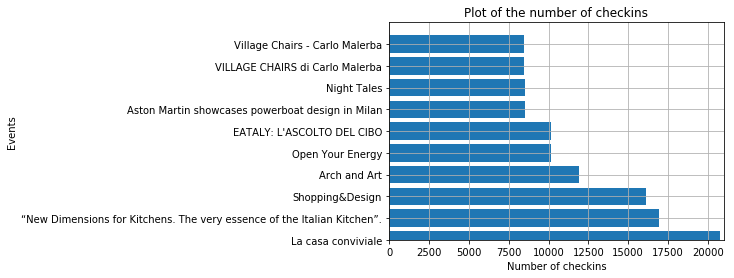

In [86]:
x = np.arange(10)
y = np.array(top_ten_checkins_count_df['checkins_count'])[:10]
plt.barh(x, y)
plt.xlabel('Number of checkins')
plt.ylabel('Events')
plt.yticks(np.arange(10), top_ten_events_for_checkins_titles.tolist())
plt.title('Plot of the number of checkins')
plt.axis([0, 21000, 0, 10])
plt.grid(b=True)
plt.show()

### User interest
Top-10 user interests.

In [87]:
matched_actions_agenda = pd.merge(agenda_users_count_df, events_users_count_df, on='event', indicator=True)
matched_actions_agenda.head()

,event,users_count_x,action,users_count_y,_merge
0,25,29,map,96,both
1,25,29,photos,96,both
2,25,29,share,3,both
3,26,90,map,192,both
4,26,90,photos,173,both


In [88]:
matched_actions_agenda['users_count_agenda'] = matched_actions_agenda['users_count_x']
matched_actions_agenda['users_count_actions'] = matched_actions_agenda['users_count_y']
del(matched_actions_agenda['users_count_x'])
del(matched_actions_agenda['users_count_y'])
del(matched_actions_agenda['action'])
del(matched_actions_agenda['_merge'])
matched_actions_agenda.head()

,event,users_count_agenda,users_count_actions
0,25,29,96
1,25,29,96
2,25,29,3
3,26,90,192
4,26,90,173


In [89]:
matched_actions_agenda['users_count'] = matched_actions_agenda['users_count_agenda'] + matched_actions_agenda['users_count_actions']
del(matched_actions_agenda['users_count_agenda'])
del(matched_actions_agenda['users_count_actions'])
matched_actions_agenda.head()

,event,users_count
0,25,125
1,25,125
2,25,32
3,26,282
4,26,263


In [90]:
matched_actions_agenda = matched_actions_agenda.groupby(['event']).sum().reset_index()
matched_actions_agenda.head()

,event,users_count
0,25,282
1,26,648
2,27,197
3,28,684
4,30,374


In [91]:
matched_actions_agenda = matched_actions_agenda.sort_values(by=['users_count'], ascending=False)
matched_actions_agenda.head()

,event,users_count
231,699,954
882,1419,734
660,1166,691
3,28,684
129,581,664


In [92]:
# select the title of the top-10 events
top_ten_interesting_events_for_users_count_df = matched_actions_agenda.iloc[:10]
top_ten_interesting_events_for_users_count_df['event'] = top_ten_interesting_events_for_users_count_df['event'].astype(str)
matched_events = pd.merge(top_ten_interesting_events_for_users_count_df, event_df_relevant_attributes, left_on='event', right_on='id', indicator=True)
matched_events

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event,users_count,id,title,_merge
0,699,954,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}",both
1,1419,734,1419,"{'it': 'Glow Of Life', 'en': 'Glow Of Life'}",both
2,1166,691,1166,{'it': '“50 MANGA CHAIRS” by Nendo: a collabor...,both
3,28,684,28,"{'it': 'Colors', 'en': 'Colors'}",both
4,581,664,581,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV...",both
5,26,648,26,"{'en': 'In-chiostro creativo | design, archite...",both
6,662,632,662,{'it': 'Lexus – An Encounter with Anticipation...,both
7,735,603,735,"{'it': 'HAY', 'en': 'HAY'}",both
8,1151,588,1151,{'it': 'The Restaurant by Caesarstone and Tom ...,both
9,825,585,825,"{'it': 'Vitra pop-up store', 'en': 'Vitra pop-...",both


In [93]:
top_ten_agenda_actions = matched_events.loc[:,['event', 'title']]
top_ten_agenda_actions.iloc[:10]

,event,title
0,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}"
1,1419,"{'it': 'Glow Of Life', 'en': 'Glow Of Life'}"
2,1166,{'it': '“50 MANGA CHAIRS” by Nendo: a collabor...
3,28,"{'it': 'Colors', 'en': 'Colors'}"
4,581,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV..."
5,26,"{'en': 'In-chiostro creativo | design, archite..."
6,662,{'it': 'Lexus – An Encounter with Anticipation...
7,735,"{'it': 'HAY', 'en': 'HAY'}"
8,1151,{'it': 'The Restaurant by Caesarstone and Tom ...
9,825,"{'it': 'Vitra pop-up store', 'en': 'Vitra pop-..."


In [94]:
titles_df = top_ten_agenda_actions['title'].apply(pd.Series)
top_ten_agenda_actions_titles = titles_df['it']
top_ten_agenda_actions_titles

0                                            CasaVitra
1                                         Glow Of Life
2    “50 MANGA CHAIRS” by Nendo: a collaboration wi...
3                                               Colors
4                                THE INVISIBLE KITCHEN
5    In-chiostro creativo | design, architettura e ...
6               Lexus – An Encounter with Anticipation
7                                                  HAY
8          The Restaurant by Caesarstone and Tom Dixon
9                                   Vitra pop-up store
Name: it, dtype: object

In [95]:
top_ten_agenda_actions['title'] = top_ten_agenda_actions_titles
top_ten_agenda_actions

,event,title
0,699,CasaVitra
1,1419,Glow Of Life
2,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
3,28,Colors
4,581,THE INVISIBLE KITCHEN
5,26,"In-chiostro creativo | design, architettura e ..."
6,662,Lexus – An Encounter with Anticipation
7,735,HAY
8,1151,The Restaurant by Caesarstone and Tom Dixon
9,825,Vitra pop-up store


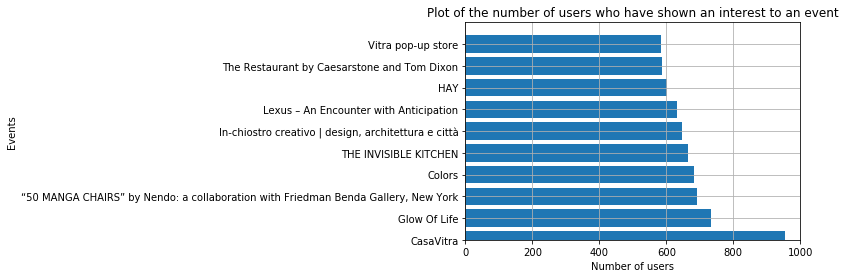

In [96]:
x = np.arange(10)
y = np.array(top_ten_interesting_events_for_users_count_df['users_count'])[:10]
plt.barh(x, y)
plt.xlabel('Number of users')
plt.ylabel('Events')
plt.yticks(np.arange(10), top_ten_agenda_actions_titles.tolist())
plt.title('Plot of the number of users who have shown an interest to an event')
plt.axis([0, 1000, 0, 10])
plt.grid(b=True)
plt.show()

#### Agenda
Top-10 events on agenda.

In [97]:
agenda_users_count_df = agenda_users_count_df.sort_values(by='users_count', ascending=False)
agenda_users_count_df.head()

,event,users_count
233,699,190
903,1419,181
199,662,149
130,581,142
359,825,139


In [98]:
# select the title of the top-10 events
top_ten_agenda_users_count_df = agenda_users_count_df.iloc[:10]
top_ten_agenda_users_count_df['event'] = top_ten_agenda_users_count_df['event'].astype(str)
matched_events = pd.merge(top_ten_agenda_users_count_df, event_df_relevant_attributes, left_on='event', right_on='id', indicator=True)
matched_events

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event,users_count,id,title,_merge
0,699,190,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}",both
1,1419,181,1419,"{'it': 'Glow Of Life', 'en': 'Glow Of Life'}",both
2,662,149,662,{'it': 'Lexus – An Encounter with Anticipation...,both
3,581,142,581,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV...",both
4,825,139,825,"{'it': 'Vitra pop-up store', 'en': 'Vitra pop-...",both
5,735,129,735,"{'it': 'HAY', 'en': 'HAY'}",both
6,1166,122,1166,{'it': '“50 MANGA CHAIRS” by Nendo: a collabor...,both
7,754,121,754,"{'it': 'KARTELL BY LAUFEN', 'en': 'KARTELL BY ...",both
8,28,121,28,"{'it': 'Colors', 'en': 'Colors'}",both
9,32,119,32,"{'it': 'THE TASTE OF COLORS', 'en': 'THE TASTE...",both


In [99]:
top_ten_agenda = matched_events.loc[:,['event', 'title']]
top_ten_agenda.iloc[:10]

,event,title
0,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}"
1,1419,"{'it': 'Glow Of Life', 'en': 'Glow Of Life'}"
2,662,{'it': 'Lexus – An Encounter with Anticipation...
3,581,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV..."
4,825,"{'it': 'Vitra pop-up store', 'en': 'Vitra pop-..."
5,735,"{'it': 'HAY', 'en': 'HAY'}"
6,1166,{'it': '“50 MANGA CHAIRS” by Nendo: a collabor...
7,754,"{'it': 'KARTELL BY LAUFEN', 'en': 'KARTELL BY ..."
8,28,"{'it': 'Colors', 'en': 'Colors'}"
9,32,"{'it': 'THE TASTE OF COLORS', 'en': 'THE TASTE..."


In [100]:
titles_df = top_ten_agenda['title'].apply(pd.Series)
top_ten_agenda_event_titles = titles_df['it']
top_ten_agenda_event_titles

0                                            CasaVitra
1                                         Glow Of Life
2               Lexus – An Encounter with Anticipation
3                                THE INVISIBLE KITCHEN
4                                   Vitra pop-up store
5                                                  HAY
6    “50 MANGA CHAIRS” by Nendo: a collaboration wi...
7                                    KARTELL BY LAUFEN
8                                               Colors
9                                  THE TASTE OF COLORS
Name: it, dtype: object

In [101]:
top_ten_agenda['title'] = top_ten_agenda_event_titles
top_ten_agenda

,event,title
0,699,CasaVitra
1,1419,Glow Of Life
2,662,Lexus – An Encounter with Anticipation
3,581,THE INVISIBLE KITCHEN
4,825,Vitra pop-up store
5,735,HAY
6,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
7,754,KARTELL BY LAUFEN
8,28,Colors
9,32,THE TASTE OF COLORS


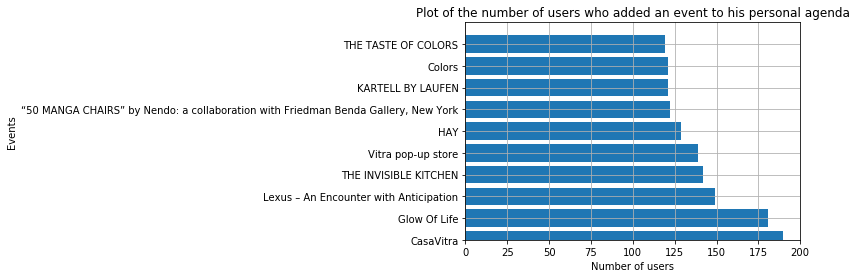

In [102]:
x = np.arange(10)
y = np.array(top_ten_agenda_users_count_df['users_count'])[:10]
plt.barh(x, y)
plt.xlabel('Number of users')
plt.ylabel('Events')
plt.yticks(np.arange(10), top_ten_agenda_event_titles.tolist())
plt.title('Plot of the number of users who added an event to his personal agenda')
plt.axis([0, 200, 0, 10])
plt.grid(b=True)
plt.show()

### Map interest

In [103]:
# select the title of the top-10 events
top_ten_map_users_count_df = events_map_count_df.iloc[:10]
top_ten_map_users_count_df['event'] = top_ten_map_users_count_df['event'].astype(str)
matched_events = pd.merge(top_ten_map_users_count_df, event_df_relevant_attributes, left_on='event', right_on='id', indicator=True)
matched_events

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event,action,users_count,id,title,_merge
0,1166,map,287,1166,{'it': '“50 MANGA CHAIRS” by Nendo: a collabor...,both
1,699,map,270,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}",both
2,1648,map,259,1648,"{'it': 'Spazio, luce e ombra con Sou Fujimoto ...",both
3,1481,map,253,1481,"{'it': 'Raw Edges, ""Herringbones""', 'en': 'Raw...",both
4,1643,map,221,1643,"{'it': 'The nature of motion', 'en': 'The natu...",both
5,1151,map,193,1151,{'it': 'The Restaurant by Caesarstone and Tom ...,both
6,26,map,192,26,"{'en': 'In-chiostro creativo | design, archite...",both
7,735,map,186,735,"{'it': 'HAY', 'en': 'HAY'}",both
8,1154,map,139,1154,{'it': 'The Design of Words by Calligraphy Mas...,both
9,811,map,134,811,"{'it': 'space&interiors', 'en': 'space&interio...",both


In [104]:
top_ten_map = matched_events.loc[:,['event', 'title']]
top_ten_map.iloc[:10]

,event,title
0,1166,{'it': '“50 MANGA CHAIRS” by Nendo: a collabor...
1,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}"
2,1648,"{'it': 'Spazio, luce e ombra con Sou Fujimoto ..."
3,1481,"{'it': 'Raw Edges, ""Herringbones""', 'en': 'Raw..."
4,1643,"{'it': 'The nature of motion', 'en': 'The natu..."
5,1151,{'it': 'The Restaurant by Caesarstone and Tom ...
6,26,"{'en': 'In-chiostro creativo | design, archite..."
7,735,"{'it': 'HAY', 'en': 'HAY'}"
8,1154,{'it': 'The Design of Words by Calligraphy Mas...
9,811,"{'it': 'space&interiors', 'en': 'space&interio..."


In [105]:
titles_df = top_ten_map['title'].apply(pd.Series)
top_ten_map_event_titles = titles_df['it']
top_ten_map_event_titles

0    “50 MANGA CHAIRS” by Nendo: a collaboration wi...
1                                            CasaVitra
2        Spazio, luce e ombra con Sou Fujimoto per COS
3                            Raw Edges, "Herringbones"
4                                 The nature of motion
5          The Restaurant by Caesarstone and Tom Dixon
6    In-chiostro creativo | design, architettura e ...
7                                                  HAY
8           The Design of Words by Calligraphy Masters
9                                      space&interiors
Name: it, dtype: object

In [106]:
top_ten_map['title'] = top_ten_map_event_titles
top_ten_map

,event,title
0,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
1,699,CasaVitra
2,1648,"Spazio, luce e ombra con Sou Fujimoto per COS"
3,1481,"Raw Edges, ""Herringbones"""
4,1643,The nature of motion
5,1151,The Restaurant by Caesarstone and Tom Dixon
6,26,"In-chiostro creativo | design, architettura e ..."
7,735,HAY
8,1154,The Design of Words by Calligraphy Masters
9,811,space&interiors


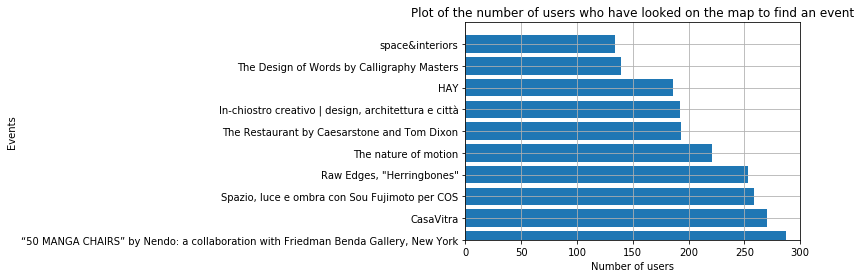

In [107]:
x = np.arange(10)
y = np.array(top_ten_map_users_count_df['users_count'])[:10]
plt.barh(x, y)
plt.xlabel('Number of users')
plt.ylabel('Events')
plt.yticks(np.arange(10), top_ten_map_event_titles.tolist())
plt.title('Plot of the number of users who have looked on the map to find an event')
plt.axis([0, 300, 0, 10])
plt.grid(b=True)
plt.show()

#### Photos interest
Top-10 events for photos.

In [108]:
# select the title of the top-10 events
top_ten_photos_users_count_df = events_photos_count_df.iloc[:10]
top_ten_photos_users_count_df['event'] = top_ten_photos_users_count_df['event'].astype(str)
matched_events = pd.merge(top_ten_photos_users_count_df, event_df_relevant_attributes, left_on='event', right_on='id', indicator=True)
matched_events

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event,action,users_count,id,title,_merge
0,28,photos,187,28,"{'it': 'Colors', 'en': 'Colors'}",both
1,26,photos,173,26,"{'en': 'In-chiostro creativo | design, archite...",both
2,581,photos,130,581,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV...",both
3,699,photos,100,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}",both
4,758,photos,100,758,"{'it': '“KŪKAN” The Invention of Space', 'en'...",both
5,1419,photos,99,1419,"{'it': 'Glow Of Life', 'en': 'Glow Of Life'}",both
6,662,photos,98,662,{'it': 'Lexus – An Encounter with Anticipation...,both
7,25,photos,96,25,"{'it': 'Noni', 'en': 'Noni'}",both
8,30,photos,93,30,"{'it': 'Kartell by Laufen', 'en': 'Kartell by ...",both
9,1643,photos,91,1643,"{'it': 'The nature of motion', 'en': 'The natu...",both


In [109]:
top_ten_photos = matched_events.loc[:,['event', 'title']]
top_ten_photos.iloc[:10]

,event,title
0,28,"{'it': 'Colors', 'en': 'Colors'}"
1,26,"{'en': 'In-chiostro creativo | design, archite..."
2,581,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV..."
3,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}"
4,758,"{'it': '“KŪKAN” The Invention of Space', 'en'..."
5,1419,"{'it': 'Glow Of Life', 'en': 'Glow Of Life'}"
6,662,{'it': 'Lexus – An Encounter with Anticipation...
7,25,"{'it': 'Noni', 'en': 'Noni'}"
8,30,"{'it': 'Kartell by Laufen', 'en': 'Kartell by ..."
9,1643,"{'it': 'The nature of motion', 'en': 'The natu..."


In [110]:
titles_df = top_ten_photos['title'].apply(pd.Series)
top_ten_photos_event_titles = titles_df['it']
top_ten_photos_event_titles

0                                               Colors
1    In-chiostro creativo | design, architettura e ...
2                                THE INVISIBLE KITCHEN
3                                            CasaVitra
4                      “KŪKAN”  The Invention of Space
5                                         Glow Of Life
6               Lexus – An Encounter with Anticipation
7                                                 Noni
8                                    Kartell by Laufen
9                                 The nature of motion
Name: it, dtype: object

In [111]:
top_ten_photos['title'] = top_ten_photos_event_titles
top_ten_photos

,event,title
0,28,Colors
1,26,"In-chiostro creativo | design, architettura e ..."
2,581,THE INVISIBLE KITCHEN
3,699,CasaVitra
4,758,“KŪKAN” The Invention of Space
5,1419,Glow Of Life
6,662,Lexus – An Encounter with Anticipation
7,25,Noni
8,30,Kartell by Laufen
9,1643,The nature of motion


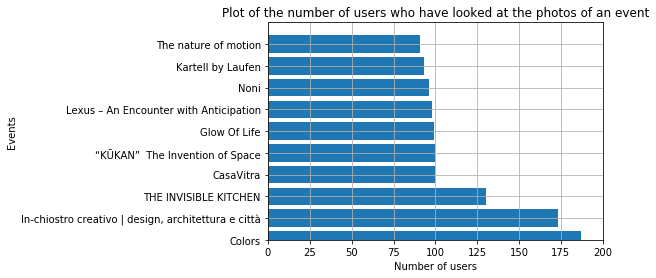

In [112]:
x = np.arange(10)
y = np.array(top_ten_photos_users_count_df['users_count'])[:10]
plt.barh(x, y)
plt.xlabel('Number of users')
plt.ylabel('Events')
plt.yticks(np.arange(10), top_ten_photos_event_titles.tolist())
plt.title('Plot of the number of users who have looked at the photos of an event')
plt.axis([0, 200, 0, 10])
plt.grid(b=True)
plt.show()

#### Share interest
Top-10 events most shared.

In [113]:
# select the title of the top-10 events
top_ten_share_users_count_df = events_share_count_df.iloc[:10]
top_ten_share_users_count_df['event'] = top_ten_share_users_count_df['event'].astype(str)
matched_events = pd.merge(top_ten_share_users_count_df, event_df_relevant_attributes, left_on='event', right_on='id', indicator=True)
matched_events

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event,action,users_count,id,title,_merge
0,941,share,23,941,{'it': 'Back Ahead - New Austrian Design Persp...,both
1,985,share,21,985,{'it': 'DOUTDESign Headquarter eventi daybyday...,both
2,758,share,19,758,"{'it': '“KŪKAN” The Invention of Space', 'en'...",both
3,942,share,18,942,"{'it': 'Data Orchestra', 'en': 'Data Orchestra'}",both
4,28,share,18,28,"{'it': 'Colors', 'en': 'Colors'}",both
5,32,share,14,32,"{'it': 'THE TASTE OF COLORS', 'en': 'THE TASTE...",both
6,581,share,14,581,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV...",both
7,699,share,14,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}",both
8,1526,share,13,1526,"{'it': 'Imagine New Days', 'en': 'Imagine New ...",both
9,662,share,13,662,{'it': 'Lexus – An Encounter with Anticipation...,both


In [114]:
top_ten_share = matched_events.loc[:,['event', 'title']]
top_ten_share.iloc[:10]

,event,title
0,941,{'it': 'Back Ahead - New Austrian Design Persp...
1,985,{'it': 'DOUTDESign Headquarter eventi daybyday...
2,758,"{'it': '“KŪKAN” The Invention of Space', 'en'..."
3,942,"{'it': 'Data Orchestra', 'en': 'Data Orchestra'}"
4,28,"{'it': 'Colors', 'en': 'Colors'}"
5,32,"{'it': 'THE TASTE OF COLORS', 'en': 'THE TASTE..."
6,581,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV..."
7,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}"
8,1526,"{'it': 'Imagine New Days', 'en': 'Imagine New ..."
9,662,{'it': 'Lexus – An Encounter with Anticipation...


In [115]:
titles_df = top_ten_share['title'].apply(pd.Series)
top_ten_share_event_titles = titles_df['it']
top_ten_share_event_titles

0    Back Ahead - New Austrian Design Perspectives
1           DOUTDESign Headquarter eventi daybyday
2                  “KŪKAN”  The Invention of Space
3                                   Data Orchestra
4                                           Colors
5                              THE TASTE OF COLORS
6                            THE INVISIBLE KITCHEN
7                                        CasaVitra
8                                 Imagine New Days
9           Lexus – An Encounter with Anticipation
Name: it, dtype: object

In [116]:
top_ten_share['title'] = top_ten_share_event_titles
top_ten_share

,event,title
0,941,Back Ahead - New Austrian Design Perspectives
1,985,DOUTDESign Headquarter eventi daybyday
2,758,“KŪKAN” The Invention of Space
3,942,Data Orchestra
4,28,Colors
5,32,THE TASTE OF COLORS
6,581,THE INVISIBLE KITCHEN
7,699,CasaVitra
8,1526,Imagine New Days
9,662,Lexus – An Encounter with Anticipation


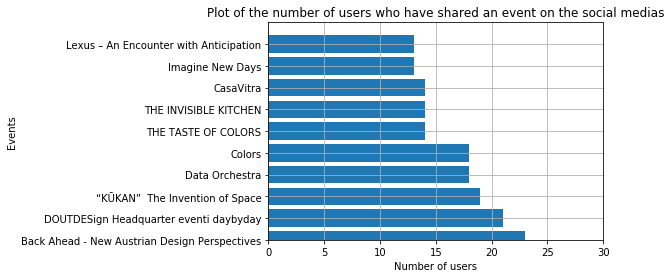

In [117]:
x = np.arange(10)
y = np.array(top_ten_share_users_count_df['users_count'])[:10]
plt.barh(x, y)
plt.xlabel('Number of users')
plt.ylabel('Events')
plt.yticks(np.arange(10), top_ten_share_event_titles.tolist())
plt.title('Plot of the number of users who have shared an event on the social medias')
plt.axis([0, 30, 0, 10])
plt.grid(b=True)
plt.show()

### Phone activities

In [118]:
number_of_phone_activities_per_event_df = phone_activities_during_event_df.loc[:,['event_id', 'gender', 'agerange', 'activity', 'type']]

# aggregate by squareid, sex, age range
number_of_phone_activities_per_event_df = number_of_phone_activities_per_event_df.groupby(['event_id', 'gender', 'agerange']).sum().reset_index()
number_of_phone_activities_per_event_df.head()

,event_id,gender,agerange,activity
0,1002,F,[31-40],15
1,1007,F,[41-50],211
2,1024,M,[41-50],51
3,1028,F,[31-40],18
4,1093,M,[18-30],1


In [119]:
number_of_phone_activities_per_event_df = number_of_phone_activities_per_event_df.sort_values(by='activity', ascending=False)
number_of_phone_activities_per_event_df.head()

,event_id,gender,agerange,activity
14,1344,F,[18-30],679
15,1374,M,[>60],639
13,1343,F,[18-30],590
36,605,M,[18-30],521
38,673,F,[18-30],466


In [120]:
# select the title of the top-10 events
top_ten_phone_activities_count_df = number_of_phone_activities_per_event_df.iloc[:10]
top_ten_phone_activities_count_df['event_id'] = top_ten_phone_activities_count_df['event_id'].astype(str)
event_df_relevant_attributes = event_df.loc[:,['id','titolo']]
event_df_relevant_attributes['title'] = event_df_relevant_attributes['titolo']
del(event_df_relevant_attributes['titolo'])
matched_events = pd.merge(top_ten_phone_activities_count_df, event_df_relevant_attributes, left_on='event_id', right_on='id', indicator=True)
matched_events

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event_id,gender,agerange,activity,id,title,_merge
0,1344,F,[18-30],679,1344,"{'it': 'FLORA ET DECORA', 'en': 'FLORA ET DECO...",both
1,1374,M,[>60],639,1374,{'it': 'Open Design Italia 2016 - The Challeng...,both
2,1343,F,[18-30],590,1343,{'it': 'Visite guidate in ZONA 13-15-16-17 Apr...,both
3,605,M,[18-30],521,605,"{'it': 'Atelier by Republic of Fritz Hansen', ...",both
4,673,F,[18-30],466,673,"{'it': 'NEVER STOP PLAYING TOGETHER', 'en': 'N...",both
5,1613,M,[18-30],465,1613,{'en': 'Design and fashion: sample sale of thr...,both
6,835,M,[51-60],384,835,"{'en': 'Lights & shadows', 'it': 'Luci & ombre'}",both
7,1607,M,[18-30],368,1607,{'it': 'terrae altrove italian experience cong...,both
8,1573,M,[31-40],331,1573,"{'it': 'NEVER STOP EATING SOCIAL', 'en': 'NEVE...",both
9,1622,M,[41-50],319,1622,"{'it': 'Il Simposio de ""Il Collirio"" - Milano ...",both


In [121]:
top_ten_phone_activities = matched_events.loc[:,['event_id', 'title']]
top_ten_phone_activities.iloc[:10]

,event_id,title
0,1344,"{'it': 'FLORA ET DECORA', 'en': 'FLORA ET DECO..."
1,1374,{'it': 'Open Design Italia 2016 - The Challeng...
2,1343,{'it': 'Visite guidate in ZONA 13-15-16-17 Apr...
3,605,"{'it': 'Atelier by Republic of Fritz Hansen', ..."
4,673,"{'it': 'NEVER STOP PLAYING TOGETHER', 'en': 'N..."
5,1613,{'en': 'Design and fashion: sample sale of thr...
6,835,"{'en': 'Lights & shadows', 'it': 'Luci & ombre'}"
7,1607,{'it': 'terrae altrove italian experience cong...
8,1573,"{'it': 'NEVER STOP EATING SOCIAL', 'en': 'NEVE..."
9,1622,"{'it': 'Il Simposio de ""Il Collirio"" - Milano ..."


In [122]:
titles_df = top_ten_phone_activities['title'].apply(pd.Series)
top_ten_events_for_phone_activities_titles = titles_df['it']
top_ten_events_for_phone_activities_titles

0                                      FLORA ET DECORA
1              Open Design Italia 2016 - The Challenge
2            Visite guidate in ZONA 13-15-16-17 Aprile
3                  Atelier by Republic of Fritz Hansen
4                          NEVER STOP PLAYING TOGETHER
5    Design e moda: sample sale di tre brand del lu...
6                                         Luci & ombre
7    terrae altrove italian experience congli artis...
8                             NEVER STOP EATING SOCIAL
9    Il Simposio de "Il Collirio" - Milano Fuori da...
Name: it, dtype: object

In [123]:
top_ten_phone_activities['title'] = top_ten_events_for_phone_activities_titles
top_ten_phone_activities

,event_id,title
0,1344,FLORA ET DECORA
1,1374,Open Design Italia 2016 - The Challenge
2,1343,Visite guidate in ZONA 13-15-16-17 Aprile
3,605,Atelier by Republic of Fritz Hansen
4,673,NEVER STOP PLAYING TOGETHER
5,1613,Design e moda: sample sale di tre brand del lu...
6,835,Luci & ombre
7,1607,terrae altrove italian experience congli artis...
8,1573,NEVER STOP EATING SOCIAL
9,1622,"Il Simposio de ""Il Collirio"" - Milano Fuori da..."


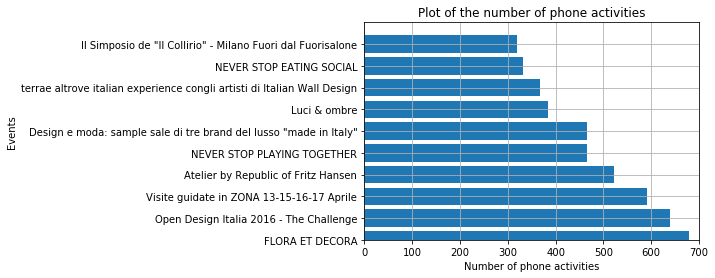

In [124]:
x = np.arange(10)
y = np.array(top_ten_phone_activities_count_df['activity'])[:10]
plt.barh(x, y)
plt.xlabel('Number of phone activities')
plt.ylabel('Events')
plt.yticks(np.arange(10), top_ten_events_for_phone_activities_titles.tolist())
plt.title('Plot of the number of phone activities')
plt.axis([0, 700, 0, 10])
plt.grid(b=True)
plt.show()

#### Young phone activities

In [125]:
number_of_young_phone_activities_per_event_df = number_of_phone_activities_per_event_df[(number_of_phone_activities_per_event_df['agerange'] == '[18-30]') | (number_of_phone_activities_per_event_df['agerange'] == '[<18]') | (number_of_phone_activities_per_event_df['agerange'] == '[31-40]')]
number_of_young_phone_activities_per_event_df.head()

,event_id,gender,agerange,activity
14,1344,F,[18-30],679
13,1343,F,[18-30],590
36,605,M,[18-30],521
38,673,F,[18-30],466
27,1613,M,[18-30],465


In [126]:
# select the title of the top-10 events
top_ten_young_phone_activities_count_df = number_of_young_phone_activities_per_event_df.iloc[:10]
top_ten_young_phone_activities_count_df['event_id'] = top_ten_young_phone_activities_count_df['event_id'].astype(str)
matched_events = pd.merge(top_ten_young_phone_activities_count_df, event_df_relevant_attributes, left_on='event_id', right_on='id', indicator=True)
matched_events

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event_id,gender,agerange,activity,id,title,_merge
0,1344,F,[18-30],679,1344,"{'it': 'FLORA ET DECORA', 'en': 'FLORA ET DECO...",both
1,1343,F,[18-30],590,1343,{'it': 'Visite guidate in ZONA 13-15-16-17 Apr...,both
2,605,M,[18-30],521,605,"{'it': 'Atelier by Republic of Fritz Hansen', ...",both
3,673,F,[18-30],466,673,"{'it': 'NEVER STOP PLAYING TOGETHER', 'en': 'N...",both
4,1613,M,[18-30],465,1613,{'en': 'Design and fashion: sample sale of thr...,both
5,1607,M,[18-30],368,1607,{'it': 'terrae altrove italian experience cong...,both
6,1573,M,[31-40],331,1573,"{'it': 'NEVER STOP EATING SOCIAL', 'en': 'NEVE...",both
7,855,M,[31-40],260,855,"{'it': 'DEKTONHENGE by Apparatu', 'en': 'DEKTO...",both
8,933,F,[18-30],246,933,{'it': 'Bixio 27 - WAXMAX & Studio Picone Roma...,both
9,997,F,[31-40],223,997,"{'it': 'MONEY BOX', 'en': 'MONEY BOX'}",both


In [127]:
top_ten_young_phone_activities = matched_events.loc[:,['event_id', 'title']]
top_ten_young_phone_activities

,event_id,title
0,1344,"{'it': 'FLORA ET DECORA', 'en': 'FLORA ET DECO..."
1,1343,{'it': 'Visite guidate in ZONA 13-15-16-17 Apr...
2,605,"{'it': 'Atelier by Republic of Fritz Hansen', ..."
3,673,"{'it': 'NEVER STOP PLAYING TOGETHER', 'en': 'N..."
4,1613,{'en': 'Design and fashion: sample sale of thr...
5,1607,{'it': 'terrae altrove italian experience cong...
6,1573,"{'it': 'NEVER STOP EATING SOCIAL', 'en': 'NEVE..."
7,855,"{'it': 'DEKTONHENGE by Apparatu', 'en': 'DEKTO..."
8,933,{'it': 'Bixio 27 - WAXMAX & Studio Picone Roma...
9,997,"{'it': 'MONEY BOX', 'en': 'MONEY BOX'}"


In [128]:
titles_df = top_ten_young_phone_activities['title'].apply(pd.Series)
top_ten_young_events_for_phone_activities_titles = titles_df['it']
top_ten_young_events_for_phone_activities_titles

0                                      FLORA ET DECORA
1            Visite guidate in ZONA 13-15-16-17 Aprile
2                  Atelier by Republic of Fritz Hansen
3                          NEVER STOP PLAYING TOGETHER
4    Design e moda: sample sale di tre brand del lu...
5    terrae altrove italian experience congli artis...
6                             NEVER STOP EATING SOCIAL
7                              DEKTONHENGE by Apparatu
8               Bixio 27 - WAXMAX & Studio Picone Roma
9                                            MONEY BOX
Name: it, dtype: object

In [129]:
top_ten_young_phone_activities['title'] = top_ten_young_events_for_phone_activities_titles
top_ten_young_phone_activities

,event_id,title
0,1344,FLORA ET DECORA
1,1343,Visite guidate in ZONA 13-15-16-17 Aprile
2,605,Atelier by Republic of Fritz Hansen
3,673,NEVER STOP PLAYING TOGETHER
4,1613,Design e moda: sample sale di tre brand del lu...
5,1607,terrae altrove italian experience congli artis...
6,1573,NEVER STOP EATING SOCIAL
7,855,DEKTONHENGE by Apparatu
8,933,Bixio 27 - WAXMAX & Studio Picone Roma
9,997,MONEY BOX


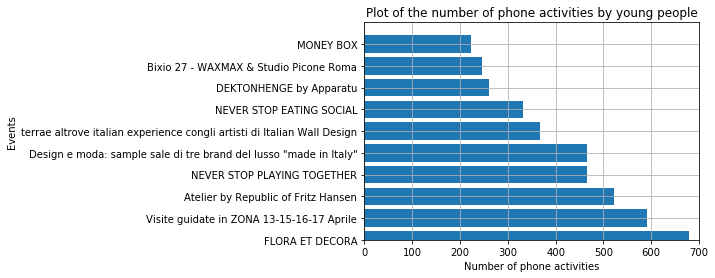

In [130]:
x = np.arange(10)
y = np.array(top_ten_young_phone_activities_count_df['activity'])[:10]
plt.barh(x, y)
plt.xlabel('Number of phone activities')
plt.ylabel('Events')
plt.yticks(np.arange(10), top_ten_young_events_for_phone_activities_titles.tolist())
plt.title('Plot of the number of phone activities by young people')
plt.axis([0, 700, 0, 10])
plt.grid(b=True)
plt.show()

#### Senior phone activities

In [131]:
number_of_senior_phone_activities_per_event_df = number_of_phone_activities_per_event_df[(number_of_phone_activities_per_event_df['agerange'] == '[41-50]') | (number_of_phone_activities_per_event_df['agerange'] == '[51-60]') | (number_of_phone_activities_per_event_df['agerange'] == '[>60]')]
number_of_senior_phone_activities_per_event_df.head()

,event_id,gender,agerange,activity
15,1374,M,[>60],639
39,835,M,[51-60],384
29,1622,M,[41-50],319
30,1631,F,[41-50],298
8,1121,F,[51-60],227


In [132]:
# select the title of the top-10 events
top_ten_senior_phone_activities_count_df = number_of_senior_phone_activities_per_event_df.iloc[:10]
top_ten_senior_phone_activities_count_df['event_id'] = top_ten_senior_phone_activities_count_df['event_id'].astype(str)
matched_events = pd.merge(top_ten_senior_phone_activities_count_df, event_df_relevant_attributes, left_on='event_id', right_on='id', indicator=True)
matched_events

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event_id,gender,agerange,activity,id,title,_merge
0,1374,M,[>60],639,1374,{'it': 'Open Design Italia 2016 - The Challeng...,both
1,835,M,[51-60],384,835,"{'en': 'Lights & shadows', 'it': 'Luci & ombre'}",both
2,1622,M,[41-50],319,1622,"{'it': 'Il Simposio de ""Il Collirio"" - Milano ...",both
3,1631,F,[41-50],298,1631,"{'it': 'HANDS ON DESIGN', 'en': 'HANDS ON DESI...",both
4,1121,F,[51-60],227,1121,{'it': 'Record store day 2016 | Weekend Offend...,both
5,1007,F,[41-50],211,1007,"{'it': 'Josif Design', 'en': 'Josif Design'}",both
6,857,F,[41-50],183,857,"{'it': 'IO SONO IL FUOCO', 'en': 'THE FIRE IT'...",both
7,1604,F,[41-50],123,1604,"{'it': '¡Puro Sabor Español!', 'en': '¡Puro Sa...",both
8,1095,M,[41-50],97,1095,"{'en': 'Joy is a serious thing.', 'it': 'la Gi...",both
9,1540,F,[51-60],82,1540,"{'it': 'FUORI SALONE - Cîroc Official Party', ...",both


In [133]:
top_ten_senior_phone_activities = matched_events.loc[:,['event_id', 'title']]
top_ten_senior_phone_activities

,event_id,title
0,1374,{'it': 'Open Design Italia 2016 - The Challeng...
1,835,"{'en': 'Lights & shadows', 'it': 'Luci & ombre'}"
2,1622,"{'it': 'Il Simposio de ""Il Collirio"" - Milano ..."
3,1631,"{'it': 'HANDS ON DESIGN', 'en': 'HANDS ON DESI..."
4,1121,{'it': 'Record store day 2016 | Weekend Offend...
5,1007,"{'it': 'Josif Design', 'en': 'Josif Design'}"
6,857,"{'it': 'IO SONO IL FUOCO', 'en': 'THE FIRE IT'..."
7,1604,"{'it': '¡Puro Sabor Español!', 'en': '¡Puro Sa..."
8,1095,"{'en': 'Joy is a serious thing.', 'it': 'la Gi..."
9,1540,"{'it': 'FUORI SALONE - Cîroc Official Party', ..."


In [134]:
titles_df = top_ten_senior_phone_activities['title'].apply(pd.Series)
top_ten_senior_events_for_phone_activities_titles = titles_df['it']
top_ten_senior_events_for_phone_activities_titles

0              Open Design Italia 2016 - The Challenge
1                                         Luci & ombre
2    Il Simposio de "Il Collirio" - Milano Fuori da...
3                                      HANDS ON DESIGN
4             Record store day 2016 | Weekend Offender
5                                         Josif Design
6                                     IO SONO IL FUOCO
7                                 ¡Puro Sabor Español!
8                           la Gioia é una cosa seria.
9                  FUORI SALONE - Cîroc Official Party
Name: it, dtype: object

In [135]:
top_ten_senior_phone_activities['title'] = top_ten_senior_events_for_phone_activities_titles
top_ten_senior_phone_activities

,event_id,title
0,1374,Open Design Italia 2016 - The Challenge
1,835,Luci & ombre
2,1622,"Il Simposio de ""Il Collirio"" - Milano Fuori da..."
3,1631,HANDS ON DESIGN
4,1121,Record store day 2016 | Weekend Offender
5,1007,Josif Design
6,857,IO SONO IL FUOCO
7,1604,¡Puro Sabor Español!
8,1095,la Gioia é una cosa seria.
9,1540,FUORI SALONE - Cîroc Official Party


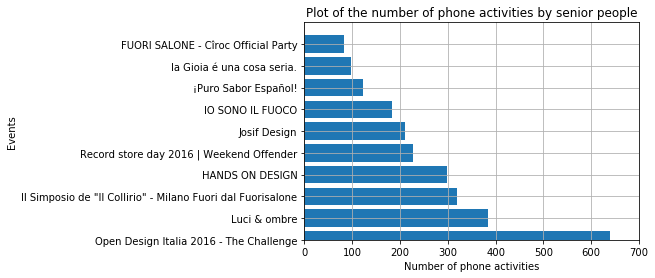

In [136]:
x = np.arange(10)
y = np.array(top_ten_senior_phone_activities_count_df['activity'])[:10]
plt.barh(x, y)
plt.xlabel('Number of phone activities')
plt.ylabel('Events')
plt.yticks(np.arange(10), top_ten_senior_events_for_phone_activities_titles.tolist())
plt.title('Plot of the number of phone activities by senior people')
plt.axis([0, 700, 0, 10])
plt.grid(b=True)
plt.show()

#### Male phone activities

In [137]:
number_of_male_phone_activities_per_event_df = number_of_phone_activities_per_event_df[number_of_phone_activities_per_event_df['gender'] == 'M']
number_of_male_phone_activities_per_event_df

,event_id,gender,agerange,activity
15,1374,M,[>60],639
36,605,M,[18-30],521
27,1613,M,[18-30],465
39,835,M,[51-60],384
24,1607,M,[18-30],368
21,1573,M,[31-40],331
29,1622,M,[41-50],319
42,855,M,[31-40],260
6,1108,M,[31-40],187
48,939,M,[31-40],136


In [138]:
# select the title of the top-10 events
top_ten_male_phone_activities_count_df = number_of_male_phone_activities_per_event_df.iloc[:10]
top_ten_male_phone_activities_count_df['event_id'] = top_ten_male_phone_activities_count_df['event_id'].astype(str)
matched_events = pd.merge(top_ten_male_phone_activities_count_df, event_df_relevant_attributes, left_on='event_id', right_on='id', indicator=True)
matched_events

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event_id,gender,agerange,activity,id,title,_merge
0,1374,M,[>60],639,1374,{'it': 'Open Design Italia 2016 - The Challeng...,both
1,605,M,[18-30],521,605,"{'it': 'Atelier by Republic of Fritz Hansen', ...",both
2,1613,M,[18-30],465,1613,{'en': 'Design and fashion: sample sale of thr...,both
3,835,M,[51-60],384,835,"{'en': 'Lights & shadows', 'it': 'Luci & ombre'}",both
4,1607,M,[18-30],368,1607,{'it': 'terrae altrove italian experience cong...,both
5,1573,M,[31-40],331,1573,"{'it': 'NEVER STOP EATING SOCIAL', 'en': 'NEVE...",both
6,1622,M,[41-50],319,1622,"{'it': 'Il Simposio de ""Il Collirio"" - Milano ...",both
7,855,M,[31-40],260,855,"{'it': 'DEKTONHENGE by Apparatu', 'en': 'DEKTO...",both
8,1108,M,[31-40],187,1108,{'it': 'l'immagine dell'architettura e l'archi...,both
9,939,M,[31-40],136,939,"{'it': 'Mimade_on_design', 'en': 'Mimade_on_de...",both


In [139]:
top_ten_male_phone_activities = matched_events.loc[:,['event_id', 'title']]
top_ten_male_phone_activities

,event_id,title
0,1374,{'it': 'Open Design Italia 2016 - The Challeng...
1,605,"{'it': 'Atelier by Republic of Fritz Hansen', ..."
2,1613,{'en': 'Design and fashion: sample sale of thr...
3,835,"{'en': 'Lights & shadows', 'it': 'Luci & ombre'}"
4,1607,{'it': 'terrae altrove italian experience cong...
5,1573,"{'it': 'NEVER STOP EATING SOCIAL', 'en': 'NEVE..."
6,1622,"{'it': 'Il Simposio de ""Il Collirio"" - Milano ..."
7,855,"{'it': 'DEKTONHENGE by Apparatu', 'en': 'DEKTO..."
8,1108,{'it': 'l'immagine dell'architettura e l'archi...
9,939,"{'it': 'Mimade_on_design', 'en': 'Mimade_on_de..."


In [140]:
titles_df = top_ten_male_phone_activities['title'].apply(pd.Series)
top_ten_male_events_for_phone_activities_titles = titles_df['it']
top_ten_male_events_for_phone_activities_titles

0              Open Design Italia 2016 - The Challenge
1                  Atelier by Republic of Fritz Hansen
2    Design e moda: sample sale di tre brand del lu...
3                                         Luci & ombre
4    terrae altrove italian experience congli artis...
5                             NEVER STOP EATING SOCIAL
6    Il Simposio de "Il Collirio" - Milano Fuori da...
7                              DEKTONHENGE by Apparatu
8    l'immagine dell'architettura e l'architettura ...
9                                     Mimade_on_design
Name: it, dtype: object

In [141]:
top_ten_male_phone_activities['title'] = top_ten_male_events_for_phone_activities_titles
top_ten_male_phone_activities

,event_id,title
0,1374,Open Design Italia 2016 - The Challenge
1,605,Atelier by Republic of Fritz Hansen
2,1613,Design e moda: sample sale di tre brand del lu...
3,835,Luci & ombre
4,1607,terrae altrove italian experience congli artis...
5,1573,NEVER STOP EATING SOCIAL
6,1622,"Il Simposio de ""Il Collirio"" - Milano Fuori da..."
7,855,DEKTONHENGE by Apparatu
8,1108,l'immagine dell'architettura e l'architettura ...
9,939,Mimade_on_design


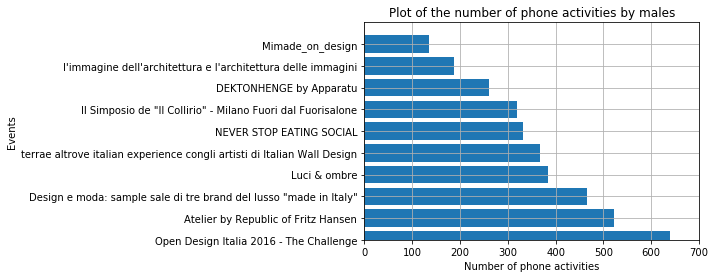

In [142]:
x = np.arange(10)
y = np.array(top_ten_male_phone_activities_count_df['activity'])[:10]
plt.barh(x, y)
plt.xlabel('Number of phone activities')
plt.ylabel('Events')
plt.yticks(np.arange(10), top_ten_male_events_for_phone_activities_titles.tolist())
plt.title('Plot of the number of phone activities by males')
plt.axis([0, 700, 0, 10])
plt.grid(b=True)
plt.show()

#### Phone activities by females

In [143]:
number_of_female_phone_activities_per_event_df = number_of_phone_activities_per_event_df[number_of_phone_activities_per_event_df['gender'] == 'F']
number_of_female_phone_activities_per_event_df.head()

,event_id,gender,agerange,activity
14,1344,F,[18-30],679
13,1343,F,[18-30],590
38,673,F,[18-30],466
30,1631,F,[41-50],298
47,933,F,[18-30],246


In [144]:
# select the title of the top-10 events
top_ten_female_phone_activities_count_df = number_of_female_phone_activities_per_event_df.iloc[:10]
top_ten_female_phone_activities_count_df['event_id'] = top_ten_female_phone_activities_count_df['event_id'].astype(str)
matched_events = pd.merge(top_ten_female_phone_activities_count_df, event_df_relevant_attributes, left_on='event_id', right_on='id', indicator=True)
matched_events

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event_id,gender,agerange,activity,id,title,_merge
0,1344,F,[18-30],679,1344,"{'it': 'FLORA ET DECORA', 'en': 'FLORA ET DECO...",both
1,1343,F,[18-30],590,1343,{'it': 'Visite guidate in ZONA 13-15-16-17 Apr...,both
2,673,F,[18-30],466,673,"{'it': 'NEVER STOP PLAYING TOGETHER', 'en': 'N...",both
3,1631,F,[41-50],298,1631,"{'it': 'HANDS ON DESIGN', 'en': 'HANDS ON DESI...",both
4,933,F,[18-30],246,933,{'it': 'Bixio 27 - WAXMAX & Studio Picone Roma...,both
5,1121,F,[51-60],227,1121,{'it': 'Record store day 2016 | Weekend Offend...,both
6,997,F,[31-40],223,997,"{'it': 'MONEY BOX', 'en': 'MONEY BOX'}",both
7,1007,F,[41-50],211,1007,"{'it': 'Josif Design', 'en': 'Josif Design'}",both
8,857,F,[41-50],183,857,"{'it': 'IO SONO IL FUOCO', 'en': 'THE FIRE IT'...",both
9,1399,F,[31-40],158,1399,"{'it': 'Fiber street art', 'en': 'Fiber street...",both


In [145]:
top_ten_female_phone_activities = matched_events.loc[:,['event_id', 'title']]
top_ten_female_phone_activities

,event_id,title
0,1344,"{'it': 'FLORA ET DECORA', 'en': 'FLORA ET DECO..."
1,1343,{'it': 'Visite guidate in ZONA 13-15-16-17 Apr...
2,673,"{'it': 'NEVER STOP PLAYING TOGETHER', 'en': 'N..."
3,1631,"{'it': 'HANDS ON DESIGN', 'en': 'HANDS ON DESI..."
4,933,{'it': 'Bixio 27 - WAXMAX & Studio Picone Roma...
5,1121,{'it': 'Record store day 2016 | Weekend Offend...
6,997,"{'it': 'MONEY BOX', 'en': 'MONEY BOX'}"
7,1007,"{'it': 'Josif Design', 'en': 'Josif Design'}"
8,857,"{'it': 'IO SONO IL FUOCO', 'en': 'THE FIRE IT'..."
9,1399,"{'it': 'Fiber street art', 'en': 'Fiber street..."


In [146]:
titles_df = top_ten_female_phone_activities['title'].apply(pd.Series)
top_ten_female_events_for_phone_activities_titles = titles_df['it']
top_ten_female_events_for_phone_activities_titles

0                              FLORA ET DECORA
1    Visite guidate in ZONA 13-15-16-17 Aprile
2                  NEVER STOP PLAYING TOGETHER
3                              HANDS ON DESIGN
4       Bixio 27 - WAXMAX & Studio Picone Roma
5     Record store day 2016 | Weekend Offender
6                                    MONEY BOX
7                                 Josif Design
8                             IO SONO IL FUOCO
9                             Fiber street art
Name: it, dtype: object

In [147]:
top_ten_female_phone_activities['title'] = top_ten_female_events_for_phone_activities_titles
top_ten_female_phone_activities

,event_id,title
0,1344,FLORA ET DECORA
1,1343,Visite guidate in ZONA 13-15-16-17 Aprile
2,673,NEVER STOP PLAYING TOGETHER
3,1631,HANDS ON DESIGN
4,933,Bixio 27 - WAXMAX & Studio Picone Roma
5,1121,Record store day 2016 | Weekend Offender
6,997,MONEY BOX
7,1007,Josif Design
8,857,IO SONO IL FUOCO
9,1399,Fiber street art


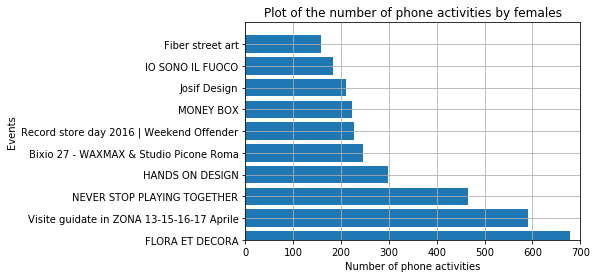

In [149]:
x = np.arange(10)
y = np.array(top_ten_female_phone_activities_count_df['activity'])[:10]
plt.barh(x, y)
plt.xlabel('Number of phone activities')
plt.ylabel('Events')
plt.yticks(np.arange(10), top_ten_female_events_for_phone_activities_titles.tolist())
plt.title('Plot of the number of phone activities by females')
plt.axis([0, 700, 0, 10])
plt.grid(b=True)
plt.show()

In [344]:
#top_ten_checkins	top_ten_events_for_checkins_titles
#top_ten_agenda		top_ten_agenda_event_titles
#top_ten_agenda_actions		top_ten_agenda_actions_titles
#top_ten_map		top_ten_map_event_titles
#top_ten_photos		top_ten_photos_event_titles
#top_ten_share		top_ten_share_event_titles
#top_ten_phone_activities	top_ten_events_for_phone_activities_titles
#top_ten_young_phone_activities	top_ten_young_events_for_phone_activities_titles
#top_ten_female_phone_activities	top_ten_female_events_for_phone_activities_titles
#top_ten_male_phone_activities	top_ten_male_events_for_phone_activities_titles

top = [top_ten_share_event_titles, top_ten_photos_event_titles, top_ten_map_event_titles, top_ten_agenda_event_titles, top_ten_agenda_actions_titles, top_ten_events_for_checkins_titles, top_ten_events_for_phone_activities_titles] # 0 results
top_interests_checkins = [top_ten_share_event_titles, top_ten_photos_event_titles, top_ten_map_event_titles, top_ten_agenda_event_titles, top_ten_agenda_actions_titles, top_ten_events_for_checkins_titles] # 0 results
top_interests_phone = [top_ten_share_event_titles, top_ten_photos_event_titles, top_ten_map_event_titles, top_ten_agenda_event_titles, top_ten_agenda_actions_titles, top_ten_events_for_phone_activities_titles] # 0 results
top_interests = [top_ten_share_event_titles, top_ten_photos_event_titles, top_ten_map_event_titles, top_ten_agenda_event_titles, top_ten_agenda_actions_titles] # 1 result
top_phone_checkins = [top_ten_events_for_checkins_titles, top_ten_events_for_phone_activities_titles] # 0 results
top_young_female_phone = [top_ten_young_events_for_phone_activities_titles, top_ten_female_events_for_phone_activities_titles] # 5 results
top_young_male_phone = [top_ten_young_events_for_phone_activities_titles, top_ten_male_events_for_phone_activities_titles] # 5 results
top_senior_female_phone = [top_ten_senior_events_for_phone_activities_titles, top_ten_female_events_for_phone_activities_titles] # 4 results
top_senior_male_phone = [top_ten_senior_events_for_phone_activities_titles, top_ten_male_events_for_phone_activities_titles] # 3 results
top_unigender_phone = [top_ten_female_events_for_phone_activities_titles, top_ten_male_events_for_phone_activities_titles] # 0 results
top_all_ages_phones = [top_ten_senior_events_for_phone_activities_titles, top_ten_young_events_for_phone_activities_titles] # 0 results

reduce(lambda first, second: pd.Series(list(set(first) & set(second))), top_interests)

0    CasaVitra
dtype: object

There is not an event which is among the top-10 in all the perspectives considered.
The most popular event considering agenda and actions analytics is the event "Casavitra".
The most popular event considering check-ins and phone activities is the event "LIVE, WORK, DESIGN - Archiproducts Milano".

### Other interesting information
There are other information which can be extracted from the events:
- award-winning event;
- open-party events;
- typologies of event.

In [151]:
print(len(event_df[event_df['award'] == True]))
event_df[event_df['award'] == True].head()

16


,_id,author,award,brands,categories,contatti,created,days,descrizione,designers,...,modified,photos,slug,sponsor_event,status,titolo,updated,url,url_en,url_it
285,{'$oid': '570cdc6a1e24f28cf95da417'},sarah@rotajorfida.com,True,"[{'id': '421', 'status': '1', 'nome': 'JCP', '...","[{'id': '8', 'status': '1', 'macrocategory_id'...",{'it': '<p>Rota&amp;Jorfida | Public Relations...,1.458726e+12,"[{'id': '1940', 'event_id': '847', 'dataora_in...","{'it': '<p dir=""ltr"" style=""line-height:1.2;ma...",[],...,1.460558e+12,[],"{'it': 'ten-secret-treasures', 'en': 'ten-secr...",0,1,"{'it': 'Ten Secret Treasures', 'en': 'Ten Secr...",1.460570e+12,http://fuorisalone.it/2016/api/event?id=847,http://fuorisalone.it/2016/en/events/847/ten-s...,http://fuorisalone.it/2016/it/eventi/847/ten-s...
534,{'$oid': '570cdc6a1e24f28cf95da511'},limorf@caesarstone.com,True,"[{'id': '1094', 'status': '1', 'nome': 'Caesar...","[{'id': '6', 'status': '1', 'macrocategory_id'...","{'it': '<p><font color=""#000000""><span style=""...",1.459770e+12,"[{'id': '4654', 'event_id': '1151', 'dataora_i...","{'it': '<p><span style=""font: 17px/33px Public...","[{'id': '759', 'status': '1', 'nome': 'Tom', '...",...,1.460558e+12,"[{'id': '872', 'created': '2016-04-12 23:35:18...",{'it': 'the-restaurant-by-caesarstone-and-tom-...,0,1,{'it': 'The Restaurant by Caesarstone and Tom ...,1.460570e+12,http://fuorisalone.it/2016/api/event?id=1151,http://fuorisalone.it/2016/en/events/1151/the-...,http://fuorisalone.it/2016/it/eventi/1151/the-...
560,{'$oid': '570cdc6b1e24f28cf95da52b'},coordinator@tortonadesignweek.com,True,"[{'id': '246', 'status': '1', 'nome': 'Miele',...","[{'id': '10', 'status': '1', 'macrocategory_id...","{'it': '<p class=""p1"">Michael Prempert</p> ...",1.458236e+12,"[{'id': '1049', 'event_id': '581', 'dataora_in...","{'it': '<p>Miele, makes its Tortona debut at E...",[],...,1.460647e+12,"[{'id': '680', 'created': '2016-04-12 21:32:48...","{'it': 'the-invisible-kitchen', 'en': 'the-inv...",0,1,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV...",1.460647e+12,http://fuorisalone.it/2016/api/event?id=581,http://fuorisalone.it/2016/en/events/581/the-i...,http://fuorisalone.it/2016/it/eventi/581/the-i...
604,{'$oid': '570cdc6b1e24f28cf95da557'},milano@organisationindesign.com,True,"[{'id': '817', 'status': '1', 'nome': 'LENSVEL...","[{'id': '20', 'status': '1', 'macrocategory_id...",{'it': '<p>p.wolters@lensvelt.nl<br /> www.bo...,1.459423e+12,"[{'id': '3872', 'event_id': '1018', 'dataora_i...",{'it': '<p>&#39;Boring collection&#39; &egrave...,[],...,1.460558e+12,[],"{'it': 'boring-collection', 'en': 'boring-coll...",0,1,"{'it': 'Boring Collection', 'en': 'Boring Coll...",1.460570e+12,http://fuorisalone.it/2016/api/event?id=1018,http://fuorisalone.it/2016/en/events/1018/bori...,http://fuorisalone.it/2016/it/eventi/1018/bori...
610,{'$oid': '570cdc6b1e24f28cf95da55d'},coordinator@tortonadesignweek.com,True,"[{'id': '110', 'status': '1', 'nome': 'Lee Bro...","[{'id': '4', 'status': '1', 'macrocategory_id'...","{'it': '<p class=""p1"">Kelly Teasdale</p> <p...",1.458234e+12,"[{'id': '1030', 'event_id': '577', 'dataora_in...","{'it': '<p class=""p1"">Designer Londinese Lee B...","[{'id': '3', 'status': '1', 'nome': 'Lee', 'co...",...,1.460558e+12,[],"{'it': 'salone-del-automobile', 'en': 'salone-...",0,1,"{'it': 'Salone Del Automobile ', 'en': 'Salone...",1.460570e+12,http://fuorisalone.it/2016/api/event?id=577,http://fuorisalone.it/2016/en/events/577/salon...,http://fuorisalone.it/2016/it/eventi/577/salon...


In [152]:
print(len(event_days_df[event_days_df['open_party'] != '0']))
event_days_df[event_days_df['open_party'] != '0'].head()

500


,event_id,location_id,start_datetime,end_datetime,open_party,type,latitude,longitude
9,102,28,2016-04-14 18:00:00,2016-04-14 23:30:00,1,festa_cocktail,45.451536,9.161937
12,102,28,2016-04-16 09:30:00,2016-04-16 23:30:00,1,festa_cocktail,45.451536,9.161937
28,1596,57,2016-04-13 18:30:00,2016-04-13 21:30:00,1,festa_cocktail,45.481784,9.187185
31,1590,60,2016-04-13 18:30:00,2016-04-13 21:30:00,1,festa_cocktail,45.465701,9.171648
49,1168,138,2016-04-12 18:00:00,2016-04-12 21:00:00,1,festa_cocktail,45.464560,9.188032


In [153]:
event_days_df.drop_duplicates(subset='type')

,event_id,location_id,start_datetime,end_datetime,open_party,type,latitude,longitude
0,888,1,2016-04-12 00:00:00,2016-04-12 23:30:00,0,esposizione,45.450479,9.156274
9,102,28,2016-04-14 18:00:00,2016-04-14 23:30:00,1,festa_cocktail,45.451536,9.161937
105,1577,409,2016-04-13 18:30:00,2016-04-13 19:30:00,0,conferenza,45.461758,9.209307
107,1577,409,2016-04-15 09:00:00,2016-04-15 20:30:00,0,presentazione,45.461758,9.209307
108,1577,409,2016-04-16 09:30:00,2016-04-16 13:30:00,0,workshop,45.461758,9.209307
112,1335,416,2016-04-12 18:00:00,2016-04-12 22:00:00,0,festa_riservata,45.482885,9.183443
160,1609,588,2016-04-13 16:00:00,2016-04-13 21:00:00,0,show,45.464161,9.190336
168,620,600,2016-04-13 19:00:00,2016-04-13 22:00:00,0,incontro,45.479739,9.194124
206,1492,953,2016-04-12 10:00:00,2016-04-12 22:00:00,0,altro,45.453571,9.169870
247,839,1115,2016-04-14 14:30:00,2016-04-14 20:00:00,0,press_preview,45.467654,9.200360


#### Award-winning events
It can be interesting to examine the amount of award-winning events among the top-10.

In [154]:
award_winning_events_df = event_df[event_df['award'] == True]
award_winning_events_df['title'] = award_winning_events_df['titolo']
del(award_winning_events_df['titolo'])
award_winning_events_df = award_winning_events_df.loc[:,['id', 'title']]
award_winning_events_df.head()

c:\programdata\miniconda3\envs\ws\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,title
285,847,"{'it': 'Ten Secret Treasures', 'en': 'Ten Secr..."
534,1151,{'it': 'The Restaurant by Caesarstone and Tom ...
560,581,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV..."
604,1018,"{'it': 'Boring Collection', 'en': 'Boring Coll..."
610,577,"{'it': 'Salone Del Automobile ', 'en': 'Salone..."


In [155]:
pd.merge(award_winning_events_df, top_ten_phone_activities, left_on='id', right_on='event_id')

,id,title_x,event_id,title_y


In [156]:
pd.merge(award_winning_events_df, top_ten_share, left_on='id', right_on='event')

,id,title_x,event,title_y
0,581,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV...",581,THE INVISIBLE KITCHEN
1,662,{'it': 'Lexus – An Encounter with Anticipation...,662,Lexus – An Encounter with Anticipation
2,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}",699,CasaVitra
3,941,{'it': 'Back Ahead - New Austrian Design Persp...,941,Back Ahead - New Austrian Design Perspectives
4,758,"{'it': '“KŪKAN” The Invention of Space', 'en'...",758,“KŪKAN” The Invention of Space
5,942,"{'it': 'Data Orchestra', 'en': 'Data Orchestra'}",942,Data Orchestra
6,985,{'it': 'DOUTDESign Headquarter eventi daybyday...,985,DOUTDESign Headquarter eventi daybyday
7,28,"{'it': 'Colors', 'en': 'Colors'}",28,Colors
8,1526,"{'it': 'Imagine New Days', 'en': 'Imagine New ...",1526,Imagine New Days


In [157]:
pd.merge(award_winning_events_df, top_ten_photos, left_on='id', right_on='event')

,id,title_x,event,title_y
0,581,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV...",581,THE INVISIBLE KITCHEN
1,662,{'it': 'Lexus – An Encounter with Anticipation...,662,Lexus – An Encounter with Anticipation
2,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}",699,CasaVitra
3,758,"{'it': '“KŪKAN” The Invention of Space', 'en'...",758,“KŪKAN” The Invention of Space
4,28,"{'it': 'Colors', 'en': 'Colors'}",28,Colors
5,1643,"{'it': 'The nature of motion', 'en': 'The natu...",1643,The nature of motion


In [158]:
pd.merge(award_winning_events_df, top_ten_map, left_on='id', right_on='event')

,id,title_x,event,title_y
0,1151,{'it': 'The Restaurant by Caesarstone and Tom ...,1151,The Restaurant by Caesarstone and Tom Dixon
1,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}",699,CasaVitra
2,1643,"{'it': 'The nature of motion', 'en': 'The natu...",1643,The nature of motion


In [159]:
pd.merge(award_winning_events_df, top_ten_agenda, left_on='id', right_on='event')

,id,title_x,event,title_y
0,581,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV...",581,THE INVISIBLE KITCHEN
1,662,{'it': 'Lexus – An Encounter with Anticipation...,662,Lexus – An Encounter with Anticipation
2,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}",699,CasaVitra
3,28,"{'it': 'Colors', 'en': 'Colors'}",28,Colors


In [160]:
pd.merge(award_winning_events_df, top_ten_agenda_actions, left_on='id', right_on='event')

,id,title_x,event,title_y
0,1151,{'it': 'The Restaurant by Caesarstone and Tom ...,1151,The Restaurant by Caesarstone and Tom Dixon
1,581,"{'it': 'THE INVISIBLE KITCHEN', 'en': 'THE INV...",581,THE INVISIBLE KITCHEN
2,662,{'it': 'Lexus – An Encounter with Anticipation...,662,Lexus – An Encounter with Anticipation
3,699,"{'it': 'CasaVitra', 'en': 'CasaVitra'}",699,CasaVitra
4,28,"{'it': 'Colors', 'en': 'Colors'}",28,Colors


In [161]:
pd.merge(award_winning_events_df, top_ten_checkins, left_on='id', right_on='event_id')

,id,title_x,event_id,title_y


The results above demonstrate that there is not a correlation between the physical partecipation records and the award-winning events. However, it is clear that the user interest was a clear indicator of the award-winning events. In particular, nine out of the ten most shared events on socials are award-winning events. 

#### Open-party events

In [162]:
open_party_events_df = event_days_df[event_days_df['open_party'] != '0']
open_party_events_df = open_party_events_df.loc[:,['event_id', 'open_party']]
open_party_events_df.head()

,event_id,open_party
9,102,1
12,102,1
28,1596,1
31,1590,1
49,1168,1


In [163]:
open_party_events_df = open_party_events_df.groupby('event_id').size().reset_index()
open_party_events_df.head()

,event_id,0
0,100,1
1,1002,2
2,1004,1
3,1008,1
4,1009,6


In [164]:
pd.merge(open_party_events_df, top_ten_phone_activities, on='event_id')

,event_id,0,title
0,1607,1,terrae altrove italian experience congli artis...
1,1622,1,"Il Simposio de ""Il Collirio"" - Milano Fuori da..."


In [165]:
pd.merge(open_party_events_df, top_ten_female_phone_activities, on='event_id')

,event_id,0,title
0,1121,1,Record store day 2016 | Weekend Offender
1,933,1,Bixio 27 - WAXMAX & Studio Picone Roma


In [166]:
pd.merge(open_party_events_df, top_ten_male_phone_activities, on='event_id')

,event_id,0,title
0,1108,2,l'immagine dell'architettura e l'architettura ...
1,1607,1,terrae altrove italian experience congli artis...
2,1622,1,"Il Simposio de ""Il Collirio"" - Milano Fuori da..."


In [167]:
pd.merge(open_party_events_df, top_ten_young_phone_activities, on='event_id')

,event_id,0,title
0,1607,1,terrae altrove italian experience congli artis...
1,933,1,Bixio 27 - WAXMAX & Studio Picone Roma


In [168]:
pd.merge(open_party_events_df, top_ten_senior_phone_activities, on='event_id')

,event_id,0,title
0,1095,1,la Gioia é una cosa seria.
1,1121,1,Record store day 2016 | Weekend Offender
2,1540,1,FUORI SALONE - Cîroc Official Party
3,1622,1,"Il Simposio de ""Il Collirio"" - Milano Fuori da..."


In [169]:
pd.merge(open_party_events_df, top_ten_share, left_on='event_id', right_on='event')

,event_id,0,event,title
0,28,1,28,Colors
1,941,2,941,Back Ahead - New Austrian Design Perspectives
2,985,11,985,DOUTDESign Headquarter eventi daybyday


In [170]:
pd.merge(open_party_events_df, top_ten_photos, left_on='event_id', right_on='event')

,event_id,0,event,title
0,25,1,25,Noni
1,26,1,26,"In-chiostro creativo | design, architettura e ..."
2,28,1,28,Colors
3,30,1,30,Kartell by Laufen


In [171]:
pd.merge(open_party_events_df, top_ten_map, left_on='event_id', right_on='event')

,event_id,0,event,title
0,1481,1,1481,"Raw Edges, ""Herringbones"""
1,26,1,26,"In-chiostro creativo | design, architettura e ..."
2,811,4,811,space&interiors


In [172]:
pd.merge(open_party_events_df, top_ten_agenda, left_on='event_id', right_on='event')

,event_id,0,event,title
0,28,1,28,Colors
1,754,1,754,KARTELL BY LAUFEN


In [173]:
pd.merge(open_party_events_df, top_ten_agenda_actions, left_on='event_id', right_on='event')

,event_id,0,event,title
0,26,1,26,"In-chiostro creativo | design, architettura e ..."
1,28,1,28,Colors


In [174]:
pd.merge(open_party_events_df, top_ten_checkins, on='event_id')

,event_id,0,title
0,1160,1,“New Dimensions for Kitchens. The very essence...
1,823,1,VILLAGE CHAIRS di Carlo Malerba
2,99,1,Night Tales


In this case there is not such a stark contrast between the physical location and the users interest. It is clear that there is some correlation between the open-party typology of events and the popularity of the events.

#### Typology of events

Note that while for the check-ins and phone activities it is possible to access the exact day of the event, thus the corresponding type, the same does not hold for the user interest. In fact, a user expressed his interest to an event as a whole; for this reason, all the types associated to an event are reported.

In [175]:
event_types_df = event_days_df.drop_duplicates(subset='type')
event_types_df = event_types_df.loc[:,['event_id', 'type']]
event_types_df

,event_id,type
0,888,esposizione
9,102,festa_cocktail
105,1577,conferenza
107,1577,presentazione
108,1577,workshop
112,1335,festa_riservata
160,1609,show
168,620,incontro
206,1492,altro
247,839,press_preview


In [176]:
event_days_df = pd.DataFrame.from_records(event_days, columns=['event_id', 'location_id', 'start_datetime', 'end_datetime', 'open_party', 'type'])
event_days_df.head()

,event_id,location_id,start_datetime,end_datetime,open_party,type
0,888,1,2016-04-12 00:00:00,2016-04-12 23:30:00,0,esposizione
1,888,1,2016-04-13 00:00:00,2016-04-13 23:30:00,0,esposizione
2,888,1,2016-04-14 00:00:00,2016-04-14 23:30:00,0,esposizione
3,888,1,2016-04-15 00:00:00,2016-04-15 23:30:00,0,esposizione
4,888,1,2016-04-16 00:00:00,2016-04-16 23:30:00,0,esposizione


In [177]:
event_days_df = event_days_df.groupby(['event_id', 'type']).size().reset_index()
event_days_df.head()

,event_id,type,0
0,100,esposizione,2
1,100,festa_cocktail,1
2,100,presentazione,3
3,1000,esposizione,9
4,1001,conferenza,1


In [178]:
event_days_df['type_count'] = event_days_df[0]
del(event_days_df[0])
event_days_df.head()

,event_id,type,type_count
0,100,esposizione,2
1,100,festa_cocktail,1
2,100,presentazione,3
3,1000,esposizione,9
4,1001,conferenza,1


In [179]:
checkins_types = pd.merge(event_days_df, top_ten_checkins, on='event_id')
checkins_types

,event_id,type,type_count,title
0,1160,esposizione,6,“New Dimensions for Kitchens. The very essence...
1,1160,festa_cocktail,1,“New Dimensions for Kitchens. The very essence...
2,1308,esposizione,6,Aston Martin showcases powerboat design in Milan
3,1308,festa_riservata,1,Aston Martin showcases powerboat design in Milan
4,1339,esposizione,6,Arch and Art
5,1522,esposizione,6,EATALY: L'ASCOLTO DEL CIBO
6,245,esposizione,5,Shopping&Design
7,245,show,6,Shopping&Design
8,245,workshop,6,Shopping&Design
9,627,esposizione,10,La casa conviviale


In [180]:
checkins_types = checkins_types.groupby(['type']).size().reset_index()
checkins_types

,type,0
0,esposizione,10
1,festa_cocktail,3
2,festa_riservata,1
3,incontro,1
4,show,1
5,workshop,1


In [181]:
agenda_types = pd.merge(event_days_df, top_ten_agenda, left_on='event_id', right_on='event')
agenda_types

,event_id,type,type_count,event,title
0,1166,esposizione,6,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
1,1419,esposizione,6,1419,Glow Of Life
2,28,esposizione,6,28,Colors
3,28,festa_cocktail,1,28,Colors
4,32,show,5,32,THE TASTE OF COLORS
5,581,esposizione,6,581,THE INVISIBLE KITCHEN
6,662,esposizione,6,662,Lexus – An Encounter with Anticipation
7,699,esposizione,6,699,CasaVitra
8,735,esposizione,6,735,HAY
9,754,esposizione,6,754,KARTELL BY LAUFEN


In [182]:
agenda_types = agenda_types.groupby(['type']).size().reset_index()
agenda_types

,type,0
0,esposizione,9
1,festa_cocktail,2
2,show,1


In [183]:
agenda_actions_types = pd.merge(event_days_df, top_ten_agenda_actions, left_on='event_id', right_on='event')
agenda_actions_types

,event_id,type,type_count,event,title
0,1151,esposizione,6,1151,The Restaurant by Caesarstone and Tom Dixon
1,1166,esposizione,6,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
2,1419,esposizione,6,1419,Glow Of Life
3,26,conferenza,8,26,"In-chiostro creativo | design, architettura e ..."
4,26,esposizione,6,26,"In-chiostro creativo | design, architettura e ..."
5,26,festa_cocktail,1,26,"In-chiostro creativo | design, architettura e ..."
6,26,workshop,2,26,"In-chiostro creativo | design, architettura e ..."
7,28,esposizione,6,28,Colors
8,28,festa_cocktail,1,28,Colors
9,581,esposizione,6,581,THE INVISIBLE KITCHEN


In [184]:
agenda_actions_types = agenda_actions_types.groupby(['type']).size().reset_index()
agenda_actions_types

,type,0
0,conferenza,1
1,esposizione,10
2,festa_cocktail,2
3,workshop,1


In [185]:
map_types = pd.merge(event_days_df, top_ten_map, left_on='event_id', right_on='event')
map_types

,event_id,type,type_count,event,title
0,1151,esposizione,6,1151,The Restaurant by Caesarstone and Tom Dixon
1,1154,esposizione,6,1154,The Design of Words by Calligraphy Masters
2,1166,esposizione,6,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
3,1481,esposizione,6,1481,"Raw Edges, ""Herringbones"""
4,1481,festa_cocktail,1,1481,"Raw Edges, ""Herringbones"""
5,1643,esposizione,6,1643,The nature of motion
6,1648,esposizione,6,1648,"Spazio, luce e ombra con Sou Fujimoto per COS"
7,26,conferenza,8,26,"In-chiostro creativo | design, architettura e ..."
8,26,esposizione,6,26,"In-chiostro creativo | design, architettura e ..."
9,26,festa_cocktail,1,26,"In-chiostro creativo | design, architettura e ..."


In [186]:
map_types = map_types.groupby(['type']).size().reset_index()
map_types

,type,0
0,conferenza,1
1,esposizione,10
2,festa_cocktail,3
3,incontro,1
4,workshop,1


In [187]:
photos_types = pd.merge(event_days_df, top_ten_photos, left_on='event_id', right_on='event')
photos_types

,event_id,type,type_count,event,title
0,1419,esposizione,6,1419,Glow Of Life
1,1643,esposizione,6,1643,The nature of motion
2,25,esposizione,6,25,Noni
3,25,festa_cocktail,1,25,Noni
4,26,conferenza,8,26,"In-chiostro creativo | design, architettura e ..."
5,26,esposizione,6,26,"In-chiostro creativo | design, architettura e ..."
6,26,festa_cocktail,1,26,"In-chiostro creativo | design, architettura e ..."
7,26,workshop,2,26,"In-chiostro creativo | design, architettura e ..."
8,28,esposizione,6,28,Colors
9,28,festa_cocktail,1,28,Colors


In [188]:
photos_types = photos_types.groupby(['type']).size().reset_index()
photos_types

,type,0
0,conferenza,1
1,esposizione,10
2,festa_cocktail,4
3,workshop,1


In [189]:
share_types = pd.merge(event_days_df, top_ten_share, left_on='event_id', right_on='event')
share_types

,event_id,type,type_count,event,title
0,1526,esposizione,6,1526,Imagine New Days
1,28,esposizione,6,28,Colors
2,28,festa_cocktail,1,28,Colors
3,32,show,5,32,THE TASTE OF COLORS
4,581,esposizione,6,581,THE INVISIBLE KITCHEN
5,662,esposizione,6,662,Lexus – An Encounter with Anticipation
6,699,esposizione,6,699,CasaVitra
7,758,esposizione,6,758,“KŪKAN” The Invention of Space
8,941,esposizione,6,941,Back Ahead - New Austrian Design Perspectives
9,941,festa_cocktail,2,941,Back Ahead - New Austrian Design Perspectives


In [190]:
share_types = share_types.groupby(['type']).size().reset_index()
share_types

,type,0
0,esposizione,9
1,festa_cocktail,3
2,presentazione,1
3,press_preview,1
4,show,1


In [191]:
phone_activities_types = pd.merge(event_days_df, top_ten_phone_activities, on='event_id')
phone_activities_types

,event_id,type,type_count,title
0,1343,esposizione,4,Visite guidate in ZONA 13-15-16-17 Aprile
1,1344,esposizione,3,FLORA ET DECORA
2,1374,incontro,1,Open Design Italia 2016 - The Challenge
3,1573,esposizione,3,NEVER STOP EATING SOCIAL
4,1607,esposizione,8,terrae altrove italian experience congli artis...
5,1607,festa_cocktail,1,terrae altrove italian experience congli artis...
6,1607,press_preview,2,terrae altrove italian experience congli artis...
7,1613,presentazione,3,Design e moda: sample sale di tre brand del lu...
8,1622,esposizione,1,"Il Simposio de ""Il Collirio"" - Milano Fuori da..."
9,1622,festa_cocktail,1,"Il Simposio de ""Il Collirio"" - Milano Fuori da..."


In [192]:
phone_activities_types = phone_activities_types.groupby(['type']).size().reset_index()
phone_activities_types

,type,0
0,esposizione,6
1,festa_cocktail,2
2,incontro,1
3,presentazione,2
4,press_preview,1
5,workshop,1


In [193]:
phone_activities_types = pd.merge(event_days_df, top_ten_female_phone_activities, on='event_id')
phone_activities_types

,event_id,type,type_count,title
0,1007,esposizione,2,Josif Design
1,1121,festa_cocktail,1,Record store day 2016 | Weekend Offender
2,1343,esposizione,4,Visite guidate in ZONA 13-15-16-17 Aprile
3,1344,esposizione,3,FLORA ET DECORA
4,1399,esposizione,2,Fiber street art
5,1631,esposizione,1,HANDS ON DESIGN
6,673,workshop,2,NEVER STOP PLAYING TOGETHER
7,857,festa_riservata,1,IO SONO IL FUOCO
8,933,esposizione,7,Bixio 27 - WAXMAX & Studio Picone Roma
9,933,festa_cocktail,1,Bixio 27 - WAXMAX & Studio Picone Roma


In [194]:
phone_activities_types = phone_activities_types.groupby(['type']).size().reset_index()
phone_activities_types

,type,0
0,esposizione,7
1,festa_cocktail,2
2,festa_riservata,1
3,press_preview,1
4,workshop,1


In [195]:
phone_activities_types = pd.merge(event_days_df, top_ten_male_phone_activities, on='event_id')
phone_activities_types

,event_id,type,type_count,title
0,1108,esposizione,4,l'immagine dell'architettura e l'architettura ...
1,1108,festa_cocktail,2,l'immagine dell'architettura e l'architettura ...
2,1374,incontro,1,Open Design Italia 2016 - The Challenge
3,1573,esposizione,3,NEVER STOP EATING SOCIAL
4,1607,esposizione,8,terrae altrove italian experience congli artis...
5,1607,festa_cocktail,1,terrae altrove italian experience congli artis...
6,1607,press_preview,2,terrae altrove italian experience congli artis...
7,1613,presentazione,3,Design e moda: sample sale di tre brand del lu...
8,1622,esposizione,1,"Il Simposio de ""Il Collirio"" - Milano Fuori da..."
9,1622,festa_cocktail,1,"Il Simposio de ""Il Collirio"" - Milano Fuori da..."


In [196]:
phone_activities_types = phone_activities_types.groupby(['type']).size().reset_index()
phone_activities_types

,type,0
0,esposizione,7
1,festa_cocktail,3
2,festa_riservata,1
3,incontro,1
4,presentazione,3
5,press_preview,2


In [197]:
phone_activities_types = pd.merge(event_days_df, top_ten_young_phone_activities, on='event_id')
phone_activities_types

,event_id,type,type_count,title
0,1343,esposizione,4,Visite guidate in ZONA 13-15-16-17 Aprile
1,1344,esposizione,3,FLORA ET DECORA
2,1573,esposizione,3,NEVER STOP EATING SOCIAL
3,1607,esposizione,8,terrae altrove italian experience congli artis...
4,1607,festa_cocktail,1,terrae altrove italian experience congli artis...
5,1607,press_preview,2,terrae altrove italian experience congli artis...
6,1613,presentazione,3,Design e moda: sample sale di tre brand del lu...
7,605,presentazione,1,Atelier by Republic of Fritz Hansen
8,673,workshop,2,NEVER STOP PLAYING TOGETHER
9,855,esposizione,5,DEKTONHENGE by Apparatu


In [198]:
phone_activities_types = phone_activities_types.groupby(['type']).size().reset_index()
phone_activities_types

,type,0
0,esposizione,7
1,festa_cocktail,2
2,festa_riservata,1
3,presentazione,2
4,press_preview,3
5,workshop,1


In [199]:
phone_activities_types = pd.merge(event_days_df, top_ten_senior_phone_activities, on='event_id')
phone_activities_types

,event_id,type,type_count,title
0,1007,esposizione,2,Josif Design
1,1095,esposizione,5,la Gioia é una cosa seria.
2,1095,festa_cocktail,1,la Gioia é una cosa seria.
3,1121,festa_cocktail,1,Record store day 2016 | Weekend Offender
4,1374,incontro,1,Open Design Italia 2016 - The Challenge
5,1540,festa_cocktail,1,FUORI SALONE - Cîroc Official Party
6,1604,altro,1,¡Puro Sabor Español!
7,1622,esposizione,1,"Il Simposio de ""Il Collirio"" - Milano Fuori da..."
8,1622,festa_cocktail,1,"Il Simposio de ""Il Collirio"" - Milano Fuori da..."
9,1631,esposizione,1,HANDS ON DESIGN


In [200]:
phone_activities_types = phone_activities_types.groupby(['type']).size().reset_index()
phone_activities_types

,type,0
0,altro,1
1,esposizione,5
2,festa_cocktail,4
3,festa_riservata,1
4,incontro,1


It is clear from the results that the most visited events were 'expositions', followed by 'cocktail parties'. Any other typology of event has broadly the same level of attendance.

### Brands, designers, categories

There are other information which can be extracted from the events: 
- the associated brands;
- the associated designers;
- the associated categories.

In [201]:
# before considering the other elements, let's create a list of the ids of the events
event_ids = list(event_df['id'])
event_ids[:5]

['888', '102', '1063', '1582', '1047']

In [202]:
event_df['brands'].loc[4]

[{'contatti': '<p><span style="color: rgb(177, 177, 177); font-family: Gotham-Medium, sans-serif; font-size: 12.6px; line-height: 18.9px; background-color: rgb(0, 0, 0);">Bosa | Direzione Generale</span><br style="box-sizing: border-box; color: rgb(177, 177, 177); font-family: Gotham-Medium, sans-serif; font-size: 12.6px; line-height: 18.9px; background-color: rgb(0, 0, 0);" />\r\n<span style="color: rgb(177, 177, 177); font-family: Gotham-Medium, sans-serif; font-size: 12.6px; line-height: 18.9px; background-color: rgb(0, 0, 0);">Via Molini, 44 - 31030 Borso del Grappa TREVISO - IT</span></p>',
  'country_code': 'IT',
  'created': '2016-04-01 11:17:40',
  'email': 'bosaceramiche@umbrella.it',
  'id': '899',
  'modified': '2016-04-01 13:12:01',
  'nome': 'Bosa Ceramiche',
  'status': '1',
  'telefono': '0423 561483',
  'website': 'http://www.bosatrade.com/it/'}]

In [203]:
# let's consider the brands
brands_df = event_df['brands'].apply(lambda x: pd.Series(str(x).split('},')))
brands_df.head()

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'id': '156', 'status': '1', 'nome': 'Fanfull...","{'id': '155', 'status': '1', 'nome': 'Officin...","{'id': '154', 'status': '1', 'nome': 'Ottagon...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'id': '925', 'status': '1', 'nome': 'BISAZZA...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'id': '829', 'status': '1', 'nome': 'IED', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'id': '899', 'status': '1', 'nome': 'Bosa Ce...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
brands_df.loc[2,0]

"[{'id': '925', 'status': '1', 'nome': 'BISAZZA', 'country_code': 'IT', 'contatti': '', 'created': '2016-04-01 12:53:56', 'modified': '2016-04-01 13:11:47', 'website': 'www.bisazza.com', 'telefono': '02 76021313', 'email': 'pressoffice@bisazza.com'}]"

In [205]:
# create a list with the attributes of interest in brands: 'nome', 'id', 'country_code'; insert also the id of the event
event_brands = []
for i in range(len(brands_df.index)):    
    for j in range(83):          
        # if the value is NaN exit the inner loop and consider the following row
        if pd.isnull(brands_df.loc[i,j]):
            break
        # if the list is empty (string = '[]') break
        if len(brands_df.loc[i,j]) == 2:
            break
        # create a sublist
        event_brand = []
        attributes = brands_df.loc[i,j].split(',')        
        # event_id
        event_brand.append(event_ids[i])
        # brand id
        event_brand.append(attributes[0][9:-1].strip())
        # nome
        event_brand.append(attributes[2][10:-1].strip())
        # country_code
        event_brand.append(attributes[3][18:-1].strip())        
        # append these elements to the sublist
        event_brands.append(event_brand)
    
event_brands[:4]

[['102', '156', 'Fanfulla robe da matti', 'IT'],
 ['102', '155', 'Officina 33', 'IT'],
 ['102', '154', 'Ottagona', 'IT'],
 ['1063', '925', 'BISAZZA', 'IT']]

In [206]:
# create a DataFrame for brands
event_brands_df = pd.DataFrame.from_records(event_brands, columns=['event_id', 'brand_id', 'nome', 'country_code'])
event_brands_df['name'] = event_brands_df['nome']
del(event_brands_df['nome'])
event_brands_df.head()

,event_id,brand_id,country_code,name
0,102,156,IT,Fanfulla robe da matti
1,102,155,IT,Officina 33
2,102,154,IT,Ottagona
3,1063,925,IT,BISAZZA
4,1582,829,IT,IED


In [207]:
# let's consider the designers
designers_df = event_df['designers'].apply(lambda x: pd.Series(str(x).split('},')))
designers_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'id': '164', 'status': '1', 'nome': 'Orsola'...","{'id': '166', 'status': '1', 'nome': 'Frances...","{'id': '165', 'status': '1', 'nome': 'Marco',...","{'id': '167', 'status': '1', 'nome': 'Antonel...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'id': '184', 'status': '1', 'nome': 'Job', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'id': '675', 'status': '1', 'nome': 'Frances...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
designers_df.loc[2,0]

"[{'id': '184', 'status': '1', 'nome': 'Job', 'cognome': 'Studio', 'country_code': None, 'data_nascita': None, 'sesso': None, 'created': '2016-03-15 14:06:44', 'modified': '2016-03-15 20:18:29'}]"

In [209]:
# create a list with the attributes of interest in designers: 'id', nome', 'cognome', 'country_code', 'data_nascita', 'sesso'; insert also the id of the event
event_designers = []
for i in range(len(designers_df.index)):    
    for j in range(27):          
        # if the value is NaN exit the inner loop and consider the following row
        if pd.isnull(designers_df.loc[i,j]):
            break
        # if the list is empty (string = '[]') break
        if len(designers_df.loc[i,j]) == 2:
            break
        # create a sublist
        event_designer = []
        attributes = designers_df.loc[i,j].split(',')        
        # event_id
        event_designer.append(event_ids[i])
        #designer id
        event_designer.append(attributes[0][9:-1].strip())
        # nome
        event_designer.append(attributes[2][10:-1].strip())
        #cognome
        event_designer.append(attributes[3][13:-1].strip())   
        # country_code
        event_designer.append(attributes[4][18:-1].strip())
        # data_nascita
        event_designer.append(attributes[5][18:-1].strip())
        # sesso
        event_designer.append(attributes[6][11:-1].strip())
        # append these elements to the sublist
        event_designers.append(event_designer)
    
event_designers[:5]

[['102', '164', 'Orsola', 'Fontana', 'IT', '1985-10-27', '2'],
 ['102', '166', 'Francesca', 'Perini', 'IT', '1969-03-11', '2'],
 ['102', '165', 'Marco', 'Schiavon', 'IT', '1976-05-06', '1'],
 ['102', '167', 'Antonella', 'Vaccari', 'IT', '1965-05-15', '2'],
 ['1063', '184', 'Job', 'Studio', 'on', 'on', 'on']]

In [210]:
# create a DataFrame for designers
event_designers_df = pd.DataFrame.from_records(event_designers, columns=['event_id', 'designer_id', 'nome', 'cognome', 'country_code', 'data_nascita', 'sesso'])
event_designers_df['name'] = event_designers_df['nome']
event_designers_df['surname'] = event_designers_df['cognome']
event_designers_df['birthdate'] = event_designers_df['data_nascita']
event_designers_df['sex'] = event_designers_df['sesso']
del(event_designers_df['nome'])
del(event_designers_df['cognome'])
del(event_designers_df['data_nascita'])
del(event_designers_df['sesso'])
event_designers_df.head()

,event_id,designer_id,country_code,name,surname,birthdate,sex
0,102,164,IT,Orsola,Fontana,1985-10-27,2
1,102,166,IT,Francesca,Perini,1969-03-11,2
2,102,165,IT,Marco,Schiavon,1976-05-06,1
3,102,167,IT,Antonella,Vaccari,1965-05-15,2
4,1063,184,on,Job,Studio,on,on


In [211]:
# let's consider the categories
categories_df = event_df['categories'].apply(lambda x: pd.Series(str(x).split('}},')))
categories_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'id': '7', 'status': '1', 'macrocategory_id'...","{'id': '6', 'status': '1', 'macrocategory_id'...","{'id': '8', 'status': '1', 'macrocategory_id'...","{'id': '1', 'status': '1', 'macrocategory_id'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'id': '1', 'status': '1', 'macrocategory_id'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'id': '8', 'status': '1', 'macrocategory_id'...","{'id': '9', 'status': '1', 'macrocategory_id'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'id': '8', 'status': '1', 'macrocategory_id'...","{'id': '1', 'status': '1', 'macrocategory_id'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
categories_df.loc[2,0]

"[{'id': '1', 'status': '1', 'macrocategory_id': '1', 'created': '2016-02-05 11:18:17', 'modified': '2016-02-05 11:50:49', 'nome': {'it': 'Product Design', 'en': 'Product Design'}, 'slug': {'it': 'product-design', 'en': 'product-design'}}]"

In [213]:
# create a list with the attributes of interest in categories: 'id', 'nome.en'; insert also the id of the event
event_categories = []
for i in range(len(categories_df.index)):    
    for j in range(17):          
        # if the value is NaN exit the inner loop and consider the following row
        if pd.isnull(categories_df.loc[i,j]):
            break
        # if the list is empty (string = '[]') break
        if len(categories_df.loc[i,j]) == 2:
            break            
        # create a sublist
        event_category = []
        attributes = categories_df.loc[i,j].split(',')        
        # event_id
        event_category.append(event_ids[i])
        # category id
        event_category.append(attributes[0][8:].strip())
        
        # nome.en; note: sometimes the en is the first element, so at position 5; sometimes it is the second, at position 6
        en_index = attributes[5].find('en')
        if en_index == -1:
            en_index = attributes[6].find('en')
        # note: 'it' is also a substring of 'Architecture'; to find a match with the whole word need to use regex
        it_matched = re.search(r'\bit\b', attributes[7])
        # if there's no match it is the next element
        if (it_matched != None):
            it_index = it_matched.start()
        else:
            it_matched = re.search(r'\bit\b', attributes[6])
            it_index = it_matched.start()
        # if the en nome comes first it is the next element
        if en_index < it_index:
            en_name = attributes[6][7:-1]            
        else:
            en_name = attributes[5][16:]             
        event_category.append(en_name)        
        # append these elements to the sublist
        event_categories.append(event_category)
    
event_categories[:5]

[['102', "'7'", "'Architecture'"],
 ['102', "'6'", "'Furniture'"],
 ['102', "'8'", "'Art'"],
 ['102', "'1'", "'Product Design'"],
 ['1063', "'1'", "'Product Design'"]]

In [214]:
# create a DataFrame for categories
event_categories_df = pd.DataFrame.from_records(event_categories, columns=['event_id', 'category_id', 'nome.en'])
event_categories_df['name'] = event_categories_df['nome.en']
del(event_categories_df['nome.en'])
event_categories_df.head()

,event_id,category_id,name
0,102,'7','Architecture'
1,102,'6','Furniture'
2,102,'8','Art'
3,102,'1','Product Design'
4,1063,'1','Product Design'


In [215]:
event_categories_df.drop_duplicates(subset='name')

,event_id,category_id,name
0,102,'7','Architecture'
1,102,'6','Furniture'
2,102,'8','Art'
3,102,'1','Product Design'
6,1582,'9','Installations'
9,1596,'2','Fashion'
12,1590,'3','Graphic Design'
14,1590,'19','Party'
16,67,'14','Exteriors'
18,67,'4','Lighting'


#### Popular brands

In [216]:
event_brands_df = event_brands_df.groupby(['event_id', 'name', 'country_code']).size().reset_index()
event_brands_df.head()

,event_id,name,country_code,0
0,100,arflex,IT,1
1,1000,Atelier del Teatro e delle Arti,IT,1
2,1000,Spazio Artepassante Repubblica,IT,1
3,1000,Studio eb 2.0,IT,1
4,1000,Zorba Officine Creative,IT,1


In [217]:
event_brands_df['type_count'] = event_brands_df[0]
del(event_brands_df[0])
event_brands_df.head()

,event_id,name,country_code,type_count
0,100,arflex,IT,1
1,1000,Atelier del Teatro e delle Arti,IT,1
2,1000,Spazio Artepassante Repubblica,IT,1
3,1000,Studio eb 2.0,IT,1
4,1000,Zorba Officine Creative,IT,1


In [218]:
checkins_brands = pd.merge(event_brands_df, top_ten_checkins, on='event_id')
checkins_brands

,event_id,name,country_code,type_count,title
0,1160,LAMINAM,IT,1,“New Dimensions for Kitchens. The very essence...
1,1308,Aston Martin,GB,1,Aston Martin showcases powerboat design in Milan
2,1308,Quintessence Yachts,on,1,Aston Martin showcases powerboat design in Milan
3,1339,Assolombarda Confindustria Milano Monza e Brianza,on,1,Arch and Art
4,1339,Domus,IT,1,Arch and Art
5,1522,Eataly,on,1,EATALY: L'ASCOLTO DEL CIBO
6,245,MILANO CENTRALE,IT,1,Shopping&Design
7,627,Eddy Monetti,IT,1,La casa conviviale
8,627,F.lli Basile Interiors- HEBANON,on,1,La casa conviviale
9,627,JSIGN,on,1,La casa conviviale


In [219]:
checkins_brands_names = checkins_brands.groupby(['name']).size().reset_index()
checkins_brands_names

,name,0
0,Assolombarda Confindustria Milano Monza e Brianza,1
1,Aston Martin,1
2,Carmadesign,2
3,Cesare Ferrari Group,1
4,Domus,1
5,Eataly,1
6,Eddy Monetti,1
7,Enel Energia,1
8,F.lli Basile Interiors- HEBANON,1
9,JSIGN,1


In [220]:
checkins_brands_country = checkins_brands.groupby(['country_code']).size().reset_index()
checkins_brands_country

,country_code,0
0,GB,1
1,IT,11
2,on,7


In [221]:
agenda_actions_brands = pd.merge(event_brands_df, top_ten_agenda_actions, left_on='event_id', right_on='event')
agenda_actions_brands

,event_id,name,country_code,type_count,event,title
0,1151,Caesarstone,IL,1,1151,The Restaurant by Caesarstone and Tom Dixon
1,1151,Tom Dixon,GB,1,1151,The Restaurant by Caesarstone and Tom Dixon
2,1166,NENDO,JP,1,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
3,1419,ASUS,on,1,1419,Glow Of Life
4,26,3M,IT,1,26,"In-chiostro creativo | design, architettura e ..."
5,26,Adobe Stock,IT,1,26,"In-chiostro creativo | design, architettura e ..."
6,26,Studio Auriga,IT,1,26,"In-chiostro creativo | design, architettura e ..."
7,26,d'Officina,IT,1,26,"In-chiostro creativo | design, architettura e ..."
8,28,Barovier&Toso,IT,1,28,Colors
9,581,Miele,DE,1,581,THE INVISIBLE KITCHEN


In [222]:
agenda_actions_brands_names = agenda_actions_brands.groupby(['name']).size().reset_index()
agenda_actions_brands_names

,name,0
0,3M,1
1,ASUS,1
2,Adobe Stock,1
3,Barovier&Toso,1
4,Caesarstone,1
5,HAY,1
6,Lexus,1
7,Miele,1
8,NENDO,1
9,Studio Auriga,1


In [223]:
agenda_actions_brands_country = agenda_actions_brands.groupby(['country_code']).size().reset_index()
agenda_actions_brands_country

,country_code,0
0,DE,1
1,GB,1
2,IL,1
3,IT,5
4,JP,1
5,on,5


In [224]:
agenda_brands = pd.merge(event_brands_df, top_ten_agenda, left_on='event_id', right_on='event')
agenda_brands

,event_id,name,country_code,type_count,event,title
0,1166,NENDO,JP,1,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
1,1419,ASUS,on,1,1419,Glow Of Life
2,28,Barovier&Toso,IT,1,28,Colors
3,32,BEKO ITALY,IT,1,32,THE TASTE OF COLORS
4,581,Miele,DE,1,581,THE INVISIBLE KITCHEN
5,662,Lexus,on,1,662,Lexus – An Encounter with Anticipation
6,699,Vitra,on,1,699,CasaVitra
7,735,HAY,on,1,735,HAY
8,754,Kartell,IT,1,754,KARTELL BY LAUFEN
9,825,Vitra,on,1,825,Vitra pop-up store


In [225]:
agenda_brands_names = agenda_brands.groupby(['name']).size().reset_index()
agenda_brands_names

,name,0
0,ASUS,1
1,BEKO ITALY,1
2,Barovier&Toso,1
3,HAY,1
4,Kartell,1
5,Lexus,1
6,Miele,1
7,NENDO,1
8,Vitra,2


In [226]:
agenda_brands_country = agenda_brands.groupby(['country_code']).size().reset_index()
agenda_brands_country

,country_code,0
0,DE,1
1,IT,3
2,JP,1
3,on,5


In [227]:
map_brands = pd.merge(event_brands_df, top_ten_map, left_on='event_id', right_on='event')
map_brands

,event_id,name,country_code,type_count,event,title
0,1151,Caesarstone,IL,1,1151,The Restaurant by Caesarstone and Tom Dixon
1,1151,Tom Dixon,GB,1,1151,The Restaurant by Caesarstone and Tom Dixon
2,1154,Acqua su Marte,on,1,1154,The Design of Words by Calligraphy Masters
3,1166,NENDO,JP,1,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
4,1481,5VIE art+design,IT,1,1481,"Raw Edges, ""Herringbones"""
5,1643,NIKE,IT,1,1643,The nature of motion
6,1648,COS,on,1,1648,"Spazio, luce e ombra con Sou Fujimoto per COS"
7,26,3M,IT,1,26,"In-chiostro creativo | design, architettura e ..."
8,26,Adobe Stock,IT,1,26,"In-chiostro creativo | design, architettura e ..."
9,26,Studio Auriga,IT,1,26,"In-chiostro creativo | design, architettura e ..."


In [228]:
map_brands_names = map_brands.groupby(['name']).size().reset_index()
map_brands_names

,name,0
0,3M,1
1,5VIE art+design,1
2,Acqua su Marte,1
3,Adobe Stock,1
4,COS,1
5,Caesarstone,1
6,HAY,1
7,NENDO,1
8,NIKE,1
9,Studio Auriga,1


In [229]:
map_brands_country = map_brands.groupby(['country_code']).size().reset_index()
map_brands_country

,country_code,0
0,GB,1
1,IL,1
2,IT,6
3,JP,1
4,on,5


In [230]:
photos_brands = pd.merge(event_brands_df, top_ten_photos, left_on='event_id', right_on='event')
photos_brands

,event_id,name,country_code,type_count,event,title
0,1419,ASUS,on,1,1419,Glow Of Life
1,1643,NIKE,IT,1,1643,The nature of motion
2,26,3M,IT,1,26,"In-chiostro creativo | design, architettura e ..."
3,26,Adobe Stock,IT,1,26,"In-chiostro creativo | design, architettura e ..."
4,26,Studio Auriga,IT,1,26,"In-chiostro creativo | design, architettura e ..."
5,26,d'Officina,IT,1,26,"In-chiostro creativo | design, architettura e ..."
6,28,Barovier&Toso,IT,1,28,Colors
7,30,LAUFEN BATHROOMS AG,CH,1,30,Kartell by Laufen
8,581,Miele,DE,1,581,THE INVISIBLE KITCHEN
9,662,Lexus,on,1,662,Lexus – An Encounter with Anticipation


In [231]:
photos_brands_names = photos_brands.groupby(['name']).size().reset_index()
photos_brands_names

,name,0
0,3M,1
1,ASUS,1
2,Adobe Stock,1
3,Barovier&Toso,1
4,LAUFEN BATHROOMS AG,1
5,Lexus,1
6,Miele,1
7,NIKE,1
8,Panasonic,1
9,Studio Auriga,1


In [232]:
photos_brands_country = photos_brands.groupby(['country_code']).size().reset_index()
photos_brands_country

,country_code,0
0,CH,1
1,DE,1
2,IT,6
3,JP,1
4,on,3


In [233]:
share_brands = pd.merge(event_brands_df, top_ten_share, left_on='event_id', right_on='event')
share_brands

,event_id,name,country_code,type_count,event,title
0,1526,AISIN,on,1,1526,Imagine New Days
1,28,Barovier&Toso,IT,1,28,Colors
2,32,BEKO ITALY,IT,1,32,THE TASTE OF COLORS
3,581,Miele,DE,1,581,THE INVISIBLE KITCHEN
4,662,Lexus,on,1,662,Lexus – An Encounter with Anticipation
5,699,Vitra,on,1,699,CasaVitra
6,758,Panasonic,JP,1,758,“KŪKAN” The Invention of Space
7,941,ATARA design,AT,1,941,Back Ahead - New Austrian Design Perspectives
8,941,BRAUN Lockenhaus,on,1,941,Back Ahead - New Austrian Design Perspectives
9,941,Caelum Development,on,1,941,Back Ahead - New Austrian Design Perspectives


In [234]:
share_brands_names = share_brands.groupby(['name']).size().reset_index()
share_brands_names

,name,0
0,AISIN,1
1,ATARA design,1
2,BEKO ITALY,1
3,BRAUN Lockenhaus,1
4,Barovier&Toso,1
5,Caelum Development,1
6,Camp Champ,1
7,Conform Badmoebel,1
8,Department of Spatial Design,1
9,Franz West WerknutzungsgmbH,1


In [235]:
share_brands_country = share_brands.groupby(['country_code']).size().reset_index()
share_brands_country

,country_code,0
0,AT,2
1,DE,1
2,IT,4
3,JP,1
4,NL,1
5,on,50


In [236]:
phone_activities_brands = pd.merge(event_brands_df, top_ten_phone_activities, on='event_id')
phone_activities_brands

,event_id,name,country_code,type_count,title
0,1374,Open Design Italia,IT,1,Open Design Italia 2016 - The Challenge
1,1573,LAGO,IT,1,NEVER STOP EATING SOCIAL
2,1607,Alpe della Luna Caffe,IT,1,terrae altrove italian experience congli artis...
3,1607,Italian Wall Design,IT,1,terrae altrove italian experience congli artis...
4,1607,Prosecco Celeste,IT,1,terrae altrove italian experience congli artis...
5,1607,evviva sangiovese di toscana,IT,1,terrae altrove italian experience congli artis...
6,1607,terraealtrove,IT,1,terrae altrove italian experience congli artis...
7,1613,Alice Tamburini,IT,1,Design e moda: sample sale di tre brand del lu...
8,1613,Gianlisa Handbags,IT,1,Design e moda: sample sale di tre brand del lu...
9,1613,Valentina Brugnatelli Jewels,CH,1,Design e moda: sample sale di tre brand del lu...


In [237]:
phone_activities_brands_names = phone_activities_brands.groupby(['name']).size().reset_index()
phone_activities_brands_names

,name,0
0,Albè & Associati Studio Legale,1
1,Alice Tamburini,1
2,Alpe della Luna Caffe,1
3,Gianlisa Handbags,1
4,Italian Wall Design,1
5,LAGO,2
6,Open Design Italia,1
7,Prosecco Celeste,1
8,Republic of Fritz Hansen,1
9,Valentina Brugnatelli Jewels,1


In [238]:
phone_activities_brands_country = phone_activities_brands.groupby(['country_code']).size().reset_index()
phone_activities_brands_country

,country_code,0
0,CH,1
1,DK,1
2,IT,11


In [239]:
female_phone_activities_brands = pd.merge(event_brands_df, top_ten_female_phone_activities, on='event_id')
female_phone_activities_brands

,event_id,name,country_code,type_count,title
0,1007,It Comics,IT,1,Josif Design
1,1007,SLIDE,IT,1,Josif Design
2,1007,Spazio36,IT,1,Josif Design
3,1007,TOY design,IT,1,Josif Design
4,1121,Weekend Offender,GB,1,Record store day 2016 | Weekend Offender
5,1631,Natsuko Toyofuku,IT,1,HANDS ON DESIGN
6,673,LAGO,IT,1,NEVER STOP PLAYING TOGETHER
7,857,Edilkamin,IT,1,IO SONO IL FUOCO
8,933,Studio Picone Roma,IT,1,Bixio 27 - WAXMAX & Studio Picone Roma
9,933,WAXMAX,IT,1,Bixio 27 - WAXMAX & Studio Picone Roma


In [240]:
female_phone_activities_brands_names = female_phone_activities_brands.groupby(['name']).size().reset_index()
female_phone_activities_brands_names

,name,0
0,Edilkamin,1
1,It Comics,1
2,LAGO,1
3,Natsuko Toyofuku,1
4,SLIDE,1
5,Spazio36,1
6,Studio Picone Roma,1
7,TOY design,1
8,WAXMAX,1
9,Weekend Offender,1


In [241]:
female_phone_activities_brands_country = female_phone_activities_brands.groupby(['country_code']).size().reset_index()
female_phone_activities_brands_country

,country_code,0
0,GB,1
1,IT,9


In [242]:
male_phone_activities_brands = pd.merge(event_brands_df, top_ten_male_phone_activities, on='event_id')
male_phone_activities_brands

,event_id,name,country_code,type_count,title
0,1108,ArKstudio,CH,1,l'immagine dell'architettura e l'architettura ...
1,1374,Open Design Italia,IT,1,Open Design Italia 2016 - The Challenge
2,1573,LAGO,IT,1,NEVER STOP EATING SOCIAL
3,1607,Alpe della Luna Caffe,IT,1,terrae altrove italian experience congli artis...
4,1607,Italian Wall Design,IT,1,terrae altrove italian experience congli artis...
5,1607,Prosecco Celeste,IT,1,terrae altrove italian experience congli artis...
6,1607,evviva sangiovese di toscana,IT,1,terrae altrove italian experience congli artis...
7,1607,terraealtrove,IT,1,terrae altrove italian experience congli artis...
8,1613,Alice Tamburini,IT,1,Design e moda: sample sale di tre brand del lu...
9,1613,Gianlisa Handbags,IT,1,Design e moda: sample sale di tre brand del lu...


In [243]:
male_phone_activities_brands_names = male_phone_activities_brands.groupby(['name']).size().reset_index()
male_phone_activities_brands_names

,name,0
0,Albè & Associati Studio Legale,1
1,Alice Tamburini,1
2,Alpe della Luna Caffe,1
3,ArKstudio,1
4,COSENTINO,1
5,Gianlisa Handbags,1
6,Italian Wall Design,1
7,LAGO,1
8,Open Design Italia,1
9,Prosecco Celeste,1


In [244]:
male_phone_activities_brands_country = male_phone_activities_brands.groupby(['country_code']).size().reset_index()
male_phone_activities_brands_country

,country_code,0
0,CH,2
1,DK,1
2,IT,10
3,on,1


In [245]:
young_phone_activities_brands = pd.merge(event_brands_df, top_ten_young_phone_activities, on='event_id')
young_phone_activities_brands

,event_id,name,country_code,type_count,title
0,1573,LAGO,IT,1,NEVER STOP EATING SOCIAL
1,1607,Alpe della Luna Caffe,IT,1,terrae altrove italian experience congli artis...
2,1607,Italian Wall Design,IT,1,terrae altrove italian experience congli artis...
3,1607,Prosecco Celeste,IT,1,terrae altrove italian experience congli artis...
4,1607,evviva sangiovese di toscana,IT,1,terrae altrove italian experience congli artis...
5,1607,terraealtrove,IT,1,terrae altrove italian experience congli artis...
6,1613,Alice Tamburini,IT,1,Design e moda: sample sale di tre brand del lu...
7,1613,Gianlisa Handbags,IT,1,Design e moda: sample sale di tre brand del lu...
8,1613,Valentina Brugnatelli Jewels,CH,1,Design e moda: sample sale di tre brand del lu...
9,605,Republic of Fritz Hansen,DK,1,Atelier by Republic of Fritz Hansen


In [246]:
young_phone_activities_brands_names = young_phone_activities_brands.groupby(['name']).size().reset_index()
young_phone_activities_brands_names

,name,0
0,Alice Tamburini,1
1,Alpe della Luna Caffe,1
2,COSENTINO,1
3,Gianlisa Handbags,1
4,Italian Wall Design,1
5,LAGO,2
6,Prosecco Celeste,1
7,Republic of Fritz Hansen,1
8,Studio Picone Roma,1
9,Valentina Brugnatelli Jewels,1


In [247]:
young_phone_activities_brands_country = young_phone_activities_brands.groupby(['country_code']).size().reset_index()
young_phone_activities_brands_country

,country_code,0
0,CH,1
1,DK,1
2,IT,11
3,on,1


In [248]:
senior_phone_activities_brands = pd.merge(event_brands_df, top_ten_senior_phone_activities, on='event_id')
senior_phone_activities_brands

,event_id,name,country_code,type_count,title
0,1007,It Comics,IT,1,Josif Design
1,1007,SLIDE,IT,1,Josif Design
2,1007,Spazio36,IT,1,Josif Design
3,1007,TOY design,IT,1,Josif Design
4,1121,Weekend Offender,GB,1,Record store day 2016 | Weekend Offender
5,1374,Open Design Italia,IT,1,Open Design Italia 2016 - The Challenge
6,1631,Natsuko Toyofuku,IT,1,HANDS ON DESIGN
7,835,Albè & Associati Studio Legale,IT,1,Luci & ombre
8,857,Edilkamin,IT,1,IO SONO IL FUOCO


In [249]:
senior_phone_activities_brands_names = senior_phone_activities_brands.groupby(['name']).size().reset_index()
senior_phone_activities_brands_names

,name,0
0,Albè & Associati Studio Legale,1
1,Edilkamin,1
2,It Comics,1
3,Natsuko Toyofuku,1
4,Open Design Italia,1
5,SLIDE,1
6,Spazio36,1
7,TOY design,1
8,Weekend Offender,1


In [250]:
senior_phone_activities_brands_country = senior_phone_activities_brands.groupby(['country_code']).size().reset_index()
senior_phone_activities_brands_country

,country_code,0
0,GB,1
1,IT,8


In [251]:
brands_countries = [checkins_brands_country, agenda_actions_brands_country, agenda_brands_country, map_brands_country, photos_brands_country, share_brands_country, phone_activities_brands_country, female_phone_activities_brands_country, male_phone_activities_brands_country, young_phone_activities_brands_country, senior_phone_activities_brands_country]
brands_countries_df = pd.concat(brands_countries)
brands_countries_df.groupby(['country_code']).sum().reset_index()

,country_code,0
0,AT,2
1,CH,5
2,DE,4
3,DK,3
4,GB,5
5,IL,2
6,IT,84
7,JP,5
8,NL,1
9,on,77


In [252]:
brands_names = [checkins_brands_names, agenda_actions_brands_names, agenda_brands_names, map_brands_names, photos_brands_names, share_brands_names, phone_activities_brands_names, female_phone_activities_brands_names, male_phone_activities_brands_names, young_phone_activities_brands_names, senior_phone_activities_brands_names]
brands_names_df = pd.concat(brands_names)
grouped_brands_names = brands_names_df.groupby(['name']).sum().reset_index()
grouped_brands_names.head()

,name,0
0,3M,3
1,5VIE art+design,1
2,AISIN,1
3,ASUS,3
4,ATARA design,1


In [253]:
grouped_brands_names = grouped_brands_names.sort_values(by=0, ascending=False)
grouped_brands_names.iloc[:10]

,name,0
96,Vitra,7
47,LAGO,6
57,Miele,4
51,Lexus,4
15,Barovier&Toso,4
35,Gianlisa Handbags,3
105,evviva sangiovese di toscana,3
102,d'Officina,3
95,Valentina Brugnatelli Jewels,3
85,Studio Auriga,3


It is clear that the majority of brands are by far Italians, followed by Japanese, German and Austrian.
The most visited brands are Vitra, Miele, Lexus, Barovier&Toso.

#### Popular designers

In [254]:
event_designers_df = event_designers_df.groupby(['event_id', 'name', 'surname', 'country_code', 'birthdate', 'sex']).size().reset_index()
event_designers_df.head()

,event_id,name,surname,country_code,birthdate,sex,0
0,100,Luca,Nichetto,IT,1976-05-12,1,1
1,1000,Chiara,Barlassina,IT,on,2,1
2,1000,Danis,Ascanio,CU,on,1,1
3,1000,Enrico,Zaza,IT,on,1,1
4,1002,Alessandro,Guerriero,IT,on,1,1


In [255]:
event_designers_df['designer_count'] = event_designers_df[0]
del(event_designers_df[0])
event_designers_df.head()

,event_id,name,surname,country_code,birthdate,sex,designer_count
0,100,Luca,Nichetto,IT,1976-05-12,1,1
1,1000,Chiara,Barlassina,IT,on,2,1
2,1000,Danis,Ascanio,CU,on,1,1
3,1000,Enrico,Zaza,IT,on,1,1
4,1002,Alessandro,Guerriero,IT,on,1,1


In [256]:
checkins_designers = pd.merge(event_designers_df, top_ten_checkins, on='event_id')
checkins_designers

,event_id,name,surname,country_code,birthdate,sex,designer_count,title
0,1308,Marek,Reichman,GB,on,1,1,Aston Martin showcases powerboat design in Milan
1,1339,David,Chipperfield,on,on,on,1,Arch and Art
2,1339,Eduardo,Souto de Moura,on,on,on,1,Arch and Art
3,1339,Enzo,Cucchi,on,on,on,1,Arch and Art
4,1339,Ettore,Spalletti,on,on,on,1,Arch and Art
5,1339,Francesco,Venezia,on,on,on,1,Arch and Art
6,1339,Hans,Kollhoff,on,on,on,1,Arch and Art
7,1339,Jannis,Kounellis,on,on,on,1,Arch and Art
8,1339,Michelangelo,Pistoletto,on,on,on,1,Arch and Art
9,1339,Michele,De Lucchi,IT,on,1,1,Arch and Art


In [257]:
checkins_designers_names = checkins_designers.groupby(['name', 'surname']).size().reset_index()
checkins_designers_names

,name,surname,0
0,Andrea,Daddi,1
1,Carlo,Malerba,1
2,David,Chipperfield,1
3,Edoardo,Giachino,1
4,Eduardo,Souto de Moura,1
5,Enzo,Cucchi,1
6,Ettore,Spalletti,1
7,Francesco,Venezia,1
8,Grazia,Torre,1
9,Hans,Kollhoff,1


In [258]:
checkins_designers_country = checkins_designers.groupby(['country_code']).size().reset_index()
checkins_designers_country

,country_code,0
0,GB,1
1,IT,11
2,on,10


In [259]:
checkins_designers_birthdate = checkins_designers.groupby(['birthdate']).size().reset_index()
checkins_designers_birthdate

,birthdate,0
0,1946-05-27,1
1,1961-08-11,1
2,1962-04-08,1
3,on,19


In [260]:
checkins_designers_sex = checkins_designers.groupby(['sex']).size().reset_index()
checkins_designers_sex

,sex,0
0,1,6
1,2,6
2,on,10


In [261]:
agenda_actions_designers = pd.merge(event_designers_df, top_ten_agenda_actions, left_on='event_id', right_on='event')
agenda_actions_designers

,event_id,name,surname,country_code,birthdate,sex,designer_count,event,title
0,1151,Tom,Dixon,GB,on,1,1,1151,The Restaurant by Caesarstone and Tom Dixon
1,1166,Oky Sato,Nendo,JP,on,1,1,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
2,26,Paola,Silva Coronel,IT,0000-00-00,2,1,26,"In-chiostro creativo | design, architettura e ..."
3,28,Paola,Navone,IT,on,2,1,28,Colors


In [262]:
agenda_actions_designers_names = agenda_actions_designers.groupby(['name', 'surname']).size().reset_index()
agenda_actions_designers_names

,name,surname,0
0,Oky Sato,Nendo,1
1,Paola,Navone,1
2,Paola,Silva Coronel,1
3,Tom,Dixon,1


In [263]:
agenda_actions_designers_country = agenda_actions_designers.groupby(['country_code']).size().reset_index()
agenda_actions_designers_country

,country_code,0
0,GB,1
1,IT,2
2,JP,1


In [264]:
agenda_actions_designers_birthdate = agenda_actions_designers.groupby(['birthdate']).size().reset_index()
agenda_actions_designers_birthdate

,birthdate,0
0,0000-00-00,1
1,on,3


In [265]:
agenda_actions_designers_sex = agenda_actions_designers.groupby(['sex']).size().reset_index()
agenda_actions_designers_sex

,sex,0
0,1,2
1,2,2


In [266]:
agenda_designers = pd.merge(event_designers_df, top_ten_agenda, left_on='event_id', right_on='event')
agenda_designers

,event_id,name,surname,country_code,birthdate,sex,designer_count,event,title
0,1166,Oky Sato,Nendo,JP,on,1,1,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
1,28,Paola,Navone,IT,on,2,1,28,Colors


In [267]:
agenda_designers_names = agenda_designers.groupby(['name', 'surname']).size().reset_index()
agenda_designers_names

,name,surname,0
0,Oky Sato,Nendo,1
1,Paola,Navone,1


In [268]:
agenda_designers_country = agenda_designers.groupby(['country_code']).size().reset_index()
agenda_designers_country

,country_code,0
0,IT,1
1,JP,1


In [269]:
agenda_designers_birthdate = agenda_designers.groupby(['birthdate']).size().reset_index()
agenda_designers_birthdate

,birthdate,0
0,on,2


In [270]:
agenda_designers_sex = agenda_designers.groupby(['sex']).size().reset_index()
agenda_designers_sex

,sex,0
0,1,1
1,2,1


In [271]:
map_designers = pd.merge(event_designers_df, top_ten_map, left_on='event_id', right_on='event')
map_designers

,event_id,name,surname,country_code,birthdate,sex,designer_count,event,title
0,1151,Tom,Dixon,GB,on,1,1,1151,The Restaurant by Caesarstone and Tom Dixon
1,1166,Oky Sato,Nendo,JP,on,1,1,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
2,1481,Raw,Edges,GB,on,1,1,1481,"Raw Edges, ""Herringbones"""
3,1648,Sou,Fujimoto,on,on,on,1,1648,"Spazio, luce e ombra con Sou Fujimoto per COS"
4,26,Paola,Silva Coronel,IT,0000-00-00,2,1,26,"In-chiostro creativo | design, architettura e ..."


In [272]:
map_designers_names = map_designers.groupby(['name', 'surname']).size().reset_index()
map_designers_names

,name,surname,0
0,Oky Sato,Nendo,1
1,Paola,Silva Coronel,1
2,Raw,Edges,1
3,Sou,Fujimoto,1
4,Tom,Dixon,1


In [273]:
map_designers_country = map_designers.groupby(['country_code']).size().reset_index()
map_designers_country

,country_code,0
0,GB,2
1,IT,1
2,JP,1
3,on,1


In [274]:
map_designers_birthdate = map_designers.groupby(['birthdate']).size().reset_index()
map_designers_birthdate

,birthdate,0
0,0000-00-00,1
1,on,4


In [275]:
map_designers_sex = map_designers.groupby(['sex']).size().reset_index()
map_designers_sex

,sex,0
0,1,3
1,2,1
2,on,1


In [276]:
photos_designers = pd.merge(event_designers_df, top_ten_photos, left_on='event_id', right_on='event')
photos_designers

,event_id,name,surname,country_code,birthdate,sex,designer_count,event,title
0,25,Anna,Krivtsova,FI,on,2,1,25,Noni
1,25,Collin,Velkoff,FI,1989-01-12,1,1,25,Noni
2,25,Erin,Turkoglu,FI,on,2,1,25,Noni
3,25,Fanni,Suvila,FI,1989-01-20,2,1,25,Noni
4,25,Iseult,Uhlemann,FI,1986-07-23,2,1,25,Noni
5,25,Reeta,Ek,FI,1979-12-14,2,1,25,Noni
6,25,Salla,Luhtasela,FI,1985-05-07,2,1,25,Noni
7,25,Wesley,Walters,FI,1980-12-22,1,1,25,Noni
8,26,Paola,Silva Coronel,IT,0000-00-00,2,1,26,"In-chiostro creativo | design, architettura e ..."
9,28,Paola,Navone,IT,on,2,1,28,Colors


In [277]:
photos_designers_names = photos_designers.groupby(['name', 'surname']).size().reset_index()
photos_designers_names

,name,surname,0
0,Anna,Krivtsova,1
1,Collin,Velkoff,1
2,Erin,Turkoglu,1
3,Fanni,Suvila,1
4,Iseult,Uhlemann,1
5,Ludovica e Roberto,Palomba,1
6,Paola,Navone,1
7,Paola,Silva Coronel,1
8,Reeta,Ek,1
9,Salla,Luhtasela,1


In [278]:
photos_designers_country = photos_designers.groupby(['country_code']).size().reset_index()
photos_designers_country

,country_code,0
0,FI,8
1,IT,3
2,JP,1


In [279]:
photos_designers_birthdate = photos_designers.groupby(['birthdate']).size().reset_index()
photos_designers_birthdate

,birthdate,0
0,0000-00-00,1
1,1979-12-14,1
2,1980-12-22,1
3,1985-05-07,1
4,1986-07-23,1
5,1989-01-12,1
6,1989-01-20,1
7,on,5


In [280]:
photos_designers_sex = photos_designers.groupby(['sex']).size().reset_index()
photos_designers_sex

,sex,0
0,1,3
1,2,8
2,on,1


In [281]:
share_designers = pd.merge(event_designers_df, top_ten_share, left_on='event_id', right_on='event')
share_designers

,event_id,name,surname,country_code,birthdate,sex,designer_count,event,title
0,1526,Masaru,Suzuki,on,on,on,1,1526,Imagine New Days
1,28,Paola,Navone,IT,on,2,1,28,Colors
2,758,Shuichi,Furumi,JP,on,1,1,758,“KŪKAN” The Invention of Space
3,941,Christian,Kroepfl,on,on,on,1,941,Back Ahead - New Austrian Design Perspectives
4,941,Juergen,Steineder,on,on,on,1,941,Back Ahead - New Austrian Design Perspectives
5,941,Katharina,Eisenkoeck,on,on,on,1,941,Back Ahead - New Austrian Design Perspectives
6,941,Klemens,Schillinger,on,on,on,1,941,Back Ahead - New Austrian Design Perspectives
7,941,Nina,Mair,on,on,on,1,941,Back Ahead - New Austrian Design Perspectives
8,941,Pia,Bauernberger,on,on,on,1,941,Back Ahead - New Austrian Design Perspectives
9,941,Thomas,Feichtner,on,on,on,1,941,Back Ahead - New Austrian Design Perspectives


In [282]:
share_designers_names = share_designers.groupby(['name', 'surname']).size().reset_index()
share_designers_names

,name,surname,0
0,Christian,Kroepfl,1
1,Jelle,Mastenbroek,1
2,Juergen,Steineder,1
3,Katharina,Eisenkoeck,1
4,Klemens,Schillinger,1
5,Masaru,Suzuki,1
6,Nina,Mair,1
7,Paola,Navone,1
8,Pia,Bauernberger,1
9,Shuichi,Furumi,1


In [283]:
share_designers_country = share_designers.groupby(['country_code']).size().reset_index()
share_designers_country

,country_code,0
0,IT,1
1,JP,1
2,NL,1
3,on,10


In [284]:
share_designers_birthdate = share_designers.groupby(['birthdate']).size().reset_index()
share_designers_birthdate

,birthdate,0
0,on,13


In [285]:
share_designers_sex = share_designers.groupby(['sex']).size().reset_index()
share_designers_sex

,sex,0
0,1,1
1,2,1
2,on,11


In [286]:
phone_activities_designers = pd.merge(event_designers_df, top_ten_phone_activities, on='event_id')
phone_activities_designers

,event_id,name,surname,country_code,birthdate,sex,designer_count,title
0,1613,Alice,Tamburini,IT,on,2,1,Design e moda: sample sale di tre brand del lu...
1,1613,Elise,Brasca,FR,1978-08-21,2,1,Design e moda: sample sale di tre brand del lu...
2,1613,Valentina,Brugnatelli,IT,1966-01-12,2,1,Design e moda: sample sale di tre brand del lu...
3,605,Architecture,Wednesday,DK,on,2,1,Atelier by Republic of Fritz Hansen
4,605,Jaime,Hayon,on,on,1,1,Atelier by Republic of Fritz Hansen
5,605,Studio,Roso,GB,on,2,1,Atelier by Republic of Fritz Hansen
6,835,Marco,Garello,IT,on,1,1,Luci & ombre


In [287]:
phone_activities_designers_names = phone_activities_designers.groupby(['name', 'surname']).size().reset_index()
phone_activities_designers_names

,name,surname,0
0,Alice,Tamburini,1
1,Architecture,Wednesday,1
2,Elise,Brasca,1
3,Jaime,Hayon,1
4,Marco,Garello,1
5,Studio,Roso,1
6,Valentina,Brugnatelli,1


In [288]:
phone_activities_designers_country = phone_activities_designers.groupby(['country_code']).size().reset_index()
phone_activities_designers_country

,country_code,0
0,DK,1
1,FR,1
2,GB,1
3,IT,3
4,on,1


In [289]:
phone_activities_designers_birthdate = phone_activities_designers.groupby(['birthdate']).size().reset_index()
phone_activities_designers_birthdate

,birthdate,0
0,1966-01-12,1
1,1978-08-21,1
2,on,5


In [290]:
phone_activities_designers_sex = phone_activities_designers.groupby(['sex']).size().reset_index()
phone_activities_designers_sex

,sex,0
0,1,2
1,2,5


In [291]:
female_phone_activities_designers = pd.merge(event_designers_df, top_ten_female_phone_activities, on='event_id')
female_phone_activities_designers

,event_id,name,surname,country_code,birthdate,sex,designer_count,title
0,1007,Fabio,Guaricci,IT,on,1,1,Josif Design
1,1007,Franco,Caselin,IT,on,1,1,Josif Design
2,1007,Marco,Rizzioli,IT,on,1,1,Josif Design
3,1631,Natsuko,Toyofuku,IT,on,on,1,HANDS ON DESIGN


In [292]:
female_phone_activities_designers_names = female_phone_activities_designers.groupby(['name', 'surname']).size().reset_index()
female_phone_activities_designers_names

,name,surname,0
0,Fabio,Guaricci,1
1,Franco,Caselin,1
2,Marco,Rizzioli,1
3,Natsuko,Toyofuku,1


In [293]:
female_phone_activities_designers_country = female_phone_activities_designers.groupby(['country_code']).size().reset_index()
female_phone_activities_designers_country

,country_code,0
0,IT,4


In [294]:
female_phone_activities_designers_birthdate = female_phone_activities_designers.groupby(['birthdate']).size().reset_index()
female_phone_activities_designers_birthdate

,birthdate,0
0,on,4


In [295]:
female_phone_activities_designers_sex = female_phone_activities_designers.groupby(['sex']).size().reset_index()
female_phone_activities_designers_sex

,sex,0
0,1,3
1,on,1


In [296]:
male_phone_activities_designers = pd.merge(event_designers_df, top_ten_male_phone_activities, on='event_id')
male_phone_activities_designers

,event_id,name,surname,country_code,birthdate,sex,designer_count,title
0,1108,Bjorn,Klingenberg,NO,1991-05-25,1,1,l'immagine dell'architettura e l'architettura ...
1,1613,Alice,Tamburini,IT,on,2,1,Design e moda: sample sale di tre brand del lu...
2,1613,Elise,Brasca,FR,1978-08-21,2,1,Design e moda: sample sale di tre brand del lu...
3,1613,Valentina,Brugnatelli,IT,1966-01-12,2,1,Design e moda: sample sale di tre brand del lu...
4,605,Architecture,Wednesday,DK,on,2,1,Atelier by Republic of Fritz Hansen
5,605,Jaime,Hayon,on,on,1,1,Atelier by Republic of Fritz Hansen
6,605,Studio,Roso,GB,on,2,1,Atelier by Republic of Fritz Hansen
7,835,Marco,Garello,IT,on,1,1,Luci & ombre
8,855,Design Studio,Apparatu,on,on,on,1,DEKTONHENGE by Apparatu
9,939,Anna Maria,Raimo,IT,on,2,1,Mimade_on_design


In [297]:
male_phone_activities_designers_names = male_phone_activities_designers.groupby(['name', 'surname']).size().reset_index()
male_phone_activities_designers_names

,name,surname,0
0,Alice,Tamburini,1
1,Anna Maria,Raimo,1
2,Architecture,Wednesday,1
3,Barbara,Pellandra,1
4,Bjorn,Klingenberg,1
5,Caterina,Maggia,1
6,Design Studio,Apparatu,1
7,Elise,Brasca,1
8,Jaime,Hayon,1
9,Marco,Garello,1


In [298]:
male_phone_activities_designers_country = male_phone_activities_designers.groupby(['country_code']).size().reset_index()
male_phone_activities_designers_country

,country_code,0
0,DK,1
1,FR,1
2,GB,1
3,IT,8
4,NO,1
5,on,2


In [299]:
male_phone_activities_designers_birthdate = male_phone_activities_designers.groupby(['birthdate']).size().reset_index()
male_phone_activities_designers_birthdate

,birthdate,0
0,1966-01-12,1
1,1978-08-21,1
2,1987-01-01,1
3,1991-05-25,1
4,on,10


In [300]:
male_phone_activities_designers_sex = male_phone_activities_designers.groupby(['sex']).size().reset_index()
male_phone_activities_designers_sex

,sex,0
0,1,3
1,2,10
2,on,1


In [301]:
young_phone_activities_designers = pd.merge(event_designers_df, top_ten_young_phone_activities, on='event_id')
young_phone_activities_designers

,event_id,name,surname,country_code,birthdate,sex,designer_count,title
0,1613,Alice,Tamburini,IT,on,2,1,Design e moda: sample sale di tre brand del lu...
1,1613,Elise,Brasca,FR,1978-08-21,2,1,Design e moda: sample sale di tre brand del lu...
2,1613,Valentina,Brugnatelli,IT,1966-01-12,2,1,Design e moda: sample sale di tre brand del lu...
3,605,Architecture,Wednesday,DK,on,2,1,Atelier by Republic of Fritz Hansen
4,605,Jaime,Hayon,on,on,1,1,Atelier by Republic of Fritz Hansen
5,605,Studio,Roso,GB,on,2,1,Atelier by Republic of Fritz Hansen
6,855,Design Studio,Apparatu,on,on,on,1,DEKTONHENGE by Apparatu


In [302]:
young_phone_activities_designers_names = young_phone_activities_designers.groupby(['name', 'surname']).size().reset_index()
young_phone_activities_designers_names

,name,surname,0
0,Alice,Tamburini,1
1,Architecture,Wednesday,1
2,Design Studio,Apparatu,1
3,Elise,Brasca,1
4,Jaime,Hayon,1
5,Studio,Roso,1
6,Valentina,Brugnatelli,1


In [303]:
young_phone_activities_designers_country = young_phone_activities_designers.groupby(['country_code']).size().reset_index()
young_phone_activities_designers_country

,country_code,0
0,DK,1
1,FR,1
2,GB,1
3,IT,2
4,on,2


In [304]:
young_phone_activities_designers_birthdate = young_phone_activities_designers.groupby(['birthdate']).size().reset_index()
young_phone_activities_designers_birthdate

,birthdate,0
0,1966-01-12,1
1,1978-08-21,1
2,on,5


In [305]:
young_phone_activities_designers_sex = young_phone_activities_designers.groupby(['sex']).size().reset_index()
young_phone_activities_designers_sex

,sex,0
0,1,1
1,2,5
2,on,1


In [306]:
senior_phone_activities_designers = pd.merge(event_designers_df, top_ten_senior_phone_activities, on='event_id')
senior_phone_activities_designers

,event_id,name,surname,country_code,birthdate,sex,designer_count,title
0,1007,Fabio,Guaricci,IT,on,1,1,Josif Design
1,1007,Franco,Caselin,IT,on,1,1,Josif Design
2,1007,Marco,Rizzioli,IT,on,1,1,Josif Design
3,1631,Natsuko,Toyofuku,IT,on,on,1,HANDS ON DESIGN
4,835,Marco,Garello,IT,on,1,1,Luci & ombre


In [307]:
senior_phone_activities_designers_names = senior_phone_activities_designers.groupby(['name', 'surname']).size().reset_index()
senior_phone_activities_designers_names

,name,surname,0
0,Fabio,Guaricci,1
1,Franco,Caselin,1
2,Marco,Garello,1
3,Marco,Rizzioli,1
4,Natsuko,Toyofuku,1


In [308]:
senior_phone_activities_designers_country = senior_phone_activities_designers.groupby(['country_code']).size().reset_index()
senior_phone_activities_designers_country

,country_code,0
0,IT,5


In [309]:
senior_phone_activities_designers_birthdate = senior_phone_activities_designers.groupby(['birthdate']).size().reset_index()
senior_phone_activities_designers_birthdate

,birthdate,0
0,on,5


In [310]:
senior_phone_activities_designers_sex = senior_phone_activities_designers.groupby(['sex']).size().reset_index()
senior_phone_activities_designers_sex

,sex,0
0,1,4
1,on,1


In [311]:
designers_names = [checkins_designers_names, agenda_actions_designers_names, agenda_designers_names, map_designers_names, photos_designers_names, share_designers_names, phone_activities_designers_names, female_phone_activities_designers_names, male_phone_activities_designers_names, young_phone_activities_designers_names, senior_phone_activities_designers_names]
designers_names_df = pd.concat(designers_names)
grouped_designers_names = designers_names_df.groupby(['name', 'surname']).sum().reset_index()
grouped_designers_names.head()

,name,surname,0
0,Alice,Tamburini,3
1,Andrea,Daddi,1
2,Anna,Krivtsova,1
3,Anna Maria,Raimo,1
4,Architecture,Wednesday,3


In [312]:
grouped_designers_names = grouped_designers_names.sort_values(by=0, ascending=False)
grouped_designers_names.iloc[:10]

,name,surname,0
45,Paola,Navone,4
0,Alice,Tamburini,3
15,Elise,Brasca,3
61,Valentina,Brugnatelli,3
56,Studio,Roso,3
46,Paola,Silva Coronel,3
44,Oky Sato,Nendo,3
26,Jaime,Hayon,3
33,Marco,Garello,3
4,Architecture,Wednesday,3


In [313]:
designers_countries = [checkins_designers_country, agenda_actions_designers_country, agenda_designers_country, map_designers_country, photos_designers_country, share_designers_country, phone_activities_designers_country, female_phone_activities_designers_country, male_phone_activities_designers_country, young_phone_activities_designers_country, senior_phone_activities_designers_country]
designers_countries_df = pd.concat(designers_countries)
designers_countries_df.groupby(['country_code']).sum().reset_index()

,country_code,0
0,DK,3
1,FI,8
2,FR,3
3,GB,7
4,IT,41
5,JP,5
6,NL,1
7,NO,1
8,on,26


In [314]:
designers_birthdate = [checkins_designers_birthdate, agenda_actions_designers_birthdate, agenda_designers_birthdate, map_designers_birthdate, photos_designers_birthdate, share_designers_birthdate, phone_activities_designers_birthdate, female_phone_activities_designers_birthdate, male_phone_activities_designers_birthdate, young_phone_activities_designers_birthdate, senior_phone_activities_designers_birthdate]
designers_birthdate_df = pd.concat(designers_birthdate)
designers_birthdate_df.groupby(['birthdate']).sum().reset_index()

,birthdate,0
0,0000-00-00,3
1,1946-05-27,1
2,1961-08-11,1
3,1962-04-08,1
4,1966-01-12,3
5,1978-08-21,3
6,1979-12-14,1
7,1980-12-22,1
8,1985-05-07,1
9,1986-07-23,1


In [315]:
designers_sex = [checkins_designers_sex, agenda_actions_designers_sex, agenda_designers_sex, map_designers_sex, photos_designers_sex, share_designers_sex, phone_activities_designers_sex, female_phone_activities_designers_sex, male_phone_activities_designers_sex, young_phone_activities_designers_sex, senior_phone_activities_designers_sex]
designers_sex_df = pd.concat(designers_sex)
designers_sex_df.groupby(['sex']).sum().reset_index()

,sex,0
0,1,29
1,2,39
2,on,27


We can see that the majority of designers are by far Italians, followed by Finnish and Japanese.
The most visited designers are Paola Navone, Oky Sato Nendo	and Paola Silva Coronel.
The age of the designers is quite young, being roughly uniformely distributed from 1960 onwards.
There is equality among the gender of the designers, being roughly half and half in percentage.

#### Popular categories

In [316]:
event_categories_df = event_categories_df.groupby(['event_id', 'name']).size().reset_index()
event_categories_df.head()

,event_id,name,0
0,100,'Architecture',1
1,100,'Exteriors',1
2,100,'Furniture',1
3,100,'Living',1
4,100,'Product Design',1


In [317]:
event_categories_df['category_count'] = event_categories_df[0]
del(event_categories_df[0])
event_categories_df.head()

,event_id,name,category_count
0,100,'Architecture',1
1,100,'Exteriors',1
2,100,'Furniture',1
3,100,'Living',1
4,100,'Product Design',1


In [318]:
checkins_categories = pd.merge(event_categories_df, top_ten_checkins, on='event_id')
checkins_categories

,event_id,name,category_count,title
0,1160,'Kitchen',1,“New Dimensions for Kitchens. The very essence...
1,1160,'Special materials',1,“New Dimensions for Kitchens. The very essence...
2,1308,'Fashion',1,Aston Martin showcases powerboat design in Milan
3,1308,'Product Design',1,Aston Martin showcases powerboat design in Milan
4,1308,'Technology',1,Aston Martin showcases powerboat design in Milan
5,1339,'Architecture',1,Arch and Art
6,1339,'Art',1,Arch and Art
7,1339,'Installations',1,Arch and Art
8,1522,'Food & beverage',1,EATALY: L'ASCOLTO DEL CIBO
9,245,'Art',1,Shopping&Design


In [319]:
checkins_categories = checkins_categories.groupby(['name']).size().reset_index()
checkins_categories

,name,0
0,'Architecture',3
1,'Art',4
2,'Fashion',1
3,'Food & beverage',1
4,'Furniture',4
5,'Graphic Design',2
6,'Installations',4
7,'Kitchen',1
8,'Living',1
9,'Other',2


In [320]:
agenda_categories = pd.merge(event_categories_df, top_ten_agenda, left_on='event_id', right_on='event')
agenda_categories

,event_id,name,category_count,event,title
0,1166,'Installations',1,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
1,1166,'Product Design',1,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
2,1419,'Installations',1,1419,Glow Of Life
3,1419,'Product Design',1,1419,Glow Of Life
4,1419,'Technology',1,1419,Glow Of Life
5,28,'Installations',1,28,Colors
6,28,'Lighting',1,28,Colors
7,28,'Product Design',1,28,Colors
8,32,'Food & beverage',1,32,THE TASTE OF COLORS
9,32,'Kitchen',1,32,THE TASTE OF COLORS


In [321]:
agenda_categories = agenda_categories.groupby(['name']).size().reset_index()
agenda_categories

,name,0
0,'Architecture',1
1,'Bathroom',1
2,'Food & beverage',2
3,'Furniture',2
4,'Installations',4
5,'Kitchen',1
6,'Lighting',1
7,'Living',1
8,'Product Design',7
9,'Special materials',1


In [322]:
agenda_actions_categories = pd.merge(event_categories_df, top_ten_agenda_actions, left_on='event_id', right_on='event')
agenda_actions_categories

,event_id,name,category_count,event,title
0,1151,'Food & beverage',1,1151,The Restaurant by Caesarstone and Tom Dixon
1,1151,'Furniture',1,1151,The Restaurant by Caesarstone and Tom Dixon
2,1151,'Installations',1,1151,The Restaurant by Caesarstone and Tom Dixon
3,1151,'Kitchen',1,1151,The Restaurant by Caesarstone and Tom Dixon
4,1151,'Lighting',1,1151,The Restaurant by Caesarstone and Tom Dixon
5,1151,'Product Design',1,1151,The Restaurant by Caesarstone and Tom Dixon
6,1166,'Installations',1,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
7,1166,'Product Design',1,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
8,1419,'Installations',1,1419,Glow Of Life
9,1419,'Product Design',1,1419,Glow Of Life


In [323]:
agenda_actions_categories = agenda_actions_categories.groupby(['name']).size().reset_index()
agenda_actions_categories

,name,0
0,'Architecture',1
1,'Art',1
2,'Conferences,1
3,'Food & beverage',3
4,'Furniture',3
5,'Graphic Design',1
6,'Installations',6
7,'Kitchen',1
8,'Lighting',2
9,'Living',1


In [324]:
map_categories = pd.merge(event_categories_df, top_ten_map, left_on='event_id', right_on='event')
map_categories

,event_id,name,category_count,event,title
0,1151,'Food & beverage',1,1151,The Restaurant by Caesarstone and Tom Dixon
1,1151,'Furniture',1,1151,The Restaurant by Caesarstone and Tom Dixon
2,1151,'Installations',1,1151,The Restaurant by Caesarstone and Tom Dixon
3,1151,'Kitchen',1,1151,The Restaurant by Caesarstone and Tom Dixon
4,1151,'Lighting',1,1151,The Restaurant by Caesarstone and Tom Dixon
5,1151,'Product Design',1,1151,The Restaurant by Caesarstone and Tom Dixon
6,1154,'Graphic Design',1,1154,The Design of Words by Calligraphy Masters
7,1166,'Installations',1,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
8,1166,'Product Design',1,1166,“50 MANGA CHAIRS” by Nendo: a collaboration wi...
9,1481,'Art',1,1481,"Raw Edges, ""Herringbones"""


In [325]:
map_categories = map_categories.groupby(['name']).size().reset_index()
map_categories

,name,0
0,'Architecture',2
1,'Art',3
2,'Conferences,1
3,'Food & beverage',2
4,'Furniture',4
5,'Graphic Design',2
6,'Installations',5
7,'Kitchen',1
8,'Lighting',1
9,'Living',1


In [326]:
photos_categories = pd.merge(event_categories_df, top_ten_photos, left_on='event_id', right_on='event')
photos_categories

,event_id,name,category_count,event,title
0,1419,'Installations',1,1419,Glow Of Life
1,1419,'Product Design',1,1419,Glow Of Life
2,1419,'Technology',1,1419,Glow Of Life
3,1643,'Product Design',1,1643,The nature of motion
4,1643,'Special materials',1,1643,The nature of motion
5,25,'Art',1,25,Noni
6,25,'Furniture',1,25,Noni
7,25,'Lighting',1,25,Noni
8,25,'Living',1,25,Noni
9,25,'Other',1,25,Noni


In [327]:
photos_categories = photos_categories.groupby(['name']).size().reset_index()
photos_categories

,name,0
0,'Architecture',2
1,'Art',3
2,'Bathroom',1
3,'Conferences,1
4,'Food & beverage',2
5,'Furniture',2
6,'Graphic Design',1
7,'Installations',4
8,'Lighting',3
9,'Living',2


In [328]:
share_categories = pd.merge(event_categories_df, top_ten_share, left_on='event_id', right_on='event')
share_categories

,event_id,name,category_count,event,title
0,1526,'Furniture',1,1526,Imagine New Days
1,1526,'Living',1,1526,Imagine New Days
2,1526,'Technology',1,1526,Imagine New Days
3,28,'Installations',1,28,Colors
4,28,'Lighting',1,28,Colors
5,28,'Product Design',1,28,Colors
6,32,'Food & beverage',1,32,THE TASTE OF COLORS
7,32,'Kitchen',1,32,THE TASTE OF COLORS
8,32,'Special materials',1,32,THE TASTE OF COLORS
9,581,'Technology',1,581,THE INVISIBLE KITCHEN


In [329]:
share_categories = share_categories.groupby(['name']).size().reset_index()
share_categories

,name,0
0,'Architecture',1
1,'Art',2
2,'Conferences,1
3,'Food & beverage',3
4,'Furniture',4
5,'Installations',5
6,'Jewels',1
7,'Kitchen',1
8,'Lighting',3
9,'Living',4


In [330]:
phone_activities_categories = pd.merge(event_categories_df, top_ten_phone_activities, on='event_id')
phone_activities_categories

,event_id,name,category_count,title
0,1343,'Architecture',1,Visite guidate in ZONA 13-15-16-17 Aprile
1,1343,'Exteriors',1,Visite guidate in ZONA 13-15-16-17 Aprile
2,1344,'Exteriors',1,FLORA ET DECORA
3,1374,'Product Design',1,Open Design Italia 2016 - The Challenge
4,1573,'Food & beverage',1,NEVER STOP EATING SOCIAL
5,1573,'Party',1,NEVER STOP EATING SOCIAL
6,1607,'Food & beverage',1,terrae altrove italian experience congli artis...
7,1607,'Other',1,terrae altrove italian experience congli artis...
8,1613,'Fashion',1,Design e moda: sample sale di tre brand del lu...
9,1613,'Jewels',1,Design e moda: sample sale di tre brand del lu...


In [331]:
phone_activities_categories = phone_activities_categories.groupby(['name']).size().reset_index()
phone_activities_categories

,name,0
0,'Architecture',1
1,'Art',1
2,'Conferences,1
3,'Exteriors',2
4,'Fashion',1
5,'Food & beverage',3
6,'Furniture',2
7,'Games,1
8,'Graphic Design',1
9,'Installations',1


In [332]:
female_phone_activities_categories = pd.merge(event_categories_df, top_ten_female_phone_activities, on='event_id')
female_phone_activities_categories

,event_id,name,category_count,title
0,1007,'Art',1,Josif Design
1,1007,'Graphic Design',1,Josif Design
2,1007,'Installations',1,Josif Design
3,1007,'Lighting',1,Josif Design
4,1007,'Product Design',1,Josif Design
5,1121,'Fashion',1,Record store day 2016 | Weekend Offender
6,1121,'Party',1,Record store day 2016 | Weekend Offender
7,1343,'Architecture',1,Visite guidate in ZONA 13-15-16-17 Aprile
8,1343,'Exteriors',1,Visite guidate in ZONA 13-15-16-17 Aprile
9,1344,'Exteriors',1,FLORA ET DECORA


In [333]:
female_phone_activities_categories = female_phone_activities_categories.groupby(['name']).size().reset_index()
female_phone_activities_categories

,name,0
0,'Architecture',3
1,'Art',3
2,'Conferences,1
3,'Exteriors',3
4,'Fashion',2
5,'Furniture',3
6,'Games,1
7,'Graphic Design',2
8,'Installations',3
9,'Jewels',1


In [334]:
male_phone_activities_categories = pd.merge(event_categories_df, top_ten_male_phone_activities, on='event_id')
male_phone_activities_categories

,event_id,name,category_count,title
0,1108,'Architecture',1,l'immagine dell'architettura e l'architettura ...
1,1108,'Graphic Design',1,l'immagine dell'architettura e l'architettura ...
2,1108,'Installations',1,l'immagine dell'architettura e l'architettura ...
3,1108,'Party',1,l'immagine dell'architettura e l'architettura ...
4,1108,'Technology',1,l'immagine dell'architettura e l'architettura ...
5,1374,'Product Design',1,Open Design Italia 2016 - The Challenge
6,1573,'Food & beverage',1,NEVER STOP EATING SOCIAL
7,1573,'Party',1,NEVER STOP EATING SOCIAL
8,1607,'Food & beverage',1,terrae altrove italian experience congli artis...
9,1607,'Other',1,terrae altrove italian experience congli artis...


In [335]:
male_phone_activities_categories = male_phone_activities_categories.groupby(['name']).size().reset_index()
male_phone_activities_categories

,name,0
0,'Architecture',2
1,'Art',3
2,'Fashion',1
3,'Food & beverage',3
4,'Furniture',4
5,'Graphic Design',2
6,'Installations',4
7,'Jewels',1
8,'Lighting',1
9,'Living',2


In [336]:
young_phone_activities_categories = pd.merge(event_categories_df, top_ten_young_phone_activities, on='event_id')
young_phone_activities_categories

,event_id,name,category_count,title
0,1343,'Architecture',1,Visite guidate in ZONA 13-15-16-17 Aprile
1,1343,'Exteriors',1,Visite guidate in ZONA 13-15-16-17 Aprile
2,1344,'Exteriors',1,FLORA ET DECORA
3,1573,'Food & beverage',1,NEVER STOP EATING SOCIAL
4,1573,'Party',1,NEVER STOP EATING SOCIAL
5,1607,'Food & beverage',1,terrae altrove italian experience congli artis...
6,1607,'Other',1,terrae altrove italian experience congli artis...
7,1613,'Fashion',1,Design e moda: sample sale di tre brand del lu...
8,1613,'Jewels',1,Design e moda: sample sale di tre brand del lu...
9,605,'Furniture',1,Atelier by Republic of Fritz Hansen


In [337]:
young_phone_activities_categories = young_phone_activities_categories.groupby(['name']).size().reset_index()
young_phone_activities_categories

,name,0
0,'Architecture',2
1,'Art',2
2,'Conferences,1
3,'Exteriors',2
4,'Fashion',2
5,'Food & beverage',2
6,'Furniture',3
7,'Games,1
8,'Graphic Design',1
9,'Installations',3


In [338]:
senior_phone_activities_categories = pd.merge(event_categories_df, top_ten_senior_phone_activities, on='event_id')
senior_phone_activities_categories

,event_id,name,category_count,title
0,1007,'Art',1,Josif Design
1,1007,'Graphic Design',1,Josif Design
2,1007,'Installations',1,Josif Design
3,1007,'Lighting',1,Josif Design
4,1007,'Product Design',1,Josif Design
5,1095,'Art',1,la Gioia é una cosa seria.
6,1095,'Installations',1,la Gioia é una cosa seria.
7,1121,'Fashion',1,Record store day 2016 | Weekend Offender
8,1121,'Party',1,Record store day 2016 | Weekend Offender
9,1374,'Product Design',1,Open Design Italia 2016 - The Challenge


In [339]:
senior_phone_activities_categories = senior_phone_activities_categories.groupby(['name']).size().reset_index()
senior_phone_activities_categories

,name,0
0,'Architecture',1
1,'Art',3
2,'Fashion',1
3,'Food & beverage',2
4,'Furniture',2
5,'Graphic Design',2
6,'Installations',2
7,'Jewels',1
8,'Kitchen',1
9,'Lighting',1


In [340]:
categories_names = [checkins_categories, agenda_actions_categories, agenda_categories, map_categories, photos_categories, share_categories, phone_activities_categories, female_phone_activities_categories, male_phone_activities_categories, young_phone_activities_categories, senior_phone_activities_categories]
categories_names_df = pd.concat(categories_names)
categories_names_df.groupby(['name']).sum().reset_index()

,name,0
0,'Architecture',19
1,'Art',25
2,'Bathroom',2
3,'Conferences,7
4,'Exteriors',7
5,'Fashion',8
6,'Food & beverage',23
7,'Furniture',33
8,'Games,3
9,'Graphic Design',14


The most popular categories are: Product Design, Installations, Furniture, Living, Food & Beverage, Technology.